In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from scipy.stats.contingency import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.chdir("E:\Dataset\DsBlast")

In [3]:
# load data
df_3b = pd.read_csv("LoanStats3b.csv", skiprows = 1, header = 0)
df_3c = pd.read_csv("LoanStats3c.csv", skiprows = 1, header = 0)
df_3d = pd.read_csv("LoanStats3d.csv", skiprows = 1, header = 0)
df_2016Q1 = pd.read_csv("LoanStats_2016Q1.csv", skiprows = 1, header = 0)
df_2016Q2 = pd.read_csv("LoanStats_2016Q2.csv", skiprows = 1, header = 0)
df_2016Q3 = pd.read_csv("LoanStats_2016Q3.csv", skiprows = 1, header = 0)
df_2016Q4 = pd.read_csv("LoanStats_2016Q4.csv", skiprows = 1, header = 0)

C:\Users\eve2ada\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,47,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\eve2ada\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,19,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\eve2ada\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\eve2ada\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False

In [4]:
dfs_train = [df_3b, df_3c, df_3d]
dfs_test = [df_2016Q1,df_2016Q2,df_2016Q3, df_2016Q4]
#dfs = [df_3b, df_3c, df_3d, df_2016Q1,df_2016Q2,df_2016Q3, df_2016Q4]
df_train = pd.concat(dfs_train)
df_test = pd.concat(dfs_test)
#df = pd.concat(dfs)

In [5]:
#1.       How many records? How many columns? What is the data type for each column?
print df_train.shape
print df_test.shape
print df_train.dtypes
print df_test.dtypes

(844911, 145)
(434415, 145)
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object


So there are 844911 records in training set, and 434415 records in testing set, 145 columns for both sets. 
See the data type for each column above, which are panda type, slightly different with base Python type.

In [6]:
#2.       What are the independent variables? What is the dependent variable? How to define the event of Default?
# here we identify i.v. and d.v. 
# Predict default after latest payment for current loan
# redict default based on profile, loan features and some payment features for past loan

According to the data dictionary, we could use "loan_status" to identify event of Default.
Therefore,"loan_status" is the dependent variable and others (excluding columns like id, member_id)are independent variables

In [7]:
# Separate past and current loan records based on “next_pymnt_d”(for both training and testing sets)
df_train_cur = df_train[-df_train["next_pymnt_d"].isnull()]
print df_train_cur.shape

df_train_past = df_train[df_train["next_pymnt_d"].isnull()]
print df_train_past.shape

# same manipulation for testing set
df_test_cur = df_test[-df_test["next_pymnt_d"].isnull()]
print df_test_cur.shape

df_test_past = df_test[df_test["next_pymnt_d"].isnull()]
print df_test_past.shape

(266114, 145)
(578797, 145)
(316986, 145)
(117429, 145)


In [8]:
#3.       Percentage of missing data for each column
print 100*np.sum(df_train_cur.isnull())/df_train_cur.shape[0]
print 100*np.sum(df_train_past.isnull())/df_train_past.shape[0]

id                                            100.000000
member_id                                     100.000000
loan_amnt                                       0.000000
funded_amnt                                     0.000000
funded_amnt_inv                                 0.000000
term                                            0.000000
int_rate                                        0.000000
installment                                     0.000000
grade                                           0.000000
sub_grade                                       0.000000
emp_title                                       5.782484
emp_length                                      5.666744
home_ownership                                  0.000000
annual_inc                                      0.000000
verification_status                             0.000000
issue_d                                         0.000000
loan_status                                     0.000000
pymnt_plan                     

We can see several columns have too many missing values, we may consider to drop these variables before modeling.

In [9]:
#remove columns with over 50% missing values--training sets for past(87 left) and current(89 left) loans
df_train_cur_nomissing = df_train_cur.dropna(thresh = len(df_train_cur)*0.5, axis = 1)
print 100*np.sum(df_train_cur_nomissing.isnull())/df_train_cur_nomissing.shape[0]

df_train_past_nomissing = df_train_past.dropna(thresh = len(df_train_past)*0.5, axis = 1)
print 100*np.sum(df_train_past_nomissing.isnull())/df_train_past_nomissing.shape[0]

loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      5.782484
emp_length                     5.666744
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
purpose                        0.000000
title                          0.028935
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000
delinq_2yrs                    0.000000
earliest_cr_line               0.000000
inq_last_6mths                 0.000000
mths_since_last_delinq        48.865524


Therefore the current loan set has two more features than past loan set

In [11]:
#apply the same manipulation to testing set
col_name = list(df_train_cur_nomissing)
df_test_cur_nomissing = df_test_cur[col_name]

col_name = list(df_train_past_nomissing)
df_test_past_nomissing = df_test_past[col_name]

In [12]:
# compare features left in past and current loan sets
print set(list(df_test_cur_nomissing)) - set(list(df_test_past_nomissing))
print set(list(df_test_past_nomissing)) - set(list(df_test_cur_nomissing))

set(['mths_since_last_delinq', 'next_pymnt_d'])
set([])


In [13]:
print 100*np.sum(df_test_past_nomissing.isnull())/df_test_past_nomissing.shape[0]

loan_amnt                     0.006813
funded_amnt                   0.006813
funded_amnt_inv               0.006813
term                          0.006813
int_rate                      0.006813
installment                   0.006813
grade                         0.006813
sub_grade                     0.006813
emp_title                     6.325524
emp_length                    6.283797
home_ownership                0.006813
annual_inc                    0.006813
verification_status           0.006813
issue_d                       0.006813
loan_status                   0.006813
pymnt_plan                    0.006813
purpose                       0.006813
title                         5.779663
zip_code                      0.006813
addr_state                    0.006813
dti                           0.017883
delinq_2yrs                   0.006813
earliest_cr_line              0.006813
inq_last_6mths                0.007664
open_acc                      0.006813
pub_rec                  

In [14]:
# Examine each of the features (columns) and categorize them into Profile Features, Loan Features, Payment Features, and Miscellaneous Features.
ft_profile_past =["emp_title","emp_length","home_ownership","annual_inc","verification_status","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util","last_credit_pull_d","total_acc","collections_12_mths_ex_med","acc_now_delinq","tot_coll_amt","tot_cur_bal","total_rev_hi_lim","acc_open_past_24mths","avg_cur_bal","bc_open_to_buy","bc_util","chargeoff_within_12_mths","delinq_amnt","mo_sin_old_il_acct","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op","mo_sin_rcnt_tl","mort_acc","mths_since_recent_bc","mths_since_recent_inq","num_accts_ever_120_pd","num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_bc_tl","num_il_tl","num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0","num_sats","num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_op_past_12m","pct_tl_nvr_dlq","percent_bc_gt_75", "pub_rec_bankruptcies", "tax_liens", "tot_hi_cred_lim","total_bal_ex_mort","total_bc_limit","total_il_high_credit_limit", "hardship_flag"]
ft_loan_past = ["loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","issue_d", "pymnt_plan","purpose","title","initial_list_status","policy_code","application_type","disbursement_method", "debt_settlement_flag"]
ft_pay_past = ["out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","last_pymnt_d","last_pymnt_amnt",""]

# for current loan set, we add two more features to loan and payment feature lists
ft_profile_cur =["mths_since_last_delinq","emp_title","emp_length","home_ownership","annual_inc","verification_status","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util","last_credit_pull_d","total_acc","collections_12_mths_ex_med","acc_now_delinq","tot_coll_amt","tot_cur_bal","total_rev_hi_lim","acc_open_past_24mths","avg_cur_bal","bc_open_to_buy","bc_util","chargeoff_within_12_mths","delinq_amnt","mo_sin_old_il_acct","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op","mo_sin_rcnt_tl","mort_acc","mths_since_recent_bc","mths_since_recent_inq","num_accts_ever_120_pd","num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_bc_tl","num_il_tl","num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0","num_sats","num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_op_past_12m","pct_tl_nvr_dlq","percent_bc_gt_75", "pub_rec_bankruptcies", "tax_liens", "tot_hi_cred_lim","total_bal_ex_mort","total_bc_limit","total_il_high_credit_limit", "hardship_flag"]
ft_loan_cur = ["loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","issue_d", "pymnt_plan","purpose","title","initial_list_status","policy_code","application_type","disbursement_method", "debt_settlement_flag"]
ft_pay_cur = ["next_pymnt_d","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","last_pymnt_d","last_pymnt_amnt"]

ft_m = ["collection_recovery_fee"]

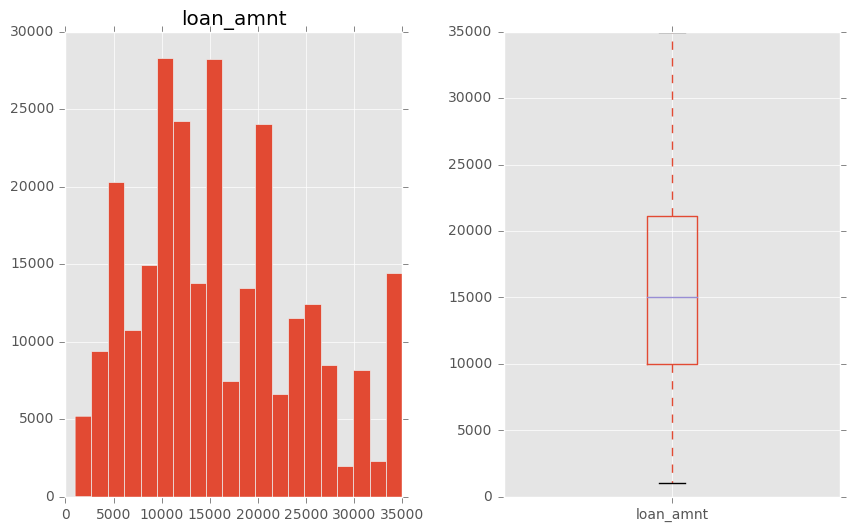

In [15]:
#Apply the following analysis on the types of features you chose. 

# 1.    For continuous variables, plot histograms, box plot, identify outliers
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "loan_amnt", bins = 20,ax = axs[0])
df_train_cur_nomissing.boxplot(column = "loan_amnt", ax = axs[1])

Seems like loan_amnt has no many outliers

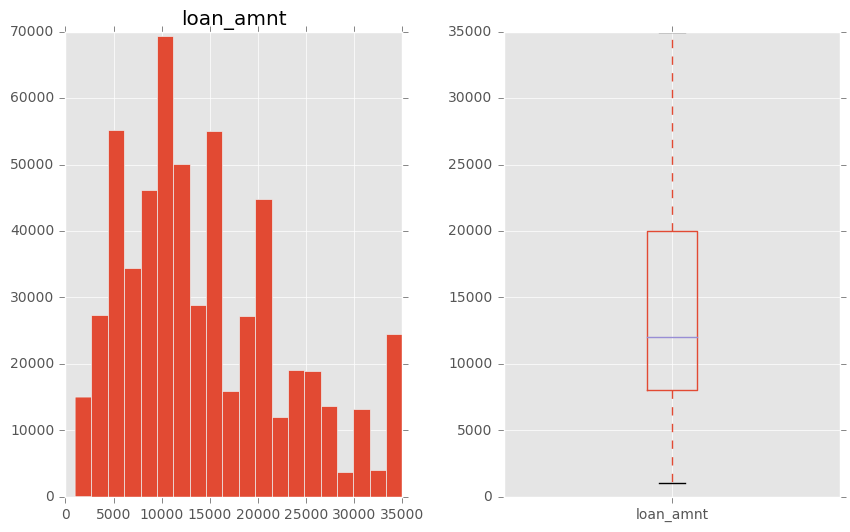

In [16]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "loan_amnt", bins = 20,ax = axs[0])
df_train_past_nomissing.boxplot(column = "loan_amnt", ax = axs[1])

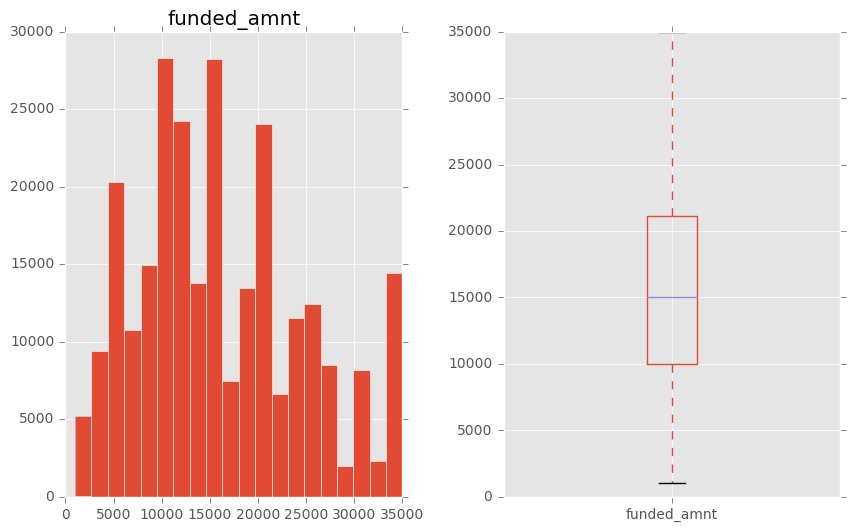

In [17]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "funded_amnt", bins = 20,ax = axs[0])
df_train_cur_nomissing.boxplot(column = "funded_amnt", ax = axs[1])

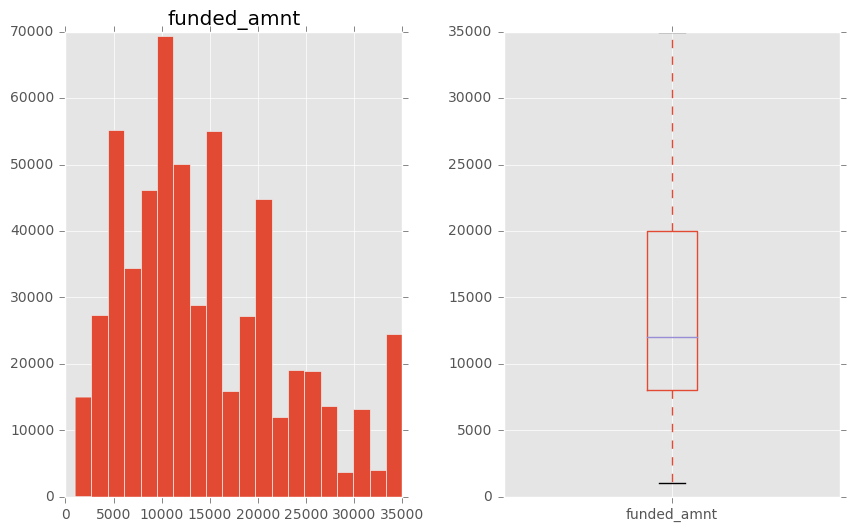

In [18]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "funded_amnt", bins = 20,ax = axs[0])
df_train_past_nomissing.boxplot(column = "funded_amnt", ax = axs[1])

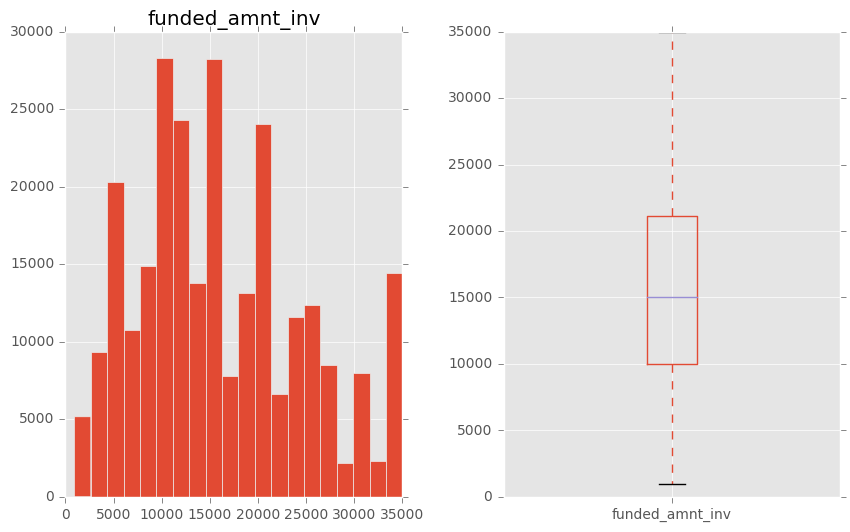

In [19]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "funded_amnt_inv", bins = 20,ax = axs[0])
df_train_cur_nomissing.boxplot(column = "funded_amnt_inv", ax = axs[1])

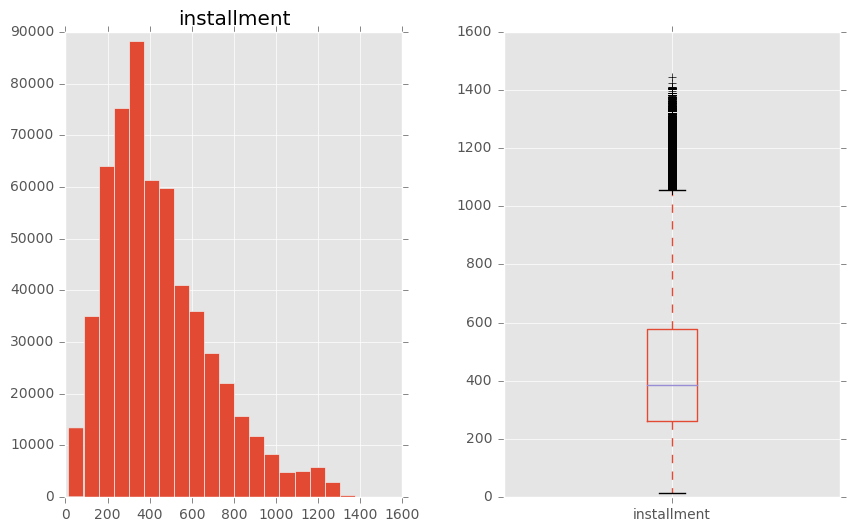

In [20]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "installment", bins = 20,ax=axs[0])
df_train_past_nomissing.boxplot(column = "installment", ax=axs[1])

We can see there are many outliers in "installment", and the histogram has right-skrew.

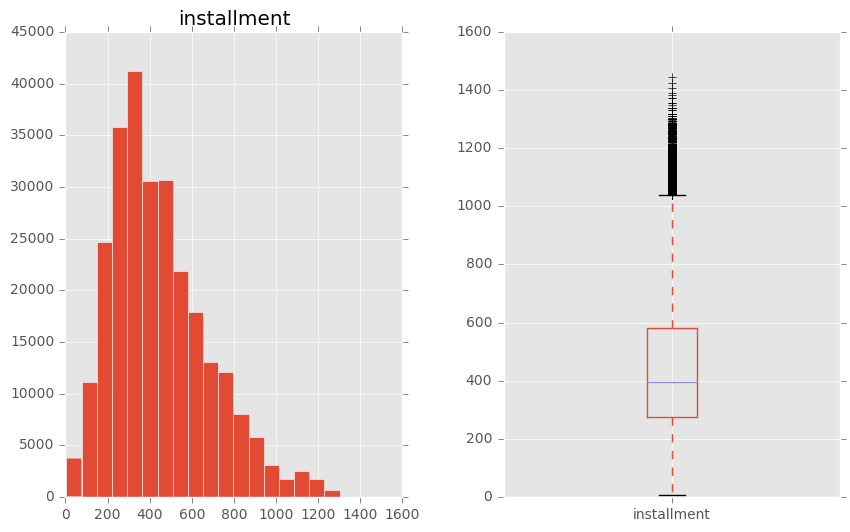

In [21]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "installment", bins = 20,ax=axs[0])
df_train_cur_nomissing.boxplot(column = "installment", ax=axs[1])

In [22]:
max(df_train_past_nomissing['installment'])

1445.46

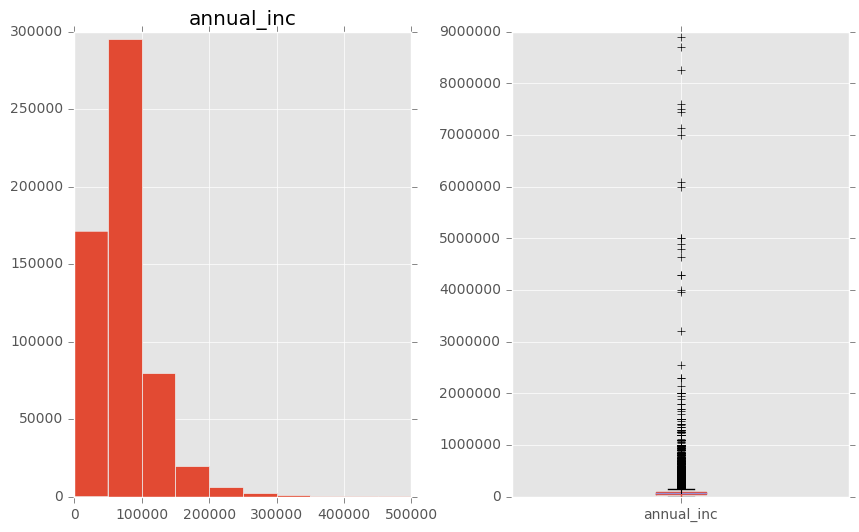

In [23]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "annual_inc", bins = 10,range = (0,500000),ax=axs[0])
df_train_past_nomissing.boxplot(column = "annual_inc", ax=axs[1])

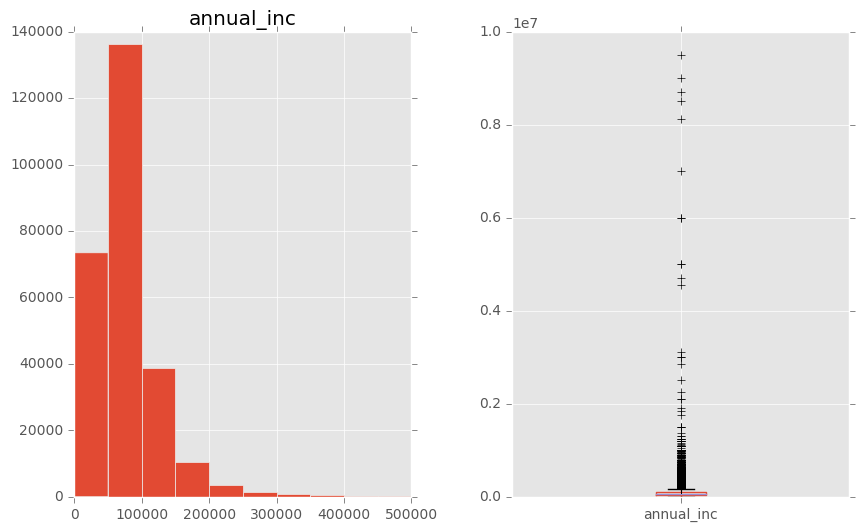

In [24]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "annual_inc", bins = 10,range = (0,500000),ax=axs[0])
df_train_cur_nomissing.boxplot(column = "annual_inc", ax=axs[1])

In [25]:
df_train_cur_nomissing['annual_inc'].value_counts()

60000.00     10337
50000.00      9333
65000.00      7674
70000.00      7439
80000.00      7105
75000.00      7000
40000.00      6993
45000.00      6735
55000.00      6270
100000.00     5375
90000.00      5243
85000.00      4859
35000.00      4397
120000.00     4153
30000.00      3801
52000.00      3715
110000.00     3472
48000.00      3369
42000.00      3294
72000.00      2895
95000.00      2863
150000.00     2718
62000.00      2328
125000.00     2299
130000.00     2133
38000.00      2039
56000.00      2009
105000.00     1991
36000.00      1984
32000.00      1977
             ...  
102999.00        1
38174.21         1
51494.00         1
102975.00        1
86203.11         1
71479.72         1
79752.00         1
25741.00         1
44511.12         1
51481.00         1
58196.40         1
43182.00         1
33948.00         1
205878.00        1
80681.40         1
51465.00         1
79758.00         1
102927.00        1
51460.00         1
51456.00         1
51454.00         1
43176.00    

We can see there are many outliers, which might influence our prediction.

In [26]:
# for annual_inc, calcate the group mean with regard with response
df_train_cur_nomissing.groupby("loan_status",as_index = False)['annual_inc'].mean()

loan_status    annual_inc
0             Current  77593.447937
1             Default  72607.666667
2     In Grace Period  75432.734347
3   Late (16-30 days)  76415.152840
4  Late (31-120 days)  73355.285797

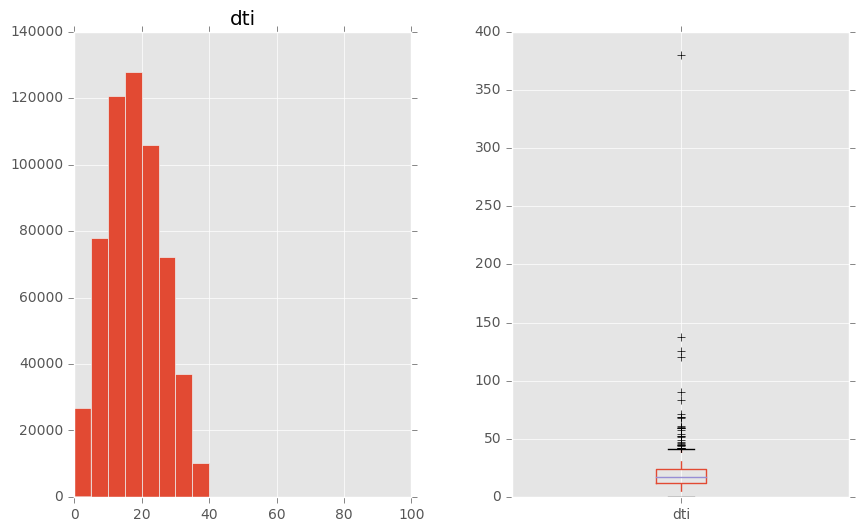

In [27]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "dti", bins = 20, range = (0,100),ax=axs[0])
df_train_past_nomissing.boxplot(column = "dti", ax=axs[1])

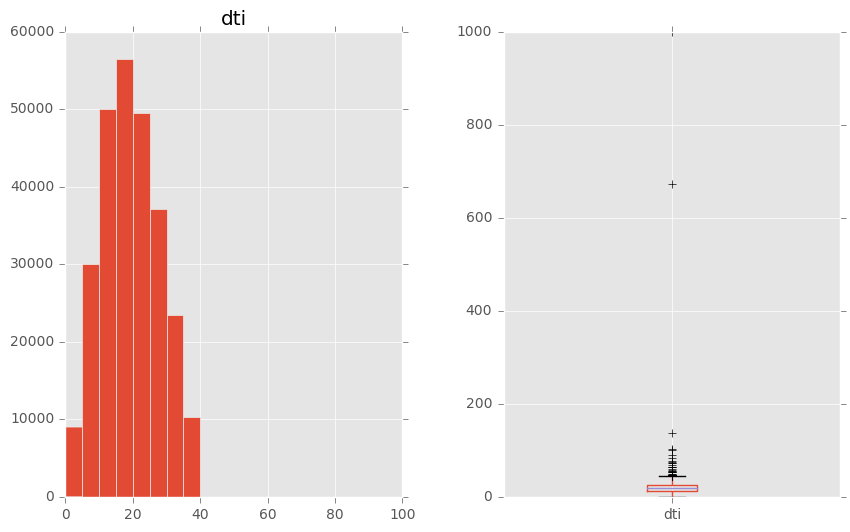

In [28]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "dti", bins = 20, range = (0,100),ax=axs[0])
df_train_cur_nomissing.boxplot(column = "dti", ax=axs[1])

We can there are many outliers in "dti"

In [29]:
df_train_past_nomissing['dti'].value_counts().sort_index(ascending = False).head(100)

380.53     1
137.40     1
125.25     1
120.66     1
90.00      1
83.64      1
71.40      1
68.41      1
68.30      1
67.50      1
61.21      1
60.08      1
59.26      2
59.18      1
57.14      1
54.43      1
52.80      1
52.45      1
51.20      1
48.56      1
46.92      1
46.28      1
45.77      1
44.43      1
44.40      1
44.24      1
43.98      1
42.10      1
42.04      1
41.94      1
          ..
39.61     11
39.60     25
39.59     12
39.58     20
39.57     15
39.56     12
39.55     14
39.54     15
39.53     10
39.52     23
39.51     18
39.50     15
39.49     16
39.48     11
39.47     11
39.46     20
39.45     17
39.44     15
39.43     20
39.42     12
39.41     18
39.40     17
39.39     16
39.38     14
39.37     21
39.36     17
39.35     13
39.34     15
39.33     20
39.32     20
Name: dti, Length: 100, dtype: int64

In [30]:
# for dti, calcate the group mean with regard with response
df_train_past_nomissing.groupby("loan_status",as_index = False)['dti'].mean()

loan_status        dti
0  Charged Off  19.966154
1   Fully Paid  17.379673

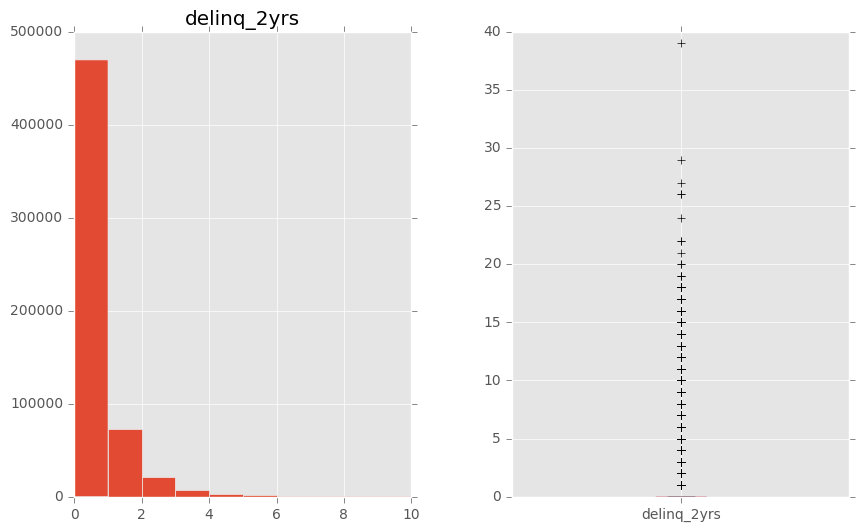

In [31]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "delinq_2yrs", range = (0,10),bins = 10,ax=axs[0])
df_train_past_nomissing.boxplot(column = "delinq_2yrs", ax=axs[1])

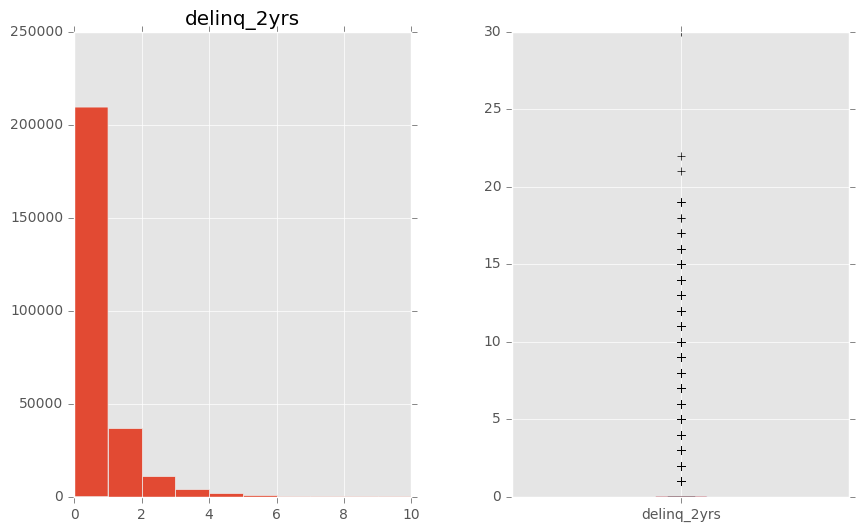

In [32]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "delinq_2yrs", range = (0,10),bins = 10,ax=axs[0])
df_train_cur_nomissing.boxplot(column = "delinq_2yrs", ax=axs[1])

In [33]:
df_train_past_nomissing['delinq_2yrs'].value_counts().sort_index(ascending = False).head(100)

39.0         1
29.0         1
27.0         1
26.0         2
24.0         1
22.0         2
21.0         1
20.0         2
19.0         3
18.0         9
17.0         7
16.0        12
15.0        15
14.0        28
13.0        43
12.0        62
11.0        81
10.0       118
9.0        175
8.0        273
7.0        503
6.0        919
5.0       1709
4.0       3318
3.0       7491
2.0      21367
1.0      72912
0.0     469735
Name: delinq_2yrs, dtype: int64

In [34]:
# for delinq_2yrs, calcate the group mean with regard with response
df_train_cur_nomissing.groupby("loan_status",as_index = False)['delinq_2yrs'].mean()

loan_status  delinq_2yrs
0             Current     0.352144
1             Default     0.333333
2     In Grace Period     0.440304
3   Late (16-30 days)     0.475456
4  Late (31-120 days)     0.396559

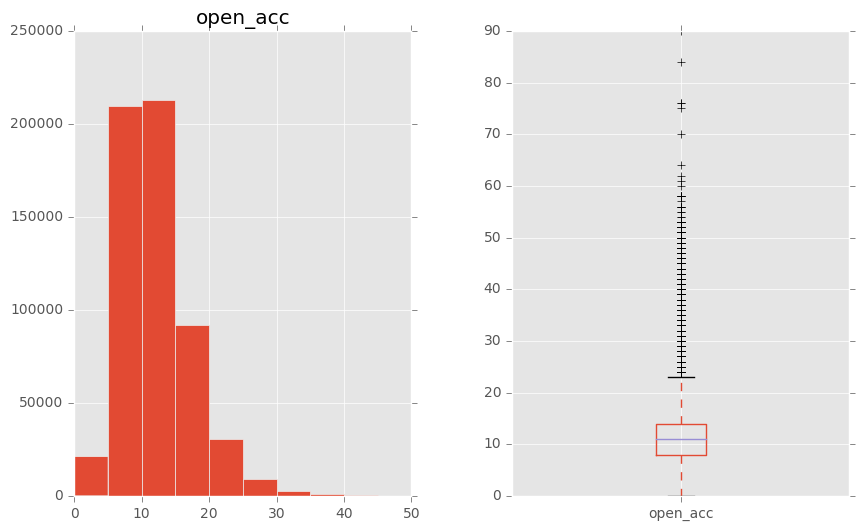

In [35]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "open_acc", bins = 10,range= (0,50),ax=axs[0])
df_train_past_nomissing.boxplot(column = "open_acc", ax=axs[1])

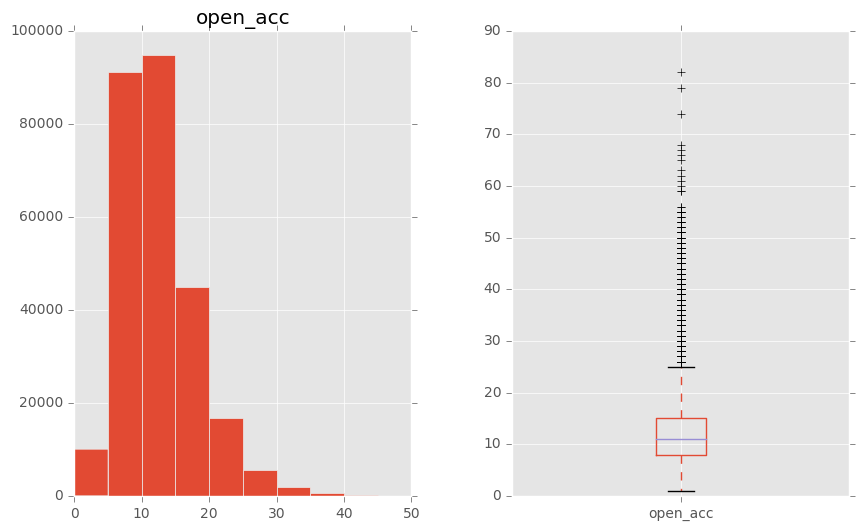

In [36]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "open_acc", bins = 10,range= (0,50),ax=axs[0])
df_train_cur_nomissing.boxplot(column = "open_acc", ax=axs[1])

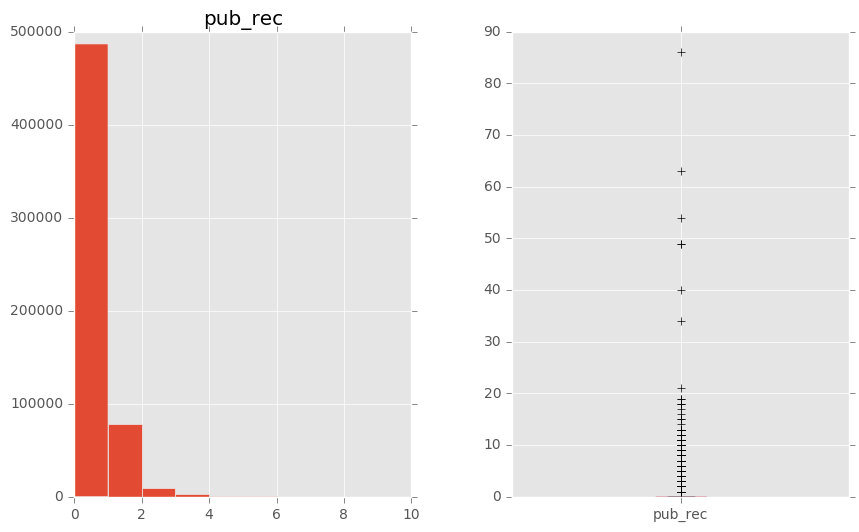

In [37]:
fig, axs = plt.subplots(1,2)

df_train_past_nomissing.hist(column = "pub_rec", bins = 10,range= (0,10),ax=axs[0])
df_train_past_nomissing.boxplot(column = "pub_rec", ax=axs[1])

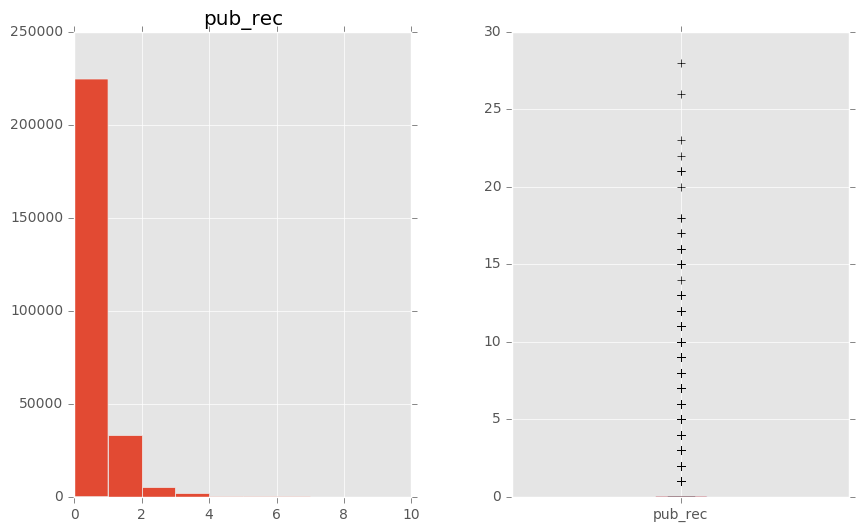

In [38]:
fig, axs = plt.subplots(1,2)

df_train_cur_nomissing.hist(column = "pub_rec", bins = 10,range= (0,10),ax=axs[0])
df_train_cur_nomissing.boxplot(column = "pub_rec", ax=axs[1])

In [39]:
# for pub_rec, calcate the group mean with regard with response
df_train_past_nomissing.groupby("loan_status",as_index = False)['pub_rec'].mean()

loan_status   pub_rec
0  Charged Off  0.221115
1   Fully Paid  0.191856

1.0    578791
Name: policy_code, dtype: int64

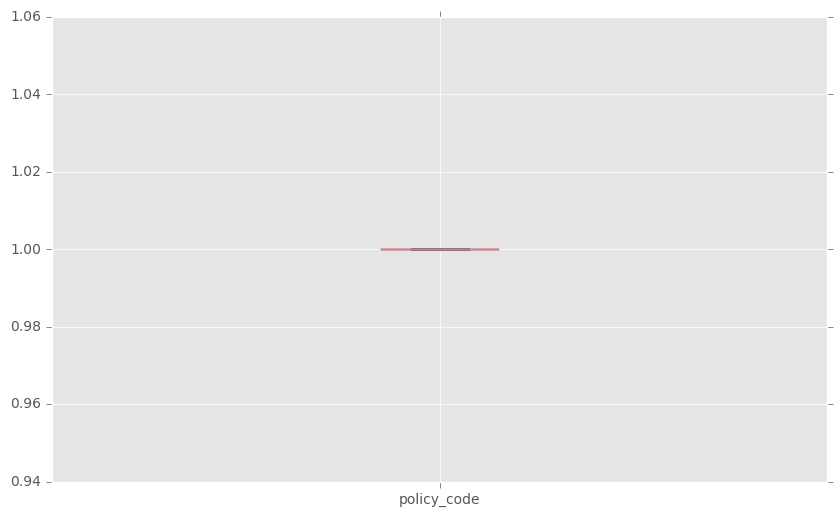

In [40]:
df_train_past_nomissing.boxplot(column = "policy_code")
#check levels of policy_code
df_train_past_nomissing["policy_code"].value_counts()

Therefore this variable only have one level, which means we could exclude this variable from modeling

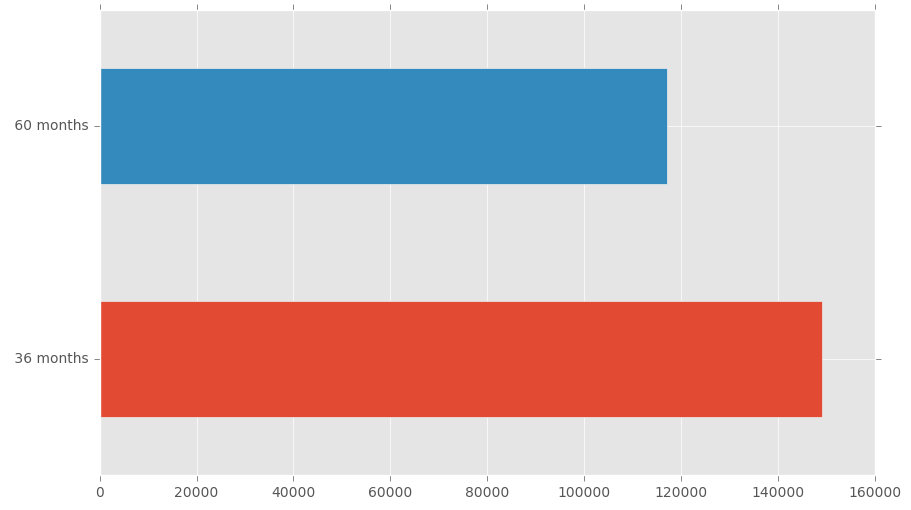

In [41]:
#2.    For categorical variables, plot box plots, bar charts
df_train_cur_nomissing["term"].value_counts().plot(kind = "barh")

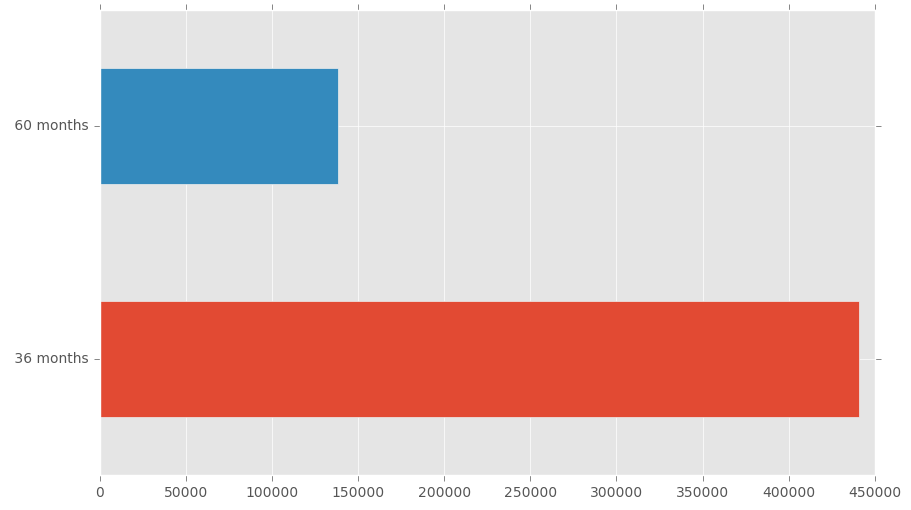

In [42]:
df_train_past_nomissing["term"].value_counts().plot(kind = "barh")

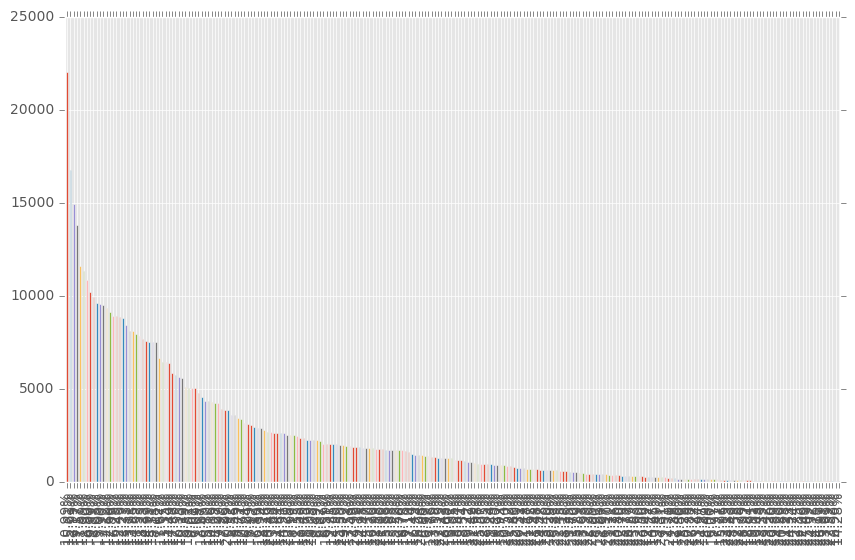

In [43]:
df_train_past_nomissing["int_rate"].value_counts().plot(kind = "bar")

Notice "int_rate" is actually numerical (identified as categorical jusr because the % mark), we convert it to numerical feature later

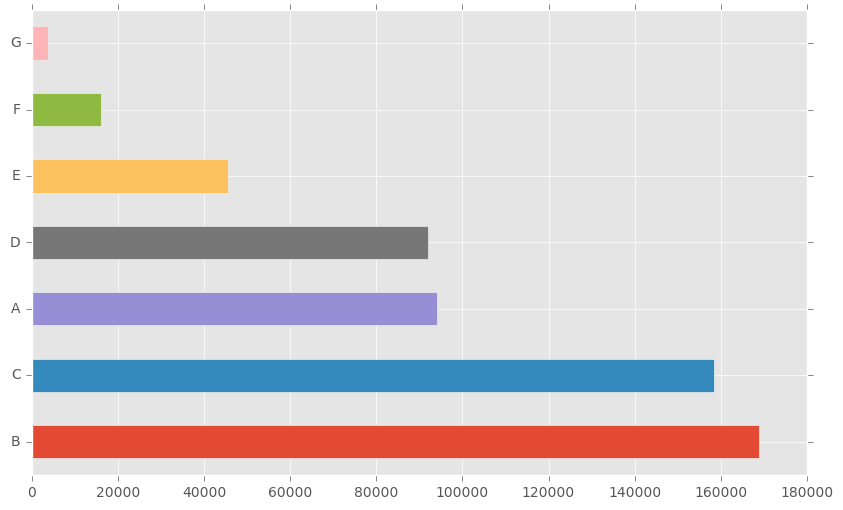

In [44]:
df_train_past_nomissing["grade"].value_counts().plot(kind = "barh")

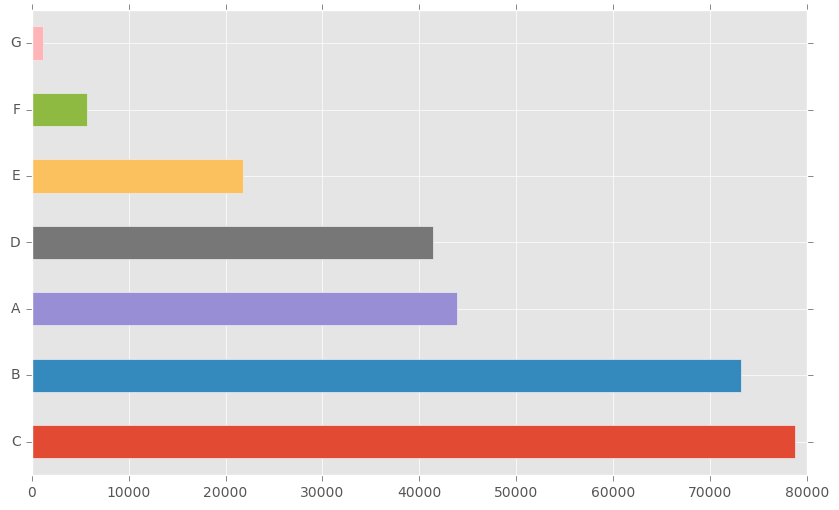

In [45]:
df_train_cur_nomissing["grade"].value_counts().plot(kind = "barh")

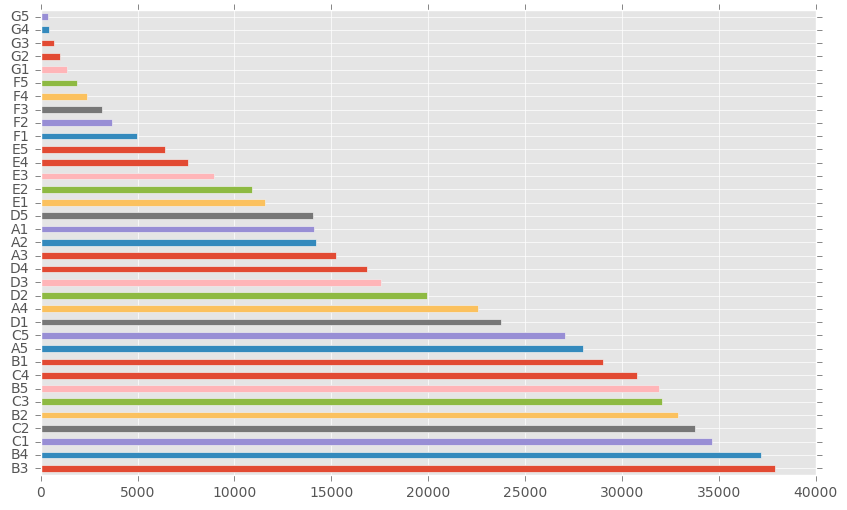

In [46]:
df_train_past_nomissing["sub_grade"].value_counts().plot(kind = "barh")

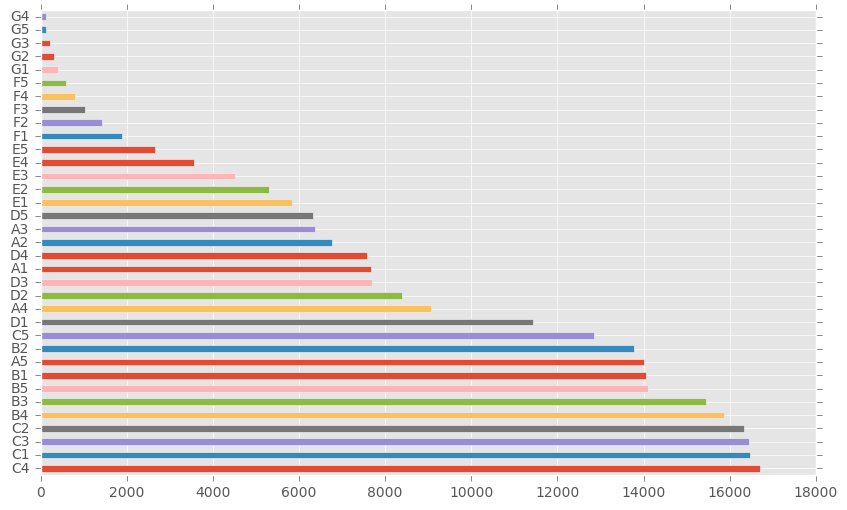

In [47]:
df_train_cur_nomissing["sub_grade"].value_counts().plot(kind = "barh")

In [48]:
df_train_cur_nomissing["emp_title"].value_counts()

Teacher                                  5571
Manager                                  4103
Owner                                    2659
Registered Nurse                         2129
RN                                       2089
Supervisor                               1834
Sales                                    1501
Project Manager                          1439
owner                                    1430
Office Manager                           1390
Driver                                   1311
General Manager                          1267
Director                                 1227
President                                1224
teacher                                  1181
manager                                  1124
Engineer                                  940
Vice President                            906
Attorney                                  905
driver                                    849
Operations Manager                        764
Accountant                        

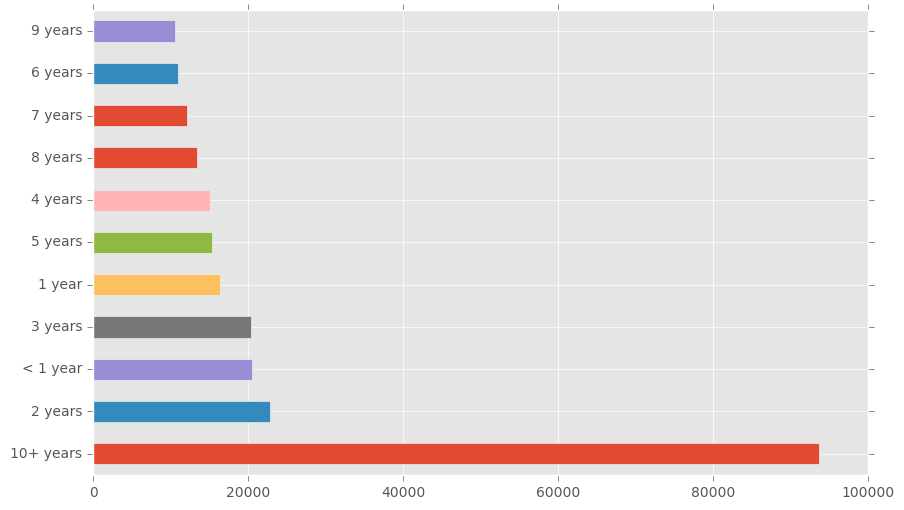

In [49]:
df_train_cur_nomissing["emp_length"].value_counts().plot(kind = "barh")

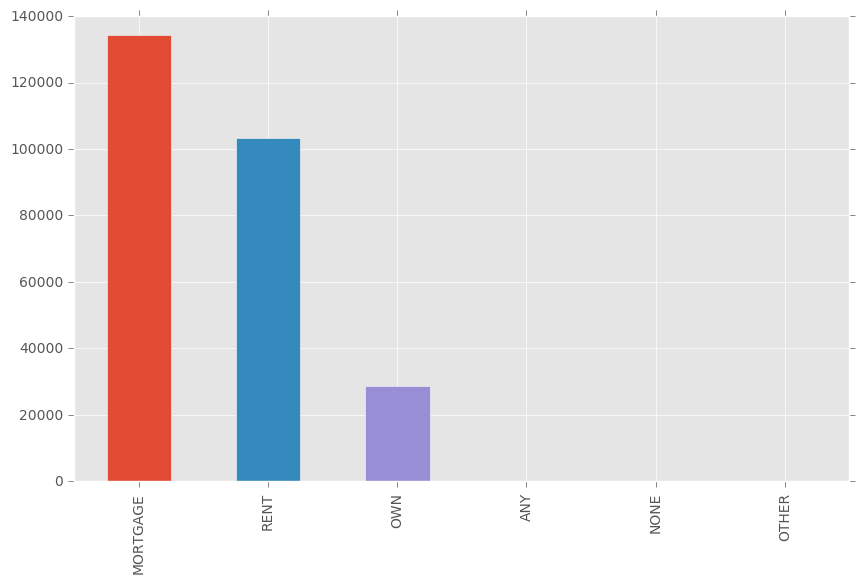

In [50]:
df_train_cur_nomissing["home_ownership"].value_counts().plot(kind = "bar")

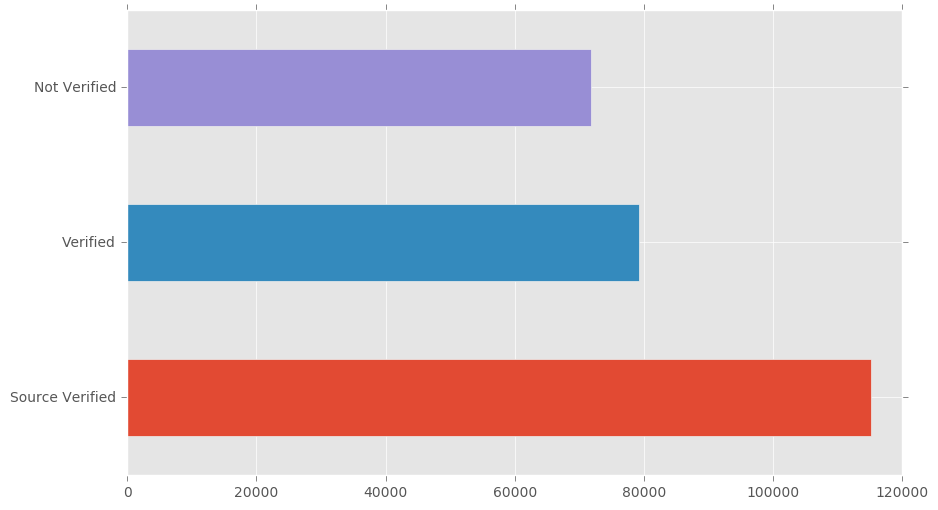

In [51]:
df_train_cur_nomissing["verification_status"].value_counts().plot(kind = "barh")

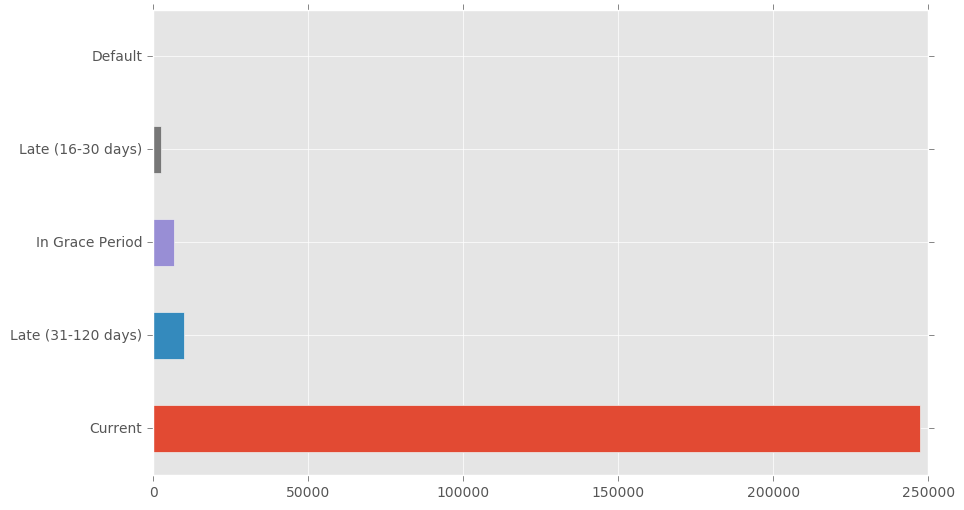

In [52]:
df_train_cur_nomissing["loan_status"].value_counts().plot(kind = "barh")

In [53]:
df_train_past_nomissing["disbursement_method"].value_counts()

Cash    578791
Name: disbursement_method, dtype: int64

We can exclude "disbursement_method" from our modeling since it only has one level

In [54]:
#3.    Transform the dependent variable into a binary variable (default/non-default)
# Based on the discussion in WeChat group, Transform responses to binary variable respectively: 
# for past loans: add “ChargedOff” as response, 1-Charged Off, 0- fully Paid
# for current loans: add “Default” as response, 0- Current, 1-Other (Default, Late, In Grace Period)

# Past loans
lookup = ["Charged Off"]
df_train_past_nomissing['ChargedOff'] = np.where(df_train_past_nomissing['loan_status'].isin(lookup), 1, 0)
df_test_past_nomissing['ChargedOff'] = np.where(df_test_past_nomissing['loan_status'].isin(lookup), 1, 0)

C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
# Current loans
lookup = ["Current"]
df_train_cur_nomissing['Default'] = np.where(df_train_cur_nomissing['loan_status'].isin(lookup), 0, 1)
df_test_cur_nomissing['Default'] = np.where(df_test_cur_nomissing['loan_status'].isin(lookup), 0, 1)

C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
# temp codes for correction
#df_train_cur_nomissing = df_train_cur_nomissing.rename(columns = {'ChargedOff':'Default'})
#df_test_cur_nomissing = df_test_cur_nomissing.rename(columns = {'ChargedOff':'Default'})

In [57]:
# drop "loan_status" and other two variables with low variance from dataframes
df_train_past_nomissing.drop(["loan_status","policy_code","disbursement_method"], axis = 1, inplace = True)
df_test_past_nomissing.drop(["loan_status","policy_code","disbursement_method"], axis = 1, inplace = True)

df_train_cur_nomissing.drop(["loan_status","policy_code","disbursement_method"], axis = 1, inplace = True)
df_test_cur_nomissing.drop(["loan_status","policy_code","disbursement_method"], axis = 1, inplace = True)

C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWi

In [58]:
print list(df_train_past_nomissing)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_in

In [59]:
# update feature lists(profile, payment, loan)
ft_loan_past.remove("policy_code")
ft_loan_past.remove("disbursement_method")
ft_loan_cur.remove("policy_code")
ft_loan_cur.remove("disbursement_method")

In [60]:
#categorize all features into numerical features, string features, or datetime features
ft_str_past = list(df_train_past_nomissing.select_dtypes(include = ['object']))
ft_dt_past = ["issue_d","last_pymnt_d","last_credit_pull_d"]
ft_num_past = list(df_train_past_nomissing.select_dtypes(include = ['float64']))

ft_str_cur = list(df_train_cur_nomissing.select_dtypes(include = ['object']))
ft_dt_cur = ["issue_d","last_pymnt_d","last_credit_pull_d"]
ft_num_cur = list(df_train_cur_nomissing.select_dtypes(include = ['float64']))

In [61]:
print ft_num_past

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'p

In [62]:
# notice variables "term" and "int_rate", etc. might be actually numerical, so we first check them
# then convert them to numerical variables
print df_train_past_nomissing["term"].unique()
print df_train_past_nomissing["int_rate"].unique()

[' 36 months' ' 60 months' nan]
['  9.67%' ' 13.53%' ' 16.24%' '  7.62%' ' 11.99%' ' 19.97%' ' 14.98%'
 ' 13.98%' ' 12.85%' ' 10.99%' ' 22.90%' ' 14.47%' '  6.62%' '  8.90%'
 '  7.90%' ' 18.25%' '  6.03%' ' 15.61%' ' 20.50%' ' 19.22%' ' 17.57%'
 ' 23.40%' ' 16.99%' ' 23.70%' ' 22.40%' ' 21.48%' ' 25.89%' ' 25.80%'
 ' 24.99%' ' 24.08%' ' 26.06%' ' 25.99%' ' 25.57%' ' 24.50%' ' 25.83%'
 '  6.00%' ' 16.20%' ' 13.67%' ' 17.76%' ' 19.52%' ' 12.99%' ' 19.20%'
 ' 14.30%' ' 21.70%' ' 17.10%' ' 15.10%' ' 18.55%' ' 23.10%' ' 20.20%'
 ' 21.00%' '  6.97%' '  9.99%' '  9.25%' '  8.60%' ' 15.22%' ' 18.85%'
 ' 16.78%' ' 13.68%' ' 11.55%' ' 22.20%' '  9.71%' ' 14.33%' ' 22.70%'
 ' 17.56%' ' 13.05%' ' 15.88%' ' 20.80%' ' 12.35%' ' 23.50%' ' 10.64%'
 ' 21.60%' ' 24.89%' ' 21.15%' ' 20.31%' ' 25.28%' ' 16.29%' ' 15.31%'
 ' 17.77%' ' 17.27%' ' 10.16%' ' 18.75%' ' 13.11%' ' 12.12%' ' 19.05%'
 ' 15.80%' ' 11.14%' ' 14.09%' ' 23.28%' ' 19.72%' ' 23.76%' ' 20.49%'
 ' 18.49%' ' 21.98%' ' 23.63%' ' 24.70%' ' 23

Therefore the "int_rate","revol_util" should be numrical

In [63]:
# we convert these two variable to float
df_train_past_nomissing["int_rate_%"] = df_train_past_nomissing["int_rate"].replace('%','',regex=True).astype('float')
df_train_past_nomissing["revol_util_%"] = df_train_past_nomissing["revol_util"].replace('%','',regex=True).astype('float')
df_train_past_nomissing = df_train_past_nomissing.drop(["int_rate","revol_util"],axis = 1)

df_test_past_nomissing["int_rate_%"] = df_test_past_nomissing["int_rate"].replace('%','',regex=True).astype('float')
df_test_past_nomissing["revol_util_%"] = df_test_past_nomissing["revol_util"].replace('%','',regex=True).astype('float')
df_test_past_nomissing = df_test_past_nomissing.drop(["int_rate","revol_util"],axis = 1)

# for current loan
df_train_cur_nomissing["int_rate_%"] = df_train_cur_nomissing["int_rate"].replace('%','',regex=True).astype('float')
df_train_cur_nomissing["revol_util_%"] = df_train_cur_nomissing["revol_util"].replace('%','',regex=True).astype('float')
df_train_cur_nomissing = df_train_cur_nomissing.drop(["int_rate","revol_util"],axis = 1)

df_test_cur_nomissing["int_rate_%"] = df_test_cur_nomissing["int_rate"].replace('%','',regex=True).astype('float')
df_test_cur_nomissing["revol_util_%"] = df_test_cur_nomissing["revol_util"].replace('%','',regex=True).astype('float')
df_test_cur_nomissing = df_test_cur_nomissing.drop(["int_rate","revol_util"],axis = 1)

C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [64]:
# update related feature lists
ft_str_past.remove("int_rate")
ft_str_past.remove("revol_util")

ft_str_cur.remove("int_rate")
ft_str_cur.remove("revol_util")

ft_num_past.append("int_rate_%")
ft_num_past.append("revol_util_%")

ft_num_cur.append("int_rate_%")
ft_num_cur.append("revol_util_%")

ft_profile_past.remove("revol_util") 
ft_profile_past.append("revol_util_%")

ft_profile_cur.remove("revol_util") 
ft_profile_cur.append("revol_util_%")

ft_loan_past.remove("int_rate") 
ft_loan_past.append("int_rate_%")

ft_loan_cur.remove("int_rate") 
ft_loan_cur.append("int_rate_%")

In [65]:
#4.    Compute relevance between <i.v, d.v.>
'''
#For numerical variables, calculate correlation between <i.v, d.v.>
DV = df_x_train.iloc[:, -1]

list_corr = []
for item in ft_num:
    correlation = DV.corr(df_x_train[item])
    list_corr.append(correlation)

df_corr = pd.DataFrame(np.array(list_corr).reshape(1,len(ft_num)), columns = ft_num)
df_corr = df_corr.T
df_corr.columns = ["Correlation"]
df_corr["abs"] = abs(df_corr["Correlation"])
print df_corr.sort_values("abs", ascending = False)
# instantiate a logistic regression model to calculate relevance
#model = LogisticRegression()
#model = model.fit(IV, DV)

#sklearn.feature_selection.mutual_info_classif(IV, DV)
'''

'\n#For numerical variables, calculate correlation between <i.v, d.v.>\nDV = df_x_train.iloc[:, -1]\n\nlist_corr = []\nfor item in ft_num:\n    correlation = DV.corr(df_x_train[item])\n    list_corr.append(correlation)\n\ndf_corr = pd.DataFrame(np.array(list_corr).reshape(1,len(ft_num)), columns = ft_num)\ndf_corr = df_corr.T\ndf_corr.columns = ["Correlation"]\ndf_corr["abs"] = abs(df_corr["Correlation"])\nprint df_corr.sort_values("abs", ascending = False)\n# instantiate a logistic regression model to calculate relevance\n#model = LogisticRegression()\n#model = model.fit(IV, DV)\n\n#sklearn.feature_selection.mutual_info_classif(IV, DV)\n'

In [66]:
'''
#For categorical variables, calculate Cramér's V between <i.v, d.v.>
list_CV = []

for item in ft_str:
    contingency = pd.crosstab(index = DV, columns = df_x_train[item])
    contingency.columns = df_x_train[item].value_counts().index.tolist()
    contingency.index = ["0","1"]
    #print contingency

    chi2, p, dof, expected = chi2_contingency(contingency)

    #calculate Cramér V
    CV = sqrt(chi2/ (len(df_x_train) * (min(len(unique(df_x_train[item])),len(unique(DV))) - 1)))
    list_CV.append(CV)

df_CV = pd.DataFrame(np.array(list_CV).reshape(1,len(ft_str)), columns = ft_str)
df_CV = df_CV.T
df_CV.columns = ["CV"]
print df_CV


# instantiate a logistic regression model to calculate relevance
#model = LogisticRegression()
#model = model.fit(IV, DV)

#sklearn.feature_selection.mutual_info_classif(IV, DV)
'''

'\n#For categorical variables, calculate Cram\xc3\xa9r\'s V between <i.v, d.v.>\nlist_CV = []\n\nfor item in ft_str:\n    contingency = pd.crosstab(index = DV, columns = df_x_train[item])\n    contingency.columns = df_x_train[item].value_counts().index.tolist()\n    contingency.index = ["0","1"]\n    #print contingency\n\n    chi2, p, dof, expected = chi2_contingency(contingency)\n\n    #calculate Cram\xc3\xa9r V\n    CV = sqrt(chi2/ (len(df_x_train) * (min(len(unique(df_x_train[item])),len(unique(DV))) - 1)))\n    list_CV.append(CV)\n\ndf_CV = pd.DataFrame(np.array(list_CV).reshape(1,len(ft_str)), columns = ft_str)\ndf_CV = df_CV.T\ndf_CV.columns = ["CV"]\nprint df_CV\n\n\n# instantiate a logistic regression model to calculate relevance\n#model = LogisticRegression()\n#model = model.fit(IV, DV)\n\n#sklearn.feature_selection.mutual_info_classif(IV, DV)\n'

In [67]:
# impute missing values before calculating relevance

# Since the percents of missing values are very low, we just impute the missing values with most frequently values simply
mode_list = df_train_past_nomissing[ft_str_past].mode()
for i in range(len(ft_str_past)):
    df_train_past_nomissing[ft_str_past[i]].fillna(mode_list[ft_str_past[i]][0], inplace = True)
    # samely impute testing set
    df_test_past_nomissing[ft_str_past[i]].fillna(mode_list[ft_str_past[i]][0], inplace = True)

mode_list = df_train_cur_nomissing[ft_str_cur].mode()
for i in range(len(ft_str_cur)):
    df_train_cur_nomissing[ft_str_cur[i]].fillna(mode_list[ft_str_cur[i]][0], inplace = True)
    df_test_cur_nomissing[ft_str_cur[i]].fillna(mode_list[ft_str_cur[i]][0], inplace = True)

In [68]:
# impute numerical variables
# We just impute the missing values with median 
for item in ft_num_past:
    df_train_past_nomissing[item].fillna(df_train_past_nomissing[item].median(), inplace = True)
    #impute testing set with same median
    df_test_past_nomissing[item].fillna(df_train_past_nomissing[item].median(), inplace = True)

for item in ft_num_cur:
    df_train_cur_nomissing[item].fillna(df_train_cur_nomissing[item].median(), inplace = True)
    #impute testing set with same median
    df_test_cur_nomissing[item].fillna(df_train_cur_nomissing[item].median(), inplace = True)

In [69]:
np.sum(df_train_cur_nomissing.isnull())/df_train_cur_nomissing.shape[0]

loan_amnt                     0.0
funded_amnt                   0.0
funded_amnt_inv               0.0
term                          0.0
installment                   0.0
grade                         0.0
sub_grade                     0.0
emp_title                     0.0
emp_length                    0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
issue_d                       0.0
pymnt_plan                    0.0
purpose                       0.0
title                         0.0
zip_code                      0.0
addr_state                    0.0
dti                           0.0
delinq_2yrs                   0.0
earliest_cr_line              0.0
inq_last_6mths                0.0
mths_since_last_delinq        0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal                     0.0
total_acc                     0.0
initial_list_status           0.0
out_prncp                     0.0
out_prncp_inv 

In [70]:
%%time
# here we calculate  mutual information between i.v. and d.v.--credit to Richard X
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing

#datatypes = current_loans.dtypes # current_loans is a dataframe
#num_cols = datatypes[(datatypes=='float64') | (datatypes=='int32')].index.tolist() # get numerical cols
mut_inf = []
for c in ft_num_past:
    mut_inf.append((c, mutual_info_classif(df_train_past_nomissing[c].reshape(-1,1),df_train_past_nomissing['ChargedOff'])[0]))


C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Wall time: 10min 55s


In [71]:
%%time
#cat_cols = datatypes[datatypes=='object'].index.tolist()
le = preprocessing.LabelEncoder()

cat_mut_inf = []
for c in ft_str_past:
    newcol = df_train_past_nomissing[c].fillna('unk')
    newcol = le.fit_transform(newcol)
    cat_mut_inf.append((c, mutual_info_classif(newcol.reshape(-1,1),df_train_past_nomissing['ChargedOff'])[0]))

Wall time: 3min 32s


In [72]:
print sorted(mut_inf, key = lambda x: x[1], reverse = True)
print sorted(cat_mut_inf, key = lambda x: x[1], reverse = True)

[('total_rec_prncp', 0.49314625763341913), ('last_pymnt_amnt', 0.32708573943089014), ('recoveries', 0.2620364266806805), ('collection_recovery_fee', 0.23186889088320406), ('total_pymnt', 0.10949158309755069), ('total_pymnt_inv', 0.10779730442286306), ('int_rate_%', 0.041613316257319566), ('installment', 0.031234514502270994), ('total_rec_int', 0.026951544172647557), ('pct_tl_nvr_dlq', 0.024486798132649756), ('num_tl_op_past_12m', 0.018612480700295864), ('total_rec_late_fee', 0.015359438938011838), ('percent_bc_gt_75', 0.013487151680615428), ('acc_open_past_24mths', 0.013221929008511824), ('num_actv_bc_tl', 0.0129413520587911), ('inq_last_6mths', 0.012613511579425918), ('num_rev_tl_bal_gt_0', 0.012312034064796418), ('num_actv_rev_tl', 0.011106539938093185), ('mort_acc', 0.010637404340143819), ('num_bc_sats', 0.0098824434277779982), ('funded_amnt', 0.0095083291193791553), ('loan_amnt', 0.0093677198541826101), ('dti', 0.008395309586825439), ('funded_amnt_inv', 0.0077548571143546408), ('nu

In [73]:
%%time
# check relevance of i.v. and d.v. in current loan set
mut_inf_cur = []
for c in ft_num_cur:
    mut_inf_cur.append((c, mutual_info_classif(df_train_cur_nomissing[c].reshape(-1,1),df_train_cur_nomissing['Default'])[0]))

C:\Users\eve2ada\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Wall time: 4min 25s


In [74]:
%%time
#cat_cols = datatypes[datatypes=='object'].index.tolist()
le = preprocessing.LabelEncoder()

cat_mut_inf_cur = []
for c in ft_str_cur:
    newcol = df_train_cur_nomissing[c].fillna('unk')
    newcol = le.fit_transform(newcol)
    cat_mut_inf_cur.append((c, mutual_info_classif(newcol.reshape(-1,1),df_train_cur_nomissing['Default'])[0]))

Wall time: 1min 38s


In [75]:
print sorted(mut_inf_cur, key = lambda x: x[1], reverse = True)
print sorted(cat_mut_inf_cur, key = lambda x: x[1], reverse = True)

[('out_prncp', 0.015872777771391844), ('total_rec_late_fee', 0.015542074416404095), ('out_prncp_inv', 0.015067392117267042), ('total_rec_prncp', 0.013967288065886985), ('pct_tl_nvr_dlq', 0.012741044104187527), ('last_pymnt_amnt', 0.011080690443271424), ('num_tl_op_past_12m', 0.009847272517326644), ('total_rec_int', 0.0095577815373648622), ('int_rate_%', 0.0094785764152418572), ('mths_since_last_delinq', 0.0094708246769241722), ('total_pymnt', 0.0090757592792403141), ('total_pymnt_inv', 0.0087276911501430465), ('acc_open_past_24mths', 0.0077313596066830303), ('percent_bc_gt_75', 0.0071286512941077795), ('num_actv_bc_tl', 0.0061515486821108745), ('installment', 0.0054372287713335687), ('num_bc_sats', 0.0051073476674048379), ('num_rev_tl_bal_gt_0', 0.0050191882288730394), ('mort_acc', 0.0048945430310403104), ('inq_last_6mths', 0.0048692511015404616), ('num_actv_rev_tl', 0.0048254552553492758), ('num_bc_tl', 0.0036375644927240103), ('mo_sin_rcnt_tl', 0.0035238539072588448), ('open_acc', 0.

In [76]:
#5.    Evaluate relevance between i.v. (You may choose a few i.v. that you think are important)
# several pairs of numerical variables
correlation1 = df_train_past_nomissing["funded_amnt"].corr(df_train_past_nomissing["funded_amnt_inv"])
correlation2 = df_train_past_nomissing["out_prncp"].corr(df_train_past_nomissing["out_prncp_inv"])
correlation3 = df_train_past_nomissing["total_pymnt"].corr(df_train_past_nomissing["total_pymnt_inv"])
correlation4 = df_train_past_nomissing["total_rec_prncp"].corr(df_train_past_nomissing["total_rec_int"])
correlation5 = df_train_past_nomissing["total_rec_int"].corr(df_train_past_nomissing["total_rec_late_fee"])
correlation6 = df_train_past_nomissing["total_rec_prncp"].corr(df_train_past_nomissing["total_rec_late_fee"])
correlation7 = df_train_past_nomissing["mo_sin_old_rev_tl_op"].corr(df_train_past_nomissing["mo_sin_rcnt_rev_tl_op"])
correlation8 = df_train_past_nomissing["mths_since_recent_bc"].corr(df_train_past_nomissing["mths_since_recent_inq"])
print correlation1,correlation2,correlation3,correlation4,correlation5,correlation6,correlation7,correlation8

0.99995800238 nan 0.999987024757 0.536506348154 0.104102944292 -0.0188238010019 0.0599965561033 0.0694316341318


In [77]:
correlation1 = df_train_cur_nomissing["funded_amnt"].corr(df_train_cur_nomissing["funded_amnt_inv"])
correlation2 = df_train_cur_nomissing["out_prncp"].corr(df_train_cur_nomissing["out_prncp_inv"])
correlation3 = df_train_cur_nomissing["total_pymnt"].corr(df_train_cur_nomissing["total_pymnt_inv"])
correlation4 = df_train_cur_nomissing["total_rec_prncp"].corr(df_train_cur_nomissing["total_rec_int"])
correlation5 = df_train_cur_nomissing["total_rec_int"].corr(df_train_cur_nomissing["total_rec_late_fee"])
correlation6 = df_train_cur_nomissing["total_rec_prncp"].corr(df_train_cur_nomissing["total_rec_late_fee"])
correlation7 = df_train_cur_nomissing["mo_sin_old_rev_tl_op"].corr(df_train_cur_nomissing["mo_sin_rcnt_rev_tl_op"])
correlation8 = df_train_cur_nomissing["mths_since_recent_bc"].corr(df_train_cur_nomissing["mths_since_recent_inq"])
print correlation1,correlation2,correlation3,correlation4,correlation5,correlation6,correlation7,correlation8

0.999994621044 0.999996295906 0.999995929299 0.489899443773 0.0842313318746 0.0522196936652 0.0776477325474 0.0702833629456


In [78]:
# several pairs of categorical variables
contingency = pd.crosstab(index = df_train_past_nomissing["emp_title"], columns = df_train_past_nomissing["emp_length"])
chi2, p1, dof, expected = chi2_contingency(contingency)
#calculate Cramér V
CV1 = sqrt(chi2/ (len(df_train_past_nomissing) * (min(len(unique(df_train_past_nomissing["emp_length"])),len(unique(df_train_past_nomissing["emp_title"]))) - 1)))

contingency = pd.crosstab(index = df_train_past_nomissing["grade"], columns = df_train_past_nomissing["term"])
chi2, p2, dof, expected = chi2_contingency(contingency)
#calculate Cramér V
CV2 = sqrt(chi2/ (len(df_train_past_nomissing) * (min(len(unique(df_train_past_nomissing["grade"])),len(unique(df_train_past_nomissing["term"]))) - 1)))

contingency = pd.crosstab(index = df_train_past_nomissing["emp_length"], columns = df_train_past_nomissing["home_ownership"])
chi2, p3, dof, expected = chi2_contingency(contingency)
#calculate Cramér V
CV3 = sqrt(chi2/ (len(df_train_past_nomissing) * (min(len(unique(df_train_past_nomissing["emp_length"])),len(unique(df_train_past_nomissing["home_ownership"]))) - 1)))

print CV1, p1, CV2, p2, CV3, p3

0.641216040353 0.0 0.465280535115 0.0 0.089693712168 0.0


In [79]:
# several pairs of categorical variables--Current loan set
contingency = pd.crosstab(index = df_train_cur_nomissing["emp_title"], columns = df_train_cur_nomissing["emp_length"])
chi2, p1, dof, expected = chi2_contingency(contingency)
#calculate Cramér V
CV1 = sqrt(chi2/ (len(df_train_cur_nomissing) * (min(len(unique(df_train_cur_nomissing["emp_length"])),len(unique(df_train_cur_nomissing["emp_title"]))) - 1)))

contingency = pd.crosstab(index = df_train_cur_nomissing["grade"], columns = df_train_cur_nomissing["term"])
chi2, p2, dof, expected = chi2_contingency(contingency)
#calculate Cramér V
CV2 = sqrt(chi2/ (len(df_train_cur_nomissing) * (min(len(unique(df_train_cur_nomissing["grade"])),len(unique(df_train_cur_nomissing["term"]))) - 1)))

contingency = pd.crosstab(index = df_train_cur_nomissing["emp_length"], columns = df_train_cur_nomissing["home_ownership"])
chi2, p3, dof, expected = chi2_contingency(contingency)
#calculate Cramér V
CV3 = sqrt(chi2/ (len(df_train_cur_nomissing) * (min(len(unique(df_train_cur_nomissing["emp_length"])),len(unique(df_train_cur_nomissing["home_ownership"]))) - 1)))

print CV1, p1, CV2, p2, CV3, p3

0.592978266663 0.0 0.466820177559 0.0 0.0924425071891 0.0


By the output we can tell the "emp_length" and "home_ownership" have no strong relevance


In [80]:
#6.    Sort variables based on relevance from high to low 
'''
#numerical variables (based on absolute value)
df_corr['sort'] = df_corr["Correlation"].abs()
#df_corr.sort(columns='sort').drop('sort', axis = 1)
df_corr.sort_values("sort",ascending = False).drop(['sort'], axis=1)
'''
# past loan-numerical i.v. vs. d.v.
df_train_mut_inf = pd.DataFrame(sorted(mut_inf, key = lambda x: x[1], reverse = True))
print df_train_mut_inf

                             0         1
0              total_rec_prncp  0.493146
1              last_pymnt_amnt  0.327086
2                   recoveries  0.262036
3      collection_recovery_fee  0.231869
4                  total_pymnt  0.109492
5              total_pymnt_inv  0.107797
6                   int_rate_%  0.041613
7                  installment  0.031235
8                total_rec_int  0.026952
9               pct_tl_nvr_dlq  0.024487
10          num_tl_op_past_12m  0.018612
11          total_rec_late_fee  0.015359
12            percent_bc_gt_75  0.013487
13        acc_open_past_24mths  0.013222
14              num_actv_bc_tl  0.012941
15              inq_last_6mths  0.012614
16         num_rev_tl_bal_gt_0  0.012312
17             num_actv_rev_tl  0.011107
18                    mort_acc  0.010637
19                 num_bc_sats  0.009882
20                 funded_amnt  0.009508
21                   loan_amnt  0.009368
22                         dti  0.008395
23             f

In [81]:
'''
#categorical variables
df_CV.sort_values("CV",ascending = False)
'''
# past loan-categorical i.v. vs. d.v.
df_train_cat_mut_inf = pd.DataFrame(sorted(cat_mut_inf, key = lambda x: x[1], reverse = True))
print df_train_cat_mut_inf

                       0         1
0     last_credit_pull_d  0.130730
1                  grade  0.052171
2              sub_grade  0.041851
3         home_ownership  0.038829
4    verification_status  0.036275
5   debt_settlement_flag  0.034963
6                purpose  0.032273
7                   term  0.022601
8                  title  0.021541
9           last_pymnt_d  0.019657
10   initial_list_status  0.018781
11             emp_title  0.011561
12            emp_length  0.009252
13               issue_d  0.008502
14            addr_state  0.006407
15              zip_code  0.002624
16      earliest_cr_line  0.002542
17         hardship_flag  0.000100
18            pymnt_plan  0.000000
19      application_type  0.000000


In [82]:
# current loan-numerical i.v. vs. d.v.
df_train_mut_inf_cur = pd.DataFrame(sorted(mut_inf_cur, key = lambda x: x[1], reverse = True))
print df_train_mut_inf_cur

                             0         1
0                    out_prncp  0.015873
1           total_rec_late_fee  0.015542
2                out_prncp_inv  0.015067
3              total_rec_prncp  0.013967
4               pct_tl_nvr_dlq  0.012741
5              last_pymnt_amnt  0.011081
6           num_tl_op_past_12m  0.009847
7                total_rec_int  0.009558
8                   int_rate_%  0.009479
9       mths_since_last_delinq  0.009471
10                 total_pymnt  0.009076
11             total_pymnt_inv  0.008728
12        acc_open_past_24mths  0.007731
13            percent_bc_gt_75  0.007129
14              num_actv_bc_tl  0.006152
15                 installment  0.005437
16                 num_bc_sats  0.005107
17         num_rev_tl_bal_gt_0  0.005019
18                    mort_acc  0.004895
19              inq_last_6mths  0.004869
20             num_actv_rev_tl  0.004825
21                   num_bc_tl  0.003638
22              mo_sin_rcnt_tl  0.003524
23              

In [83]:
# past loan-categorical i.v. vs. d.v.
df_train_cat_mut_inf_cur = pd.DataFrame(sorted(cat_mut_inf_cur, key = lambda x: x[1], reverse = True))
print df_train_cat_mut_inf_cur

                       0         1
0           last_pymnt_d  0.205196
1     last_credit_pull_d  0.072874
2           next_pymnt_d  0.058302
3   debt_settlement_flag  0.027549
4    initial_list_status  0.023251
5         home_ownership  0.021907
6    verification_status  0.021118
7                purpose  0.020020
8                  grade  0.017885
9                  title  0.015142
10         hardship_flag  0.011525
11                  term  0.010904
12            pymnt_plan  0.010692
13             sub_grade  0.010511
14            emp_length  0.006155
15               issue_d  0.004843
16            addr_state  0.002932
17             emp_title  0.001976
18              zip_code  0.001530
19      earliest_cr_line  0.000300
20      application_type  0.000057


In [84]:
# Week 3 tasks
# Encode Categorical Variables
# check cardinality of categorical variables to determine high cardinality ones
df_str_car_past = pd.DataFrame({"var_str": ft_str_past}) 
val_c_past = []
for item in ft_str_past:
    val_c_past.append(len(df_train_past_nomissing[item].value_counts()))
df_str_car_past["val_c_past"] = val_c_past
print df_str_car_past.sort_values("val_c_past", ascending = False)

                 var_str  val_c_past
3              emp_title      217138
10                 title       44347
11              zip_code         913
13      earliest_cr_line         685
16    last_credit_pull_d          71
15          last_pymnt_d          69
12            addr_state          51
7                issue_d          48
2              sub_grade          35
9                purpose          14
4             emp_length          11
1                  grade           7
5         home_ownership           6
6    verification_status           3
17      application_type           2
0                   term           2
14   initial_list_status           2
19  debt_settlement_flag           2
8             pymnt_plan           1
18         hardship_flag           1


In [85]:
df_str_car_cur = pd.DataFrame({"var_str": ft_str_cur}) 
val_c_cur = []
for item in ft_str_cur:
    val_c_cur.append(len(df_train_cur_nomissing[item].value_counts()))
df_str_car_cur["val_c_cur"] = val_c_cur
print df_str_car_cur.sort_values("val_c_cur", ascending = False)

                 var_str  val_c_cur
3              emp_title      86093
10                 title       3271
11              zip_code        898
13      earliest_cr_line        656
12            addr_state         49
7                issue_d         41
17    last_credit_pull_d         37
2              sub_grade         35
9                purpose         13
4             emp_length         11
1                  grade          7
5         home_ownership          6
15          last_pymnt_d          6
16          next_pymnt_d          4
6    verification_status          3
18      application_type          2
19         hardship_flag          2
0                   term          2
14   initial_list_status          2
8             pymnt_plan          2
20  debt_settlement_flag          2


In [86]:
#define High cardinality categorical variables for past and current loan sets
ft_str_h_past = ["emp_title","title","zip_code","earliest_cr_line","issue_d", "addr_state", "last_pymnt_d", "last_credit_pull_d", "sub_grade"]
ft_str_h_cur = ["emp_title","title","zip_code","earliest_cr_line","issue_d", "addr_state", "last_credit_pull_d", "sub_grade"]

# High cardinality categorical variable using mean Encoder--past loans 
from meanEncoder import MeanEncoder
ME = MeanEncoder(ft_str_h_past)

df_train_str_h_past = ME.fit_transform(df_train_past_nomissing[ft_str_h_past], df_train_past_nomissing["ChargedOff"])
df_test_str_h_past = ME.transform(df_test_past_nomissing[ft_str_h_past])

meanEncoder.py:52: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
meanEncoder.py:37: RuntimeWarning: overflow encountered in exp
  self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))


In [87]:
# High cardinality categorical variable using mean Encoder--current loans 
ME = MeanEncoder(ft_str_h_cur)

df_train_str_h_cur = ME.fit_transform(df_train_cur_nomissing[ft_str_h_cur], df_train_cur_nomissing["Default"])
df_test_str_h_cur = ME.transform(df_test_cur_nomissing[ft_str_h_cur])

In [88]:
## drop columns with '0'(Sometimes it could be '0.0', if '0' doesn't work. ) and original columns
rm_target='0' 
for variable in ft_str_h_past:
    nf_name = '{}_pred_{}'.format(variable, rm_target)
    df_train_str_h_past.drop(nf_name, axis = 1, inplace = True)    
    df_test_str_h_past.drop(nf_name, axis = 1, inplace = True)

    df_train_str_h_past.drop(variable, axis = 1, inplace = True)    
    df_test_str_h_past.drop(variable, axis = 1, inplace = True) 

for variable in ft_str_h_cur:
    nf_name = '{}_pred_{}'.format(variable, rm_target)
    df_train_str_h_cur.drop(nf_name, axis = 1, inplace = True)    
    df_test_str_h_cur.drop(nf_name, axis = 1, inplace = True)

    df_train_str_h_cur.drop(variable, axis = 1, inplace = True)    
    df_test_str_h_cur.drop(variable, axis = 1, inplace = True) 

In [89]:
# drop original columns:["emp_title","title","zip_code","earliest_cr_line"，"issue_d", "addr_state", "last_pymnt_d", "last_credit_pull_d"]
#df_train_str_h = df_train_str_h.drop(ft_str_h, axis = 1)
#df_test_str_h = df_test_str_h.drop(ft_str_h, axis = 1)

In [90]:
# drop original columns (high-cardinality categorical variable) from whole data set to put in trasnformed ones 
df_train_past_nm_no_h = df_train_past_nomissing.drop(ft_str_h_past, axis = 1)
df_test_past_nm_no_h = df_test_past_nomissing.drop(ft_str_h_past, axis = 1)

df_train_cur_nm_no_h = df_train_cur_nomissing.drop(ft_str_h_cur, axis = 1)
df_test_cur_nm_no_h = df_test_cur_nomissing.drop(ft_str_h_cur, axis = 1)

In [91]:
# get names of transformed new variables
ft_h_transformed_past = list(df_train_str_h_past)
ft_h_transformed_cur = list(df_train_str_h_cur)

In [92]:
# add transformed variables to whole data frame
frames_train_past = [df_train_past_nm_no_h,df_train_str_h_past]
frames_test_past = [df_test_past_nm_no_h,df_test_str_h_past]

frames_train_cur = [df_train_cur_nm_no_h,df_train_str_h_cur]
frames_test_cur = [df_test_cur_nm_no_h,df_test_str_h_cur]

df_train_h_ec_past = pd.concat(frames_train_past, axis = 1)
df_test_h_ec_past = pd.concat(frames_test_past, axis = 1)

df_train_h_ec_cur = pd.concat(frames_train_cur, axis = 1)
df_test_h_ec_cur = pd.concat(frames_test_cur, axis = 1)

In [93]:
print len(list(df_train_h_ec_past))
print len(list(df_train_h_ec_cur))
print list(df_train_h_ec_past)
print list(df_train_h_ec_cur)

85
87
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_

In [94]:
# update related feature lists
ft_profile_t = ["emp_title", "zip_code","earliest_cr_line","addr_state","last_credit_pull_d"]
ft_loan_t = ["title","issue_d","sub_grade"]
ft_pay_t = ["last_pymnt_d"]

# for past loans
ft_profile_past = [x for x in ft_profile_past if x not in ft_profile_t]
ft_loan_past = [x for x in ft_loan_past if x not in ft_loan_t]
ft_pay_past = [x for x in ft_pay_past if x not in ft_pay_t]

for x in ft_profile_t:
    #ft_profile.append(x + "_pred_0")
    ft_profile_past.append(x + "_pred_1")

for x in ft_loan_t:
    #ft_loan.append(x + "_pred_0")
    ft_loan_past.append(x + "_pred_1")

for x in ft_pay_t:
    #ft_pay.append(x + "_pred_0")
    ft_pay_past.append(x + "_pred_1")

In [95]:
# for current loans
ft_profile_cur = [x for x in ft_profile_cur if x not in ft_profile_t]
ft_loan_cur = [x for x in ft_loan_cur if x not in ft_loan_t]

for x in ft_profile_t:
    #ft_profile.append(x + "_pred_0")
    ft_profile_cur.append(x + "_pred_1")

for x in ft_loan_t:
    #ft_loan.append(x + "_pred_0")
    ft_loan_cur.append(x + "_pred_1")

In [96]:
print ft_loan_past
print ft_loan_cur

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment', 'grade', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 'debt_settlement_flag', 'int_rate_%', 'title_pred_1', 'issue_d_pred_1', 'sub_grade_pred_1']
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment', 'grade', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 'debt_settlement_flag', 'int_rate_%', 'title_pred_1', 'issue_d_pred_1', 'sub_grade_pred_1']


In [97]:
# get other categorical variables
ft_str_l_past = [n for n in ft_str_past if n not in ft_str_h_past]
ft_str_l_cur = [n for n in ft_str_cur if n not in ft_str_h_cur]

In [98]:
print ft_str_l_past
print ft_str_l_cur

['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']
['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag']


In [99]:
# continue working on other categorical variables
# method 1: encode other categorical variables using scikit-learn LabelEncoder--past loans
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
#transform training set
tmp_past = df_train_h_ec_past[ft_str_l_past].apply(LE.fit_transform)
# drop original variables and combine transformed variables (low cardinality)
tmp_dropped = df_train_h_ec_past.drop(ft_str_l_past, axis = 1)
df_tmp = [tmp_dropped, tmp_past]
df_train_encoded_past = pd.concat(df_tmp, axis = 1)

In [100]:
# same transformation to testing set--past loans
tmp_past = df_test_h_ec_past[ft_str_l_past].apply(LE.fit_transform)
# drop original variables and combine transformed variables (low cardinality)
tmp_dropped = df_test_h_ec_past.drop(ft_str_l_past, axis = 1)
df_tmp = [tmp_dropped, tmp_past]
df_test_encoded_past = pd.concat(df_tmp, axis = 1)

In [101]:
# method 1: encode other categorical variables using scikit-learn LabelEncoder--current loans
LE = LabelEncoder()
#transform training set
tmp_cur = df_train_h_ec_cur[ft_str_l_cur].apply(LE.fit_transform)
# drop original variables and combine transformed variables (low cardinality)
tmp_dropped = df_train_h_ec_cur.drop(ft_str_l_cur, axis = 1)
df_tmp = [tmp_dropped, tmp_cur]
df_train_encoded_cur = pd.concat(df_tmp, axis = 1)

# same transformation to testing set--current loans
tmp_cur = df_test_h_ec_cur[ft_str_l_cur].apply(LE.fit_transform)
# drop original variables and combine transformed variables (low cardinality)
tmp_dropped = df_test_h_ec_cur.drop(ft_str_l_cur, axis = 1)
df_tmp = [tmp_dropped, tmp_cur]
df_test_encoded_cur = pd.concat(df_tmp, axis = 1)

In [102]:
# no need to update related feature lists, since the feature names are not changed
print list(df_train_encoded_past)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'p

In [103]:
# method 2: try to encode low-cardinality categorical variables using category encoder
# just found category encoder is highly memory-consuming, so here I only tried "home_ownership" with 6 levels
# it turns out the PolynomialEncoder turns "home_ownership" to 5 new variables (amount of level - 1)
import category_encoders as ce

# Specify the columns to encode then fit and transform
encoder = ce.PolynomialEncoder(cols = ["home_ownership"])
encoder.fit(df_train_h_ec_past[ft_str_l_past], verbose = 1)
encoder.transform(df_train_h_ec_past[ft_str_l_past]).head()

col_home_ownership_0  col_home_ownership_1  col_home_ownership_2  \
0                   1.0             -0.597614              0.545545   
1                   1.0             -0.358569             -0.109109   
2                   1.0             -0.358569             -0.109109   
3                   1.0             -0.597614              0.545545   
4                   1.0             -0.597614              0.545545   

   col_home_ownership_3  col_home_ownership_4  col_home_ownership_5  \
0             -0.372678              0.188982             -0.062994   
1              0.521749             -0.566947              0.314970   
2              0.521749             -0.566947              0.314970   
3             -0.372678              0.188982             -0.062994   
4             -0.372678              0.188982             -0.062994   

     col_term col_grade col_emp_length col_verification_status col_pymnt_plan  \
0   36 months         B        7 years            Not Verified              n   
1   36 months         B      10+ years                Verified              n   
2   36 months         C        3 years            Not Verified              n   
3   36 months         A        5 years         Source Verified              n   
4   36 months         B      10+ years         Source Verified              n   

          col_purpose col_initial_list_status col_application_type  \
0  debt_consolidation                       f           Individual   
1  debt_consolidation                       f           Individual   
2  debt_consolidation                       w           Individual   
3  debt_consolidation                       w           Individual   
4  debt_consolidation                       f           Individual   

  col_hardship_flag col_debt_settlement_flag  
0                 N                        N  
1                 N                        N  
2                 N                        N  
3                 N                        N  
4                 N                        N

In [104]:
#4.  Conduct clustering on loan data, using all or some of the profile features
#    a. Only use loans with next_pymnt_d being null (past loans), using all profile features
df_train_encoded_past.shape

(578797, 85)

In [105]:
# Clustering using kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3).fit(df_train_encoded_past[ft_profile_past])

In [106]:
print kmeans.labels_[1:50]

[1 1 2 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 2 1 1 0 1 0
 0 1 1 0 0 0 0 1 1 1 1 1]


In [107]:
# Clustering using MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
mnbkmeans = MiniBatchKMeans().fit(df_train_encoded_past[ft_profile_past])

In [108]:
print mnbkmeans.labels_[1:50]

[5 5 0 2 6 2 5 5 5 5 5 3 5 1 5 3 5 5 6 6 6 6 7 5 1 1 1 6 2 3 1 4 5 5 6 1 6
 6 1 5 2 2 3 6 5 5 1 1 5]


In [109]:
# Clustering with some of the profile features
ft_profile_r = ['pub_rec_bankruptcies', 'tax_liens', 'inq_last_6mths', 'tot_cur_bal', 'mo_sin_old_il_acct', 'pct_tl_nvr_dlq', 'num_rev_tl_bal_gt_0', 'total_bal_ex_mort', 'annual_inc', 'total_acc', 'num_sats', 'total_rev_hi_lim', 'num_bc_tl', 'percent_bc_gt_75', 'num_il_tl', 'bc_util', 'mo_sin_old_rev_tl_op', 'pub_rec', 'acc_open_past_24mths', 'num_tl_30dpd', 'mths_since_recent_bc', 'total_bc_limit', 'num_actv_bc_tl', 'avg_cur_bal', 'num_accts_ever_120_pd', 'open_acc', 'num_bc_sats', 'mort_acc', 'tot_coll_amt', 'num_tl_120dpd_2m', 'bc_open_to_buy', 'acc_now_delinq', 'chargeoff_within_12_mths', 'num_op_rev_tl', 'revol_bal', 'num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'num_tl_90g_dpd_24m', 'mths_since_recent_inq', 'mo_sin_rcnt_tl', 'total_il_high_credit_limit', 'tot_hi_cred_lim', 'dti', 'num_tl_op_past_12m']
#check if faatures in ft_profile_r are in ft_profile
diff = [x for x in ft_profile_r if x not in ft_profile_past]
diff

[]

In [110]:
# then clustering using ft_profile_r
#using Kmeans
kmeans_r = KMeans(n_clusters = 5).fit(df_train_encoded_past[ft_profile_r])
print kmeans_r.labels_[1:50]

[3 3 4 1 0 1 3 3 3 3 3 0 3 0 3 0 3 3 1 1 0 1 3 3 0 3 3 0 1 0 3 4 3 3 1 3 0
 0 3 3 1 1 0 0 3 3 3 3 3]


In [111]:
#using MiniBatchKmeans
mnbkmeans_r = MiniBatchKMeans().fit(df_train_encoded_past[ft_profile_r])
print mnbkmeans_r.labels_[1:50]

[1 1 5 7 0 7 1 1 1 1 1 3 1 6 1 3 1 1 0 0 0 0 6 1 3 6 6 0 7 3 6 2 1 1 0 1 0
 0 1 1 2 7 4 0 1 1 6 6 1]


In [112]:
# c.scale the data set using RobustScaler
from sklearn import preprocessing

df_x_train_past_unscaled = df_train_encoded_past.loc[:, df_train_encoded_past.columns != 'ChargedOff']
col_names = list(df_x_train_past_unscaled)

scaler_R = preprocessing.RobustScaler()
nay_x_train_scaled_R = scaler_R.fit_transform(df_x_train_past_unscaled)
df_x_train_past_scaled_R = pd.DataFrame(nay_x_train_scaled_R, columns = col_names)

In [113]:
df_x_train_past_scaled_R.head()

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc       dti  \
0  -0.170833    -0.170833        -0.170833    -0.198381    0.844444 -0.159933   
1   0.729167     0.729167         0.729167     1.014618    0.388889 -0.060606   
2  -0.375000    -0.375000        -0.375000    -0.370991   -0.800000 -0.761785   
3   1.329167     1.329167         1.329167     1.538718    5.800000  0.092593   
4  -0.004167    -0.004167        -0.004167     0.045429    1.466667 -0.372054   

   delinq_2yrs  inq_last_6mths  open_acc  pub_rec          ...           \
0          2.0             0.0 -0.333333      0.0          ...            
1          0.0             2.0  3.000000      0.0          ...            
2          0.0             0.0 -1.166667      0.0          ...            
3          0.0             1.0  0.666667      0.0          ...            
4          0.0             1.0 -0.333333      0.0          ...            

   grade  emp_length  home_ownership  verification_status  pymnt_plan  \
0   -0.5         1.0             0.0                 -0.5         0.0   
1   -0.5        -0.2             1.0                  0.5         0.0   
2    0.0         0.2             1.0                 -0.5         0.0   
3   -1.0         0.6             0.0                  0.0         0.0   
4   -0.5        -0.2             0.0                  0.0         0.0   

   purpose  initial_list_status  application_type  hardship_flag  \
0      0.0                  0.0               0.0            0.0   
1      0.0                  0.0               0.0            0.0   
2      0.0                  1.0               0.0            0.0   
3      0.0                  1.0               0.0            0.0   
4      0.0                  0.0               0.0            0.0   

   debt_settlement_flag  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 84 columns]

In [114]:
# same manipulation to testing set--past loan
df_x_test_past_unscaled = df_test_encoded_past.loc[:, df_test_encoded_past.columns != 'ChargedOff']
col_names = list(df_x_test_past_unscaled)

#scaler_R = preprocessing.RobustScaler()
nay_x_test_scaled_R = scaler_R.fit_transform(df_x_test_past_unscaled)
df_x_test_past_scaled_R = pd.DataFrame(nay_x_test_scaled_R, columns = col_names)

df_x_test_past_scaled_R.head()

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc       dti  \
0   0.601202     0.601202         0.601202     0.241988    0.521739 -0.626854   
1  -0.040080    -0.040080        -0.040080     0.001291    0.065217 -1.068696   
2   1.723447     1.723447         1.723447     1.952684    3.673913  0.348165   
3   0.921844     0.921844         0.921844     0.416641    0.804348 -0.141296   
4  -0.521042    -0.521042        -0.521042    -0.482274   -0.217391  0.033568   

   delinq_2yrs  inq_last_6mths  open_acc  pub_rec          ...           \
0          1.0             0.0 -0.428571      0.0          ...            
1          0.0             0.0 -0.857143      0.0          ...            
2          0.0             0.0  0.285714      1.0          ...            
3          0.0             0.0  0.428571      0.0          ...            
4          0.0             1.0  1.000000      1.0          ...            

   grade  emp_length  home_ownership  verification_status  pymnt_plan  \
0    0.0       -0.25             0.0                 -0.5         0.0   
1   -0.5        1.00             1.0                  0.0         0.0   
2   -0.5       -0.25             0.0                  0.5         0.0   
3    0.0        0.25             0.0                  0.0         0.0   
4    0.0        0.75             1.0                  0.0         0.0   

   purpose  initial_list_status  application_type  hardship_flag  \
0      0.0                  0.0               0.0            0.0   
1      0.0                  0.0               0.0            0.0   
2      0.0                  0.0               0.0            0.0   
3      0.0                  0.0               0.0            0.0   
4      0.0                  0.0               0.0            0.0   

   debt_settlement_flag  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 84 columns]

In [115]:
# scale current loan sets
df_x_train_cur_unscaled = df_train_encoded_cur.loc[:, df_train_encoded_cur.columns != 'Default']
col_names = list(df_x_train_cur_unscaled)
scaler_R = preprocessing.RobustScaler()
nay_x_train_scaled_R = scaler_R.fit_transform(df_x_train_cur_unscaled)
df_x_train_cur_scaled_R = pd.DataFrame(nay_x_train_scaled_R, columns = col_names)
print df_x_train_cur_scaled_R.head()

# same manipulation to testing set--cur loan
df_x_test_cur_unscaled = df_test_encoded_cur.loc[:, df_test_encoded_cur.columns != 'Default']
col_names = list(df_x_test_cur_unscaled)
#scaler_R = preprocessing.RobustScaler()
nay_x_test_scaled_R = scaler_R.fit_transform(df_x_test_cur_unscaled)
df_x_test_cur_scaled_R = pd.DataFrame(nay_x_test_scaled_R, columns = col_names)
print df_x_test_cur_scaled_R.head()

   loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc       dti  \
0   1.351351     1.351351         1.351351     1.012961    0.167200 -0.151708   
1  -0.270270    -0.270270        -0.270270    -0.335614    0.333333 -0.650516   
2   0.222973     0.222973         0.222973     0.267077   -0.500133  0.327244   
3  -0.414414    -0.414414        -0.414414    -0.439302    0.904000 -0.028594   
4  -0.405405    -0.405405        -0.407658    -0.431054    0.651067 -0.263701   

   delinq_2yrs  inq_last_6mths  mths_since_last_delinq  open_acc  \
0          0.0             0.0                     0.0 -0.428571   
1          1.0             0.0                   -19.0 -0.571429   
2          0.0             2.0                     0.0 -0.857143   
3          0.0             0.0                    35.0  0.857143   
4          0.0             1.0                     0.0  1.142857   

           ...           home_ownership  verification_status  pymnt_plan  \
0          ...              

In [159]:
print list(df_x_train_cur_unscaled)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dl

In [116]:
# c.scale the data set using QuantileTransformer--Past loan
scaler_Q = preprocessing.QuantileTransformer()
nay_x_train_scaled_Q = scaler_Q.fit_transform(df_x_train_past_unscaled)
col_names = list(df_x_test_past_unscaled)
df_x_train_past_scaled_Q = pd.DataFrame(nay_x_train_scaled_Q, columns = col_names)
df_x_train_past_scaled_Q.head()

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc       dti  \
0   0.362863     0.360861         0.363864     0.371371    0.828829  0.411912   
1   0.794044     0.793794         0.793126     0.858558    0.690323  0.464464   
2   0.225559     0.225225         0.224224     0.262509    0.048048  0.126877   
3   0.913413     0.912913         0.913914     0.932778    0.996062  0.547000   
4   0.472472     0.471471         0.474474     0.526026    0.916917  0.300801   

    delinq_2yrs  inq_last_6mths  open_acc       pub_rec          ...           \
0  9.564565e-01    1.000000e-07  0.352352  1.000000e-07          ...            
1  1.000000e-07    8.758759e-01  0.992492  1.000000e-07          ...            
2  1.000000e-07    1.000000e-07  0.024525  1.000000e-07          ...            
3  1.000000e-07    6.771772e-01  0.788288  1.000000e-07          ...            
4  1.000000e-07    6.771772e-01  0.352352  1.000000e-07          ...            

          grade  emp_length  home_ownership  verification_status  \
0  3.088088e-01    0.806807    1.000000e-07         1.000000e-07   
1  3.088088e-01    0.252252    9.999999e-01         9.999999e-01   
2  5.905906e-01    0.566066    9.999999e-01         1.000000e-07   
3  1.000000e-07    0.696697    1.000000e-07         4.809810e-01   
4  3.088088e-01    0.252252    1.000000e-07         4.809810e-01   

     pymnt_plan   purpose  initial_list_status  application_type  \
0  1.000000e-07  0.538038         1.000000e-07      1.000000e-07   
1  1.000000e-07  0.538038         1.000000e-07      1.000000e-07   
2  1.000000e-07  0.538038         9.999999e-01      1.000000e-07   
3  1.000000e-07  0.538038         9.999999e-01      1.000000e-07   
4  1.000000e-07  0.538038         1.000000e-07      1.000000e-07   

   hardship_flag  debt_settlement_flag  
0   1.000000e-07          1.000000e-07  
1   1.000000e-07          1.000000e-07  
2   1.000000e-07          1.000000e-07  
3   1.000000e-07          1.000000e-07  
4   1.000000e-07          1.000000e-07  

[5 rows x 84 columns]

In [117]:
# same manipulation to testing set--past loan
#df_x_test_past_unscaled = df_test_encoded_past.loc[:, df_test_encoded_past.columns != 'ChargedOff']
col_names = list(df_x_test_past_unscaled)

nay_x_test_scaled_Q = scaler_Q.fit_transform(df_x_test_past_unscaled)
df_x_test_past_scaled_Q = pd.DataFrame(nay_x_test_scaled_Q, columns = col_names)

df_x_test_past_scaled_Q.head()

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc       dti  \
0   0.738739     0.738739         0.739740     0.604605    0.731732  0.177177   
1   0.471972     0.471972         0.471972     0.500501    0.539540  0.040612   
2   0.945946     0.945946         0.945877     0.961879    0.984384  0.672005   
3   0.824825     0.824825         0.824825     0.683920    0.811311  0.423423   
4   0.176677     0.177177         0.177177     0.192192    0.370370  0.517017   

    delinq_2yrs  inq_last_6mths  open_acc       pub_rec          ...           \
0  8.648649e-01    1.000000e-07  0.257758  1.000000e-07          ...            
1  1.000000e-07    1.000000e-07  0.061061  1.000000e-07          ...            
2  1.000000e-07    1.000000e-07  0.648148  8.803804e-01          ...            
3  1.000000e-07    1.000000e-07  0.705205  1.000000e-07          ...            
4  1.000000e-07    7.102102e-01  0.864364  8.803804e-01          ...            

      grade  emp_length  home_ownership  verification_status    pymnt_plan  \
0  0.567067    0.271772        0.251752         1.000000e-07  1.000000e-07   
1  0.278779    0.785285        1.000000         4.909910e-01  1.000000e-07   
2  0.278779    0.271772        0.251752         9.999999e-01  1.000000e-07   
3  0.567067    0.606607        0.251752         4.909910e-01  1.000000e-07   
4  0.567067    0.734234        1.000000         4.909910e-01  1.000000e-07   

   purpose  initial_list_status  application_type  hardship_flag  \
0  0.49049                  1.0      1.000000e-07   1.000000e-07   
1  0.49049                  1.0      1.000000e-07   1.000000e-07   
2  0.49049                  1.0      1.000000e-07   1.000000e-07   
3  0.49049                  1.0      1.000000e-07   1.000000e-07   
4  0.49049                  1.0      1.000000e-07   1.000000e-07   

   debt_settlement_flag  
0          1.000000e-07  
1          1.000000e-07  
2          1.000000e-07  
3          1.000000e-07  
4          1.000000e-07  

[5 rows x 84 columns]

In [118]:
# scale current loan sets--using QuantileTransformer
#df_x_train_cur_unscaled = df_train_encoded_cur.loc[:, df_train_encoded_cur.columns != 'Default']
col_names = list(df_x_train_cur_unscaled)
scaler_Q = preprocessing.QuantileTransformer()
nay_x_train_scaled_Q = scaler_Q.fit_transform(df_x_train_cur_unscaled)
df_x_train_cur_scaled_Q = pd.DataFrame(nay_x_train_scaled_Q, columns = col_names)
print df_x_train_cur_scaled_Q.head()

# same manipulation to testing set--cur loan
#df_x_test_cur_unscaled = df_test_encoded_cur.loc[:, df_test_encoded_cur.columns != 'Default']
col_names = list(df_x_test_cur_unscaled)

nay_x_test_scaled_Q = scaler_Q.fit_transform(df_x_test_cur_unscaled)
df_x_test_cur_scaled_Q = pd.DataFrame(nay_x_test_scaled_Q, columns = col_names)
print df_x_test_cur_scaled_Q.head()

   loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc       dti  \
0   0.920921     0.918919         0.920921     0.857239    0.583633  0.418418   
1   0.378378     0.381882         0.381882     0.283667    0.655656  0.168502   
2   0.602603     0.601602         0.605105     0.615379    0.194182  0.663330   
3   0.309810     0.311812         0.311812     0.217892    0.828037  0.483984   
4   0.312312     0.315315         0.313313     0.224402    0.760356  0.358025   

    delinq_2yrs  inq_last_6mths  mths_since_last_delinq  open_acc  \
0  1.000000e-07    1.000000e-07                0.496496  0.252252   
1  8.548549e-01    1.000000e-07                0.083584  0.175175   
2  1.000000e-07    9.249249e-01                0.496496  0.059059   
3  1.000000e-07    1.000000e-07                0.937437  0.839840   
4  1.000000e-07    7.582583e-01                0.496496  0.894394   

           ...           home_ownership  verification_status    pymnt_plan  \
0          ...      

In [119]:
#d. Take 10,000 random samples to do the following tasks
sampling_R_past = df_x_train_past_scaled_R.sample(10000)
sampling_R_cur = df_x_train_cur_scaled_R.sample(10000)

sampling_Q_past = df_x_train_past_scaled_Q.sample(10000)
sampling_Q_cur = df_x_train_cur_scaled_Q.sample(10000)

In [120]:
%%time
#dimensionality reduction--PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
PCA_R_past = pca.fit(sampling_R_past).transform(sampling_R_past)

pca = PCA(n_components = 2)
PCA_R_cur = pca.fit(sampling_R_cur).transform(sampling_R_cur)

pca = PCA(n_components = 2)
PCA_Q_past = pca.fit(sampling_Q_past).transform(sampling_Q_past)

pca = PCA(n_components = 2)
PCA_Q_cur = pca.fit(sampling_Q_cur).transform(sampling_Q_cur)

Wall time: 251 ms


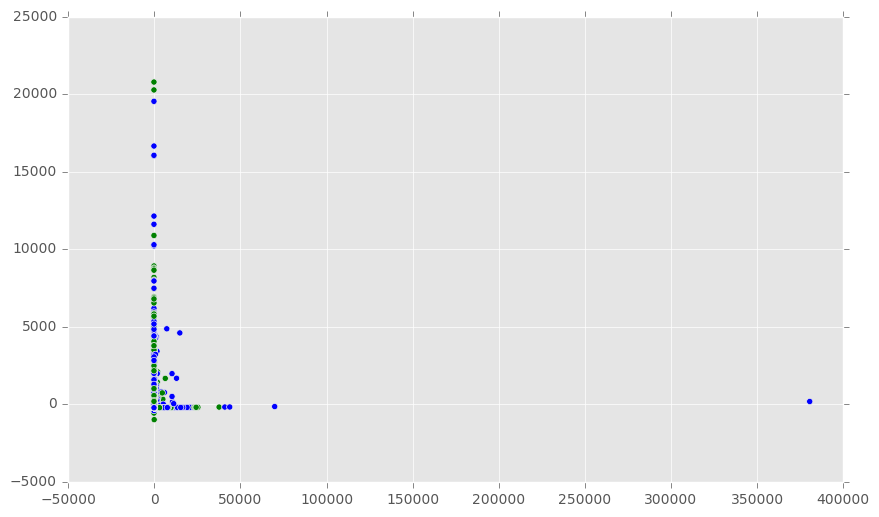

In [121]:
#plot the dim-reduced data set
import matplotlib.pyplot as plt
plt.scatter(PCA_R_past[:, 0], PCA_R_past[:, 1], c = ["B","G"], cmap = plt.cm.Spectral)

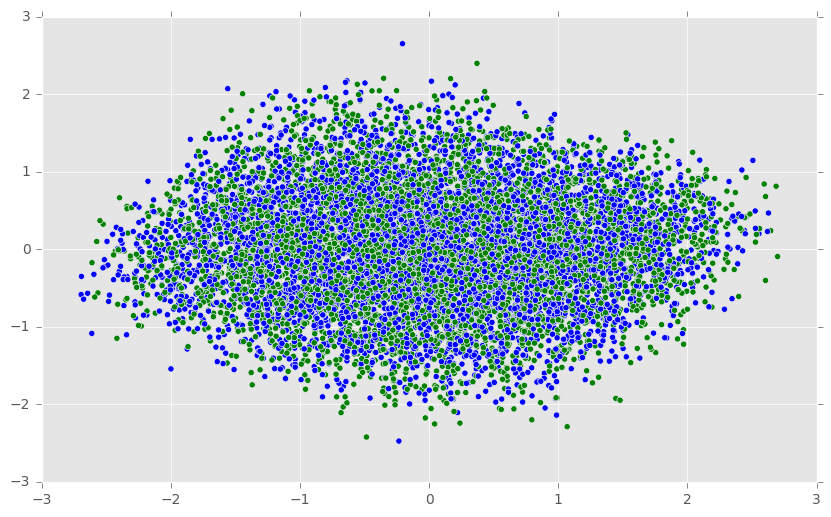

In [122]:
plt.scatter(PCA_Q_past[:, 0], PCA_Q_past[:, 1], c = ["B","G"], cmap = plt.cm.Spectral)

In [123]:
%%time
#dimensionality reduction--LLE
from sklearn import manifold
n_neighbors = 5
n_components = 2
LLE_R_past = manifold.LocallyLinearEmbedding(n_neighbors, n_components,eigen_solver='auto', method = 'standard').fit_transform(sampling_R_past)
LLE_R_cur = manifold.LocallyLinearEmbedding(n_neighbors, n_components,eigen_solver='auto', method = 'standard').fit_transform(sampling_R_cur)

Wall time: 53.3 s


In [124]:
%%time
LLE_Q_past = manifold.LocallyLinearEmbedding(n_neighbors, n_components,eigen_solver='auto', method = 'standard').fit_transform(sampling_Q_past)
LLE_Q_cur = manifold.LocallyLinearEmbedding(n_neighbors, n_components,eigen_solver='auto', method = 'standard').fit_transform(sampling_Q_cur)

Wall time: 2min 58s


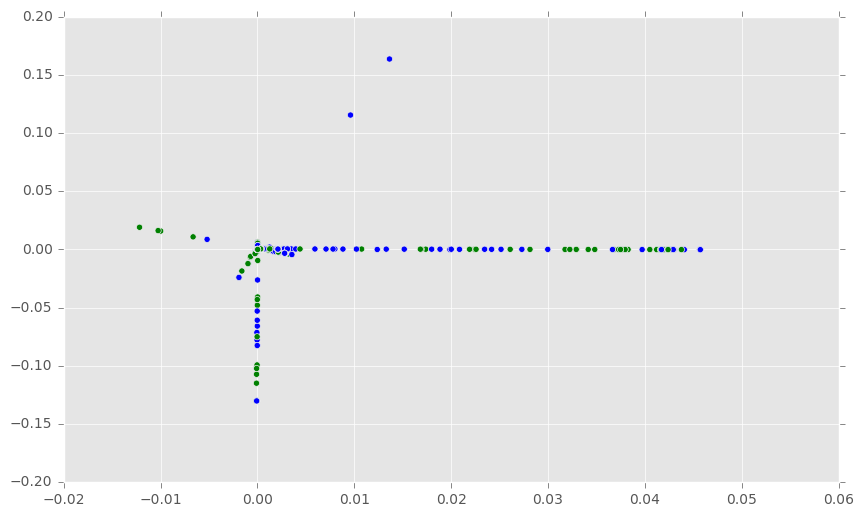

In [125]:
#plot the dim-reduced data set
plt.scatter(LLE_R_cur[:, 0], LLE_R_cur[:, 1], c = ["B","G"], cmap = plt.cm.Spectral)

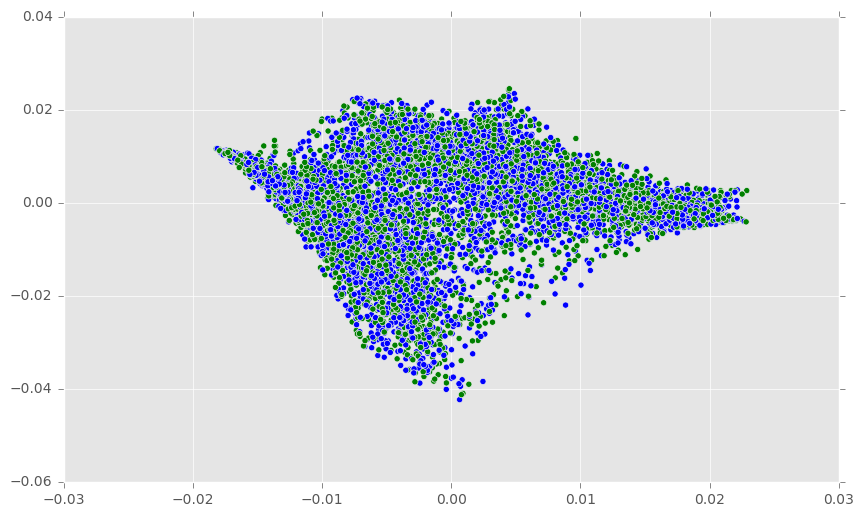

In [126]:
plt.scatter(LLE_Q_cur[:, 0], LLE_Q_cur[:, 1], c = ["B","G"], cmap = plt.cm.Spectral)

In [127]:
%%time
#dimensionality reduction--isomap
ispmap_R_past = manifold.Isomap(n_neighbors, n_components).fit_transform(sampling_R_past)
ispmap_Q_past = manifold.Isomap(n_neighbors, n_components).fit_transform(sampling_Q_past)

Wall time: 2min 14s


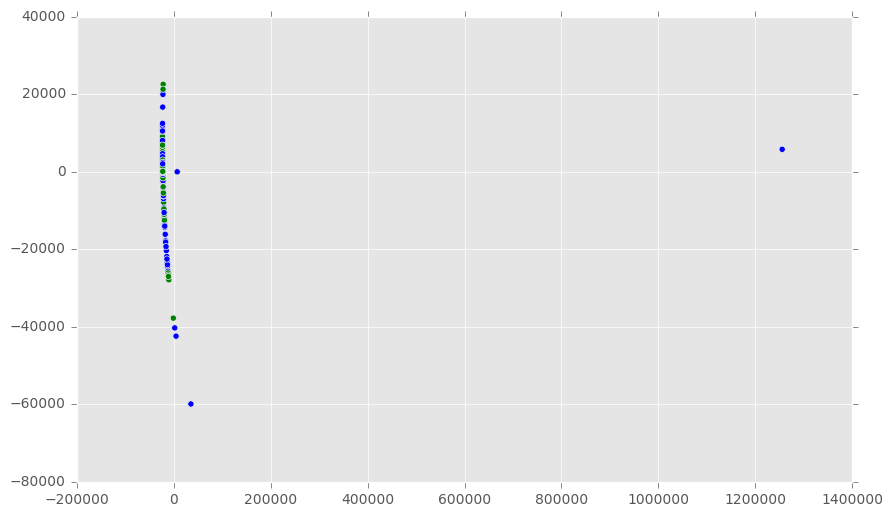

In [128]:
#plot the dim-reduced data set
plt.scatter(ispmap_R_past[:, 0], ispmap_R_past[:, 1], c = ["B","G"], cmap = plt.cm.Spectral)

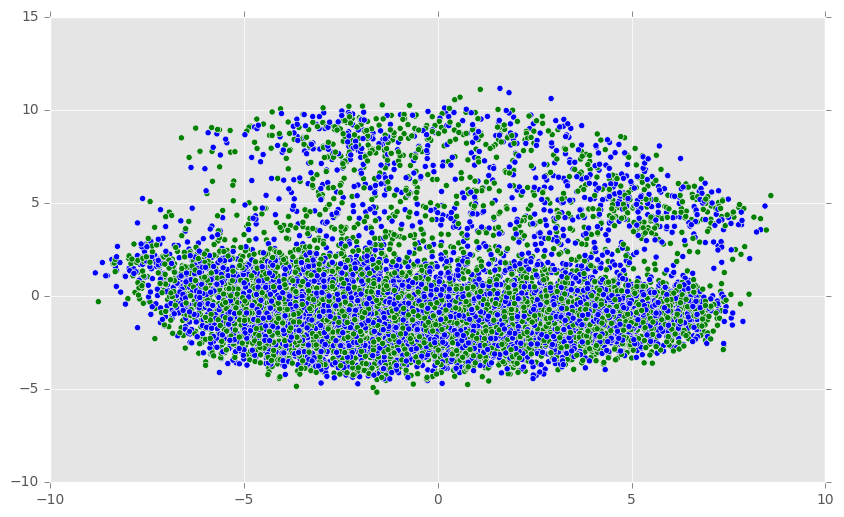

In [129]:
plt.scatter(ispmap_Q_past[:, 0], ispmap_Q_past[:, 1], c = ["B","G"], cmap = plt.cm.Spectral)

In [130]:
#%%time
#dimensionality reduction--MDS--MemoryError
#mds = manifold.MDS(n_neighbors, max_iter = 10, n_init = 1)
#MDS_R = mds.fit_transform(sampling_R)

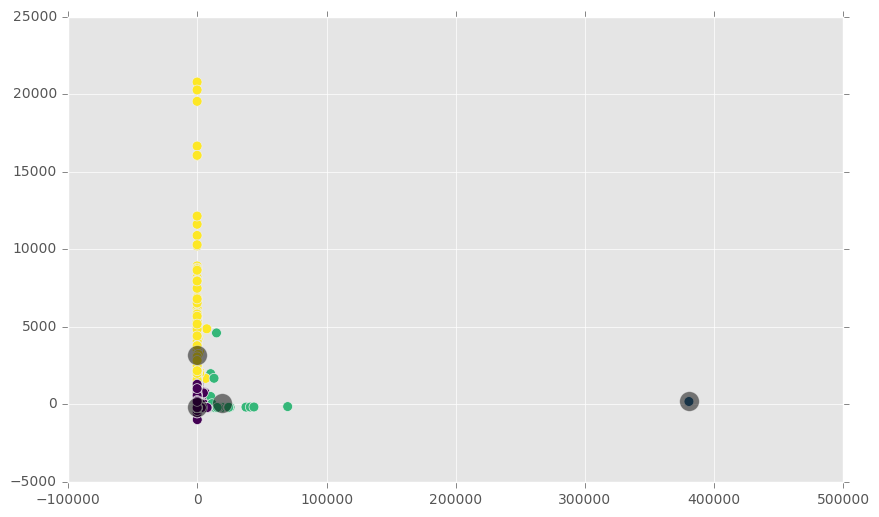

In [131]:
#g. Use k-means or dbscan to cluster the dim-reduced data. Color the 2-d plot with the cluster labels 
#to visualize how the clustering results are distributed.

# Clustering using kmeans--PCA
kmeans = KMeans(n_clusters = 4)
kmeans.fit(PCA_R_past)
y_kmeans = kmeans.predict(PCA_R_past)
plt.scatter(PCA_R_past[:, 0], PCA_R_past[:, 1], c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)

C:\Users\eve2ada\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


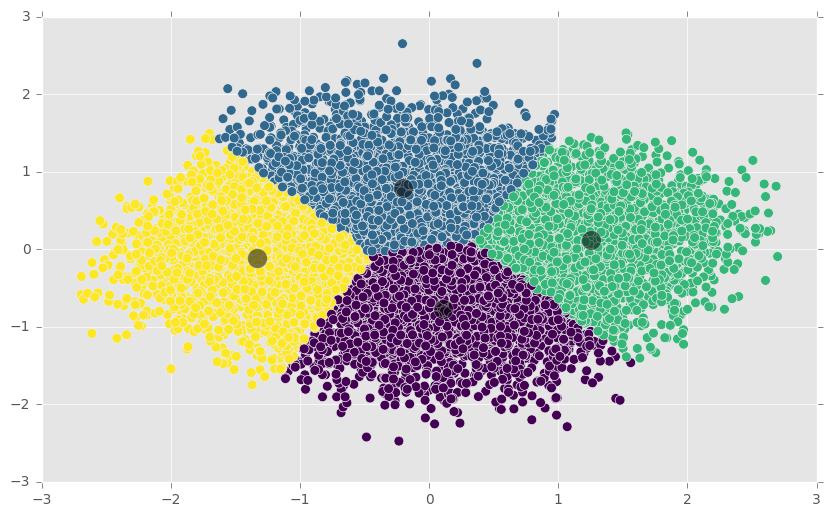

In [132]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(PCA_Q_past)
y_kmeans = kmeans.predict(PCA_Q_past)
plt.scatter(PCA_Q_past[:, 0], PCA_Q_past[:, 1], c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)
plt.legend(label = y_kmeans)
plt.show()

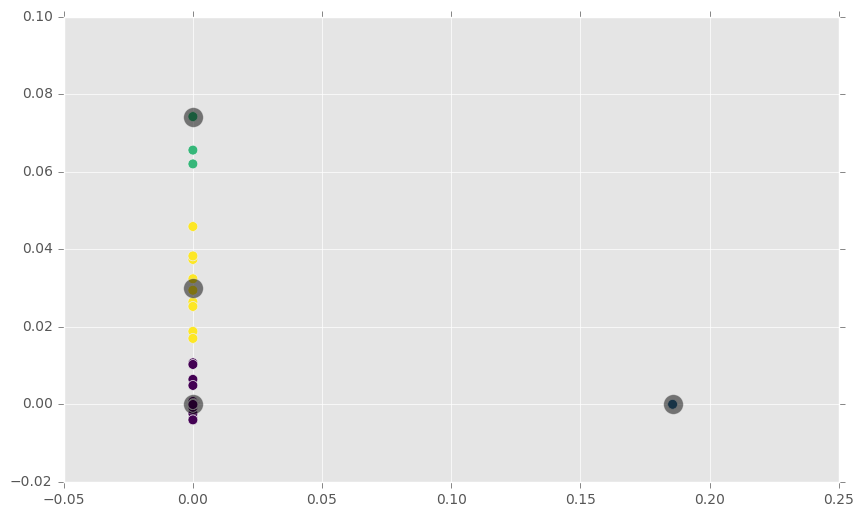

In [133]:
# Clustering using kmeans--LLE
kmeans = KMeans(n_clusters = 4)
kmeans.fit(LLE_R_past)
y_kmeans = kmeans.predict(LLE_R_past)
plt.scatter(LLE_R_past[:, 0], LLE_R_past[:, 1], c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)

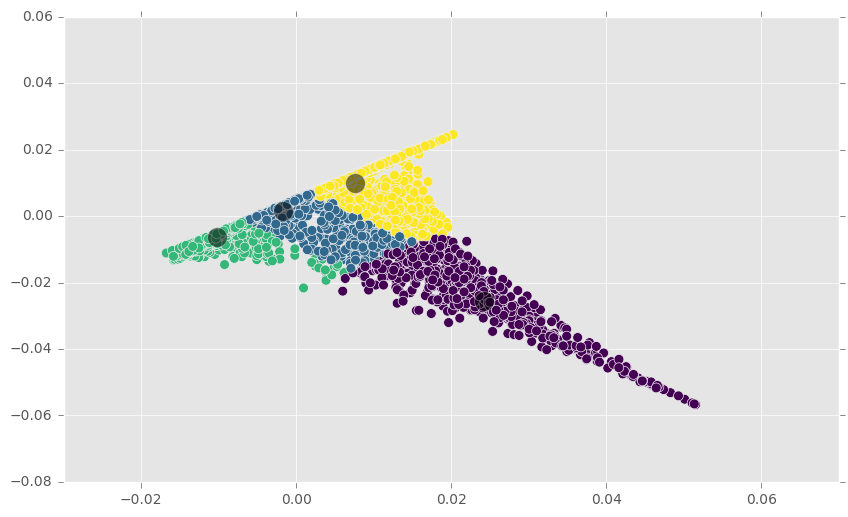

In [134]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(LLE_Q_past)
y_kmeans = kmeans.predict(LLE_Q_past)
plt.scatter(LLE_Q_past[:, 0], LLE_Q_past[:, 1], c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)

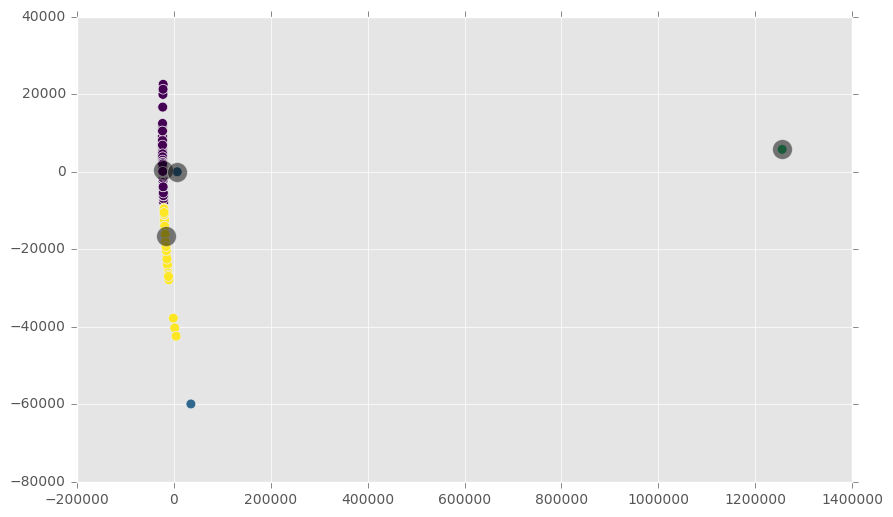

In [135]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(ispmap_R_past)
y_kmeans = kmeans.predict(ispmap_R_past)
plt.scatter(ispmap_R_past[:, 0], ispmap_R_past[:, 1], c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)

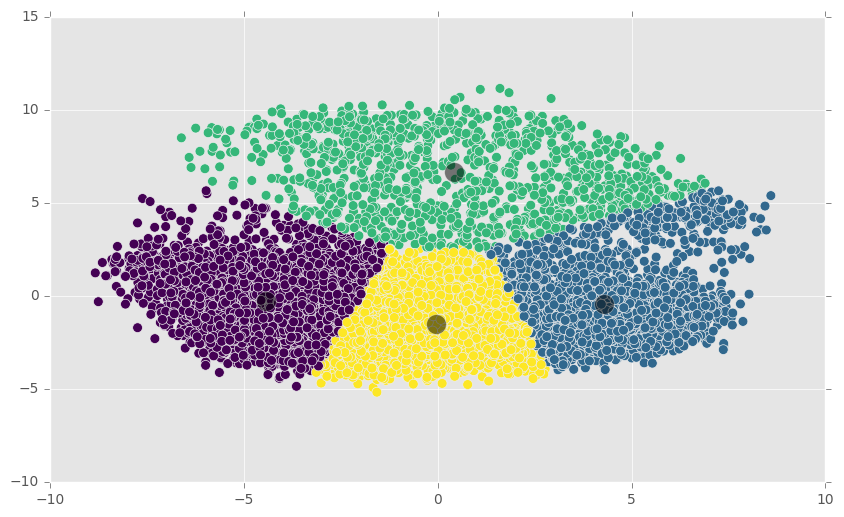

In [136]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(ispmap_Q_past)
y_kmeans = kmeans.predict(ispmap_Q_past)
plt.scatter(ispmap_Q_past[:, 0], ispmap_Q_past[:, 1], c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)

In [137]:
# Work of Week 4
'''
3.       Build a classification model for past loan data to predict their loan status: charge-off or fully-paid

4.       Build a classification model for current loan data to predict a loan would be current or non-current?

5.       For each of the two model building tasks, consider

a.       What features should you use

b.      Do you need to do scaling?

c.       Do you need to do dimensionality reduction?
'''
#check if we could use out_prncp to predict loan status
print df_x_train_past_scaled_R['out_prncp'].value_counts()
print df_x_train_past_scaled_Q['out_prncp'].value_counts()

0.0    578797
Name: out_prncp, dtype: int64
1.000000e-07    578797
Name: out_prncp, dtype: int64


Seems like all past loan's feature "out_prncp" only has one level, therefore we should exclude it from modeling

In [138]:
print df_x_train_cur_scaled_R['out_prncp'].value_counts()
print df_x_train_cur_scaled_Q['out_prncp'].value_counts()

-0.221484    108
-0.213437     99
-0.257962     92
-0.180732     91
-0.198262     88
-0.253688     86
-0.259202     85
-0.466322     83
-0.715542     82
-0.240226     81
-0.445000     81
-0.368890     78
-0.208970     77
-0.250171     77
-0.122673     76
-0.174044     76
-0.217071     74
-0.184330     73
-0.186570     73
-0.331663     72
 0.319017     71
-0.294687     71
-0.166445     70
-0.270215     70
-0.190091     69
-0.225580     69
-0.254887     68
-0.448151     68
-0.161324     67
-0.332791     67
            ... 
-0.052103      1
 0.497107      1
-0.482977      1
-0.472010      1
 0.799233      1
-0.524971      1
 0.524613      1
 0.977172      1
-0.104577      1
-0.175402      1
-0.624636      1
 1.264602      1
 0.508514      1
 0.039223      1
 1.592410      1
-0.459164      1
-0.695817      1
 0.214743      1
-0.212415      1
 1.209884      1
-0.569195      1
 2.405408      1
 1.163693      1
 1.764478      1
 0.049496      1
 1.001901      1
-0.519277      1
 0.345225     

But we can use it in current loan's modeling

In [139]:
print df_x_train_past_scaled_R['out_prncp_inv'].value_counts()
print df_x_train_past_scaled_Q['out_prncp_inv'].value_counts()

0.0    578797
Name: out_prncp_inv, dtype: int64
1.000000e-07    578797
Name: out_prncp_inv, dtype: int64


In [140]:
print df_x_train_cur_scaled_R['out_prncp_inv'].value_counts()
print df_x_train_cur_scaled_Q['out_prncp_inv'].value_counts()

-0.221638    101
-0.213584     97
-0.258143     90
-0.180854     89
-0.198398     88
-0.253866     86
-0.259384     84
-0.716076     82
-0.466665     81
-0.240394     80
-0.445326     78
-0.250346     76
-0.209114     75
-0.174160     74
-0.369157     73
-0.122750     73
-0.186697     73
-0.184454     72
 0.319281     71
-0.270405     70
-0.166556     70
-0.225737     69
-0.217221     69
-0.294897     69
-0.448480     68
-0.181271     67
-0.331901     66
-0.333031     65
-0.234322     65
-0.370217     65
            ... 
-0.397656      1
 0.113665      1
-0.517143      1
 0.268122      1
-0.089832      1
 0.053321      1
-0.279935      1
-0.628856      1
 1.152371      1
 0.228649      1
 0.174485      1
 0.975715      1
-0.160102      1
 0.163439      1
-0.617759      1
 0.197384      1
 0.737693      1
 1.542953      1
-0.289936      1
-0.533813      1
 0.324289      1
-0.430088      1
 2.437049      1
 1.134081      1
-0.449458      1
-0.672311      1
-0.608248      1
 0.737364     

Same to out_prncp_inv

In [141]:
# check if index is unique
print df_train_encoded_past.index.is_unique
print df_x_train_past_scaled_R.index.is_unique

print df_train_encoded_cur.index.is_unique
print df_x_train_cur_scaled_R.index.is_unique

False
True
False
True


In [142]:
# reset index
df_train_encoded_past = df_train_encoded_past.reset_index(drop = True)
df_train_encoded_cur = df_train_encoded_cur.reset_index(drop = True)

In [143]:
# check if "recoveries" could classify response by itself
print df_x_train_past_scaled_R.groupby(df_train_encoded_past['ChargedOff'],as_index = False)['recoveries'].mean()
print df_x_train_cur_scaled_R.groupby(df_train_encoded_cur['Default'],as_index = False)['recoveries'].mean()

    recoveries
0     0.000000
1  1054.449156
   recoveries
0         0.0
1         0.0


In [144]:
# double check
df_x_train_past_scaled_R.loc[df_train_encoded_past.ChargedOff == 0, :]["recoveries"].value_counts()

0.0    459158
Name: recoveries, dtype: int64

It turns out feature "recoveries" could determine loan status of past_loan by itself, but equals to 0 for all current loan, therefore could be excluded from current loan.
But since we would like to predict loan status as early as possbile, we actually need to also exclude this feature from past loan modeling since when we know the value of this feature, it should be too late in the process.

In [161]:
# After WeChat discussion, we use profile, loan and some payment features for classification
# first apply the same manipulations to past_loan (see above parts) like what we did to current loan

# second, select features for past_loan and current_loan separately

# for past loan, only keep profile and loan features, and several payment features
ft_past = ft_profile_past + ft_loan_past + ["last_pymnt_d_pred_1","last_pymnt_amnt"]
# for current loan, keep profile, loan features, and payment features
ft_cur = ft_profile_cur + ft_loan_cur + ft_pay_cur

In [162]:
print ft_cur

['mths_since_last_delinq', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag', 'revol_util_%', 'emp_ti

In [147]:
# remove some features from feature lists
toberemoved = ["out_prncp", "out_prncp_inv"]
ft_past = [x for x in ft_past if x not in toberemoved]
ft_cur.remove("recoveries")

In [148]:
print set(ft_past) - set(ft_cur)
print set(ft_cur) - set(ft_past)

set([])
set(['', 'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee', 'out_prncp', 'total_pymnt', 'out_prncp_inv'])


In [149]:
print len(ft_past)
print len(ft_cur)

75
83


In [150]:
# slice dataframe using feature lists
# divide X_train, y_train,X_test, y_test for modeling
# 4 groups for modeling
'''
# past loan-Roust scaling
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

# past loan-QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

# current loan--Robust scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

#current loan--QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']
'''

"\n# past loan-Roust scaling\nX_train = df_x_train_past_scaled_R[ft_past]\ny_train = df_train_encoded_past['ChargedOff']\nX_test = df_x_test_past_scaled_R[ft_past]\ny_test = df_test_encoded_past['ChargedOff']\n\n# past loan-QuantileTransformer\nX_train = df_x_train_past_scaled_Q[ft_past]\ny_train = df_train_encoded_past['ChargedOff']\nX_test = df_x_test_past_scaled_Q[ft_past]\ny_test = df_test_encoded_past['ChargedOff']\n\n# current loan--Robust scaling\nX_train = df_x_train_cur_scaled_R[ft_cur]\ny_train = df_train_encoded_cur['Default']\nX_test = df_x_test_cur_scaled_R[ft_cur]\ny_test = df_test_encoded_cur['Default']\n\n#current loan--QuantileTransformer\nX_train = df_x_train_cur_scaled_Q[ft_cur]\ny_train = df_train_encoded_cur['Default']\nX_test = df_x_test_cur_scaled_Q[ft_cur]\ny_test = df_test_encoded_cur['Default']\n"

In [151]:
%%time
# build model for past loan
# 1-Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# past loan-Roust scaling
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

pca = PCA(n_components = 20)
lr = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', lr)])
pipe.fit(X_train, y_train)
predicted = pipe.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = pipe.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

C:\Users\eve2ada\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.739033799147
0.705067795818
[[84570  5077]
 [25568  2214]]
             precision    recall  f1-score   support

          0       0.77      0.94      0.85     89647
          1       0.30      0.08      0.13     27782

avg / total       0.66      0.74      0.68    117429

Wall time: 11.3 s


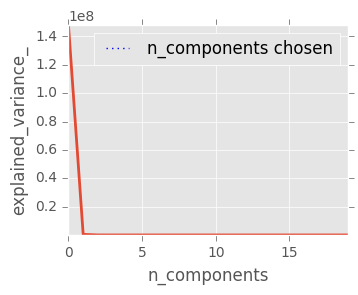

In [335]:
# choose PCA amount of components by grid search CV
'''
from sklearn.model_selection import GridSearchCV
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth = 2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [10, 20, 30]
Cs = np.logspace(1.0,2.0)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components = n_components,
                              logistic__C = Cs))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label = 'n_components chosen')
plt.legend(prop = dict(size=12))
plt.show()
'''

In [205]:
%%time
# past loan-QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

pca = PCA(n_components = 30)
lr = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', lr)])
pipe.fit(X_train, y_train)
predicted = pipe.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = pipe.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.796046973065
0.863042139178
[[88989   658]
 [23292  4490]]
             precision    recall  f1-score   support

          0       0.79      0.99      0.88     89647
          1       0.87      0.16      0.27     27782

avg / total       0.81      0.80      0.74    117429

Wall time: 14.2 s


In [153]:
%%time
# past loan-Roust scaling--logistic regression without PCA
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

#pca = PCA(n_components = 20)
lr = LogisticRegression() 

#pipe = Pipeline([('pca', pca), ('logistic', lr)])
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = lr.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.863142835245
0.938399023103
[[85066  4581]
 [11490 16292]]
             precision    recall  f1-score   support

          0       0.88      0.95      0.91     89647
          1       0.78      0.59      0.67     27782

avg / total       0.86      0.86      0.86    117429

Wall time: 1min 12s


In [154]:
%%time
# past loan-QuantileTransformer--logistic regression without PCA
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

#pca = PCA(n_components = 20)
lr = LogisticRegression() 

#pipe = Pipeline([('pca', pca), ('logistic', lr)])
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = lr.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.859617300667
0.973543681226
[[88296  1351]
 [15134 12648]]
             precision    recall  f1-score   support

          0       0.85      0.98      0.91     89647
          1       0.90      0.46      0.61     27782

avg / total       0.87      0.86      0.84    117429

Wall time: 32.9 s


In [157]:
print list(df_x_train_cur_scaled_R)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dl

In [163]:
%%time
# current loan--Robust scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

pca = PCA(n_components = 20)
lr = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', lr)])
pipe.fit(X_train, y_train)
predicted = pipe.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = pipe.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.935044449913
0.716492265207
[[295566    538]
 [ 20052    830]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97    296104
          1       0.61      0.04      0.07     20882

avg / total       0.91      0.94      0.91    316986

Wall time: 6.7 s


In [164]:
%%time
#current loan--QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

pca = PCA(n_components = 20)
lr = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', lr)])
pipe.fit(X_train, y_train)
predicted = pipe.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = pipe.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.934123273583
0.684099765766
[[296104      0]
 [ 20882      0]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.97    296104
          1       0.00      0.00      0.00     20882

avg / total       0.87      0.93      0.90    316986

Wall time: 4.64 s


C:\Users\eve2ada\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [165]:
%%time
# cur loan-Roust scaling--logistic regression without PCA
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

#pca = PCA(n_components = 20)
lr = LogisticRegression() 

#pipe = Pipeline([('pca', pca), ('logistic', lr)])
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = lr.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.960165433174
0.751332603786
[[295060   1044]
 [ 11583   9299]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98    296104
          1       0.90      0.45      0.60     20882

avg / total       0.96      0.96      0.95    316986

Wall time: 32.2 s


In [166]:
%%time
# cur loan-QuantileTransformer--logistic regression without PCA
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

#pca = PCA(n_components = 20)
lr = LogisticRegression() 

#pipe = Pipeline([('pca', pca), ('logistic', lr)])
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

#model_past_loan_lr = LogisticRegression()
#model_past_loan_lr.fit(df_past_loan_train_x, past_loan_train_y)
#predicted = model_past_loan_lr.predict(df_past_loan_test_x)
probs = lr.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

0.948492993381
0.804806553794
[[294260   1844]
 [ 14483   6399]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97    296104
          1       0.78      0.31      0.44     20882

avg / total       0.94      0.95      0.94    316986

Wall time: 18.9 s


In [167]:
'''
%%time
#Logostical Regression with 10-fold cross validation
c, r = past_loan_train_y.shape
past_loan_train_y = past_loan_train_y.values.reshape(c,)
scores = cross_val_score(LogisticRegression(), df_past_loan_train_x, past_loan_train_y, scoring='accuracy', cv = 10)
print scores
print scores.mean()
'''

"\n%%time\n#Logostical Regression with 10-fold cross validation\nc, r = past_loan_train_y.shape\npast_loan_train_y = past_loan_train_y.values.reshape(c,)\nscores = cross_val_score(LogisticRegression(), df_past_loan_train_x, past_loan_train_y, scoring='accuracy', cv = 10)\nprint scores\nprint scores.mean()\n"

In [170]:
%%time
# 2-Random Forest
# past loan-Robust scaling
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

Wall time: 4min 19s


0.846681824762
0.955345021987
[[88319  1328]
 [16676 11106]]
             precision    recall  f1-score   support

          0       0.84      0.99      0.91     89647
          1       0.89      0.40      0.55     27782

avg / total       0.85      0.85      0.82    117429



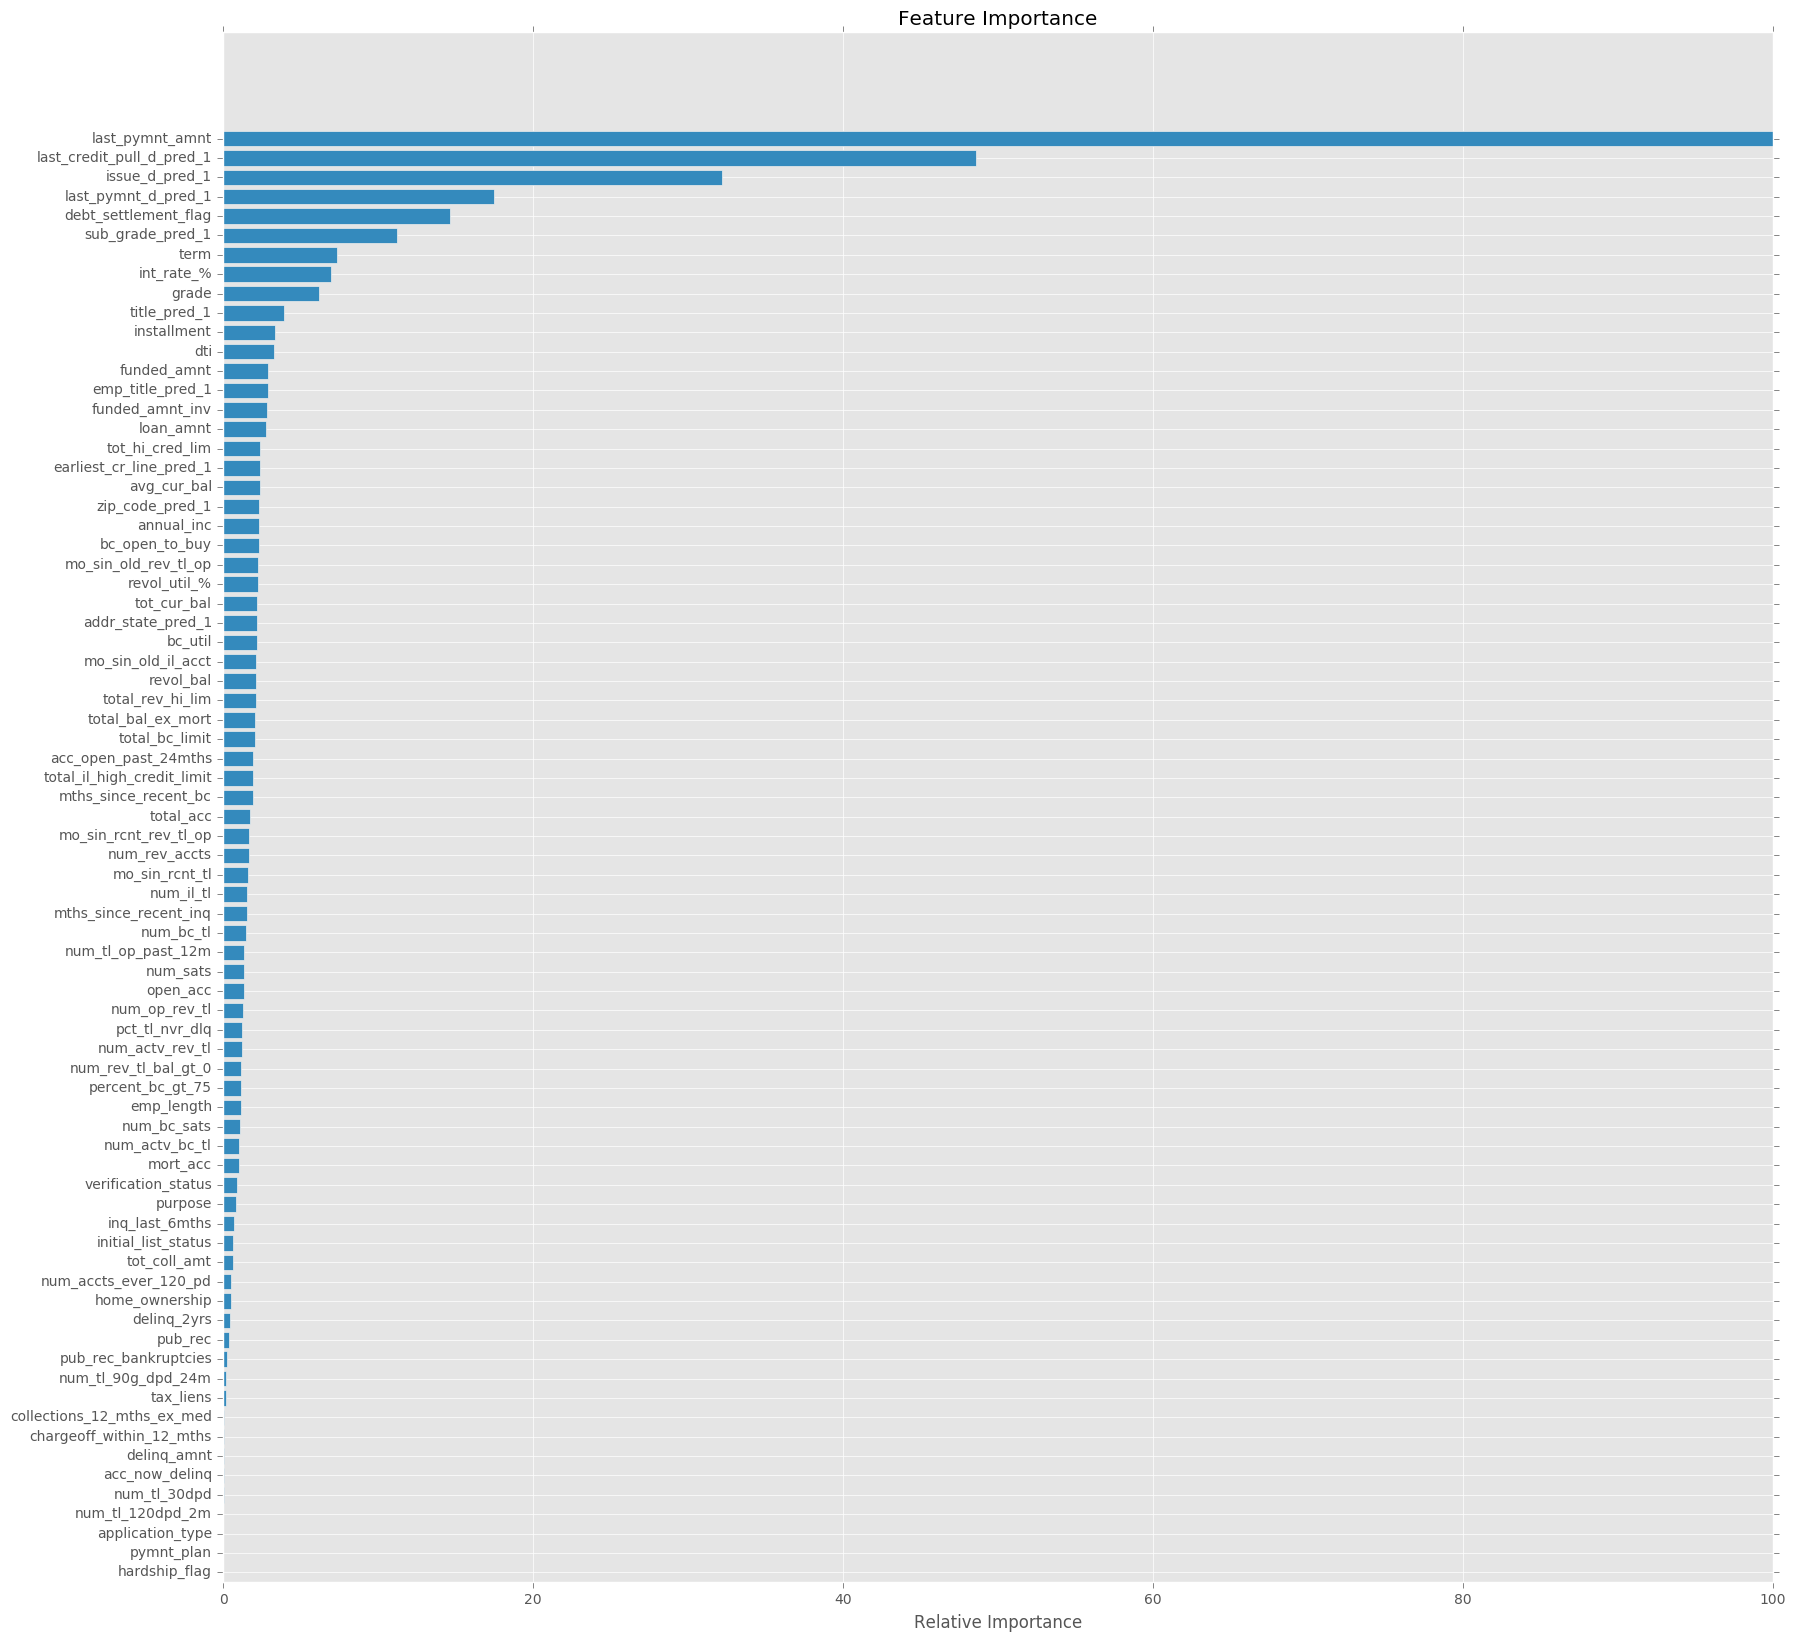

In [172]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2,2)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(X_train.columns.values))
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [178]:
%%time
# Round 2: only use 9 important features for Random Frorest model--past loan--Robust Scaling
X_train = df_x_train_past_scaled_R[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag','sub_grade_pred_1','term','int_rate_%','grade']]
X_test = df_x_test_past_scaled_R[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag','sub_grade_pred_1','term','int_rate_%','grade']]

y_train = df_train_encoded_past['ChargedOff']
y_test = df_test_encoded_past['ChargedOff']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.828279215526
0.919794721259
[[86771  2876]
 [17289 10493]]
             precision    recall  f1-score   support

          0       0.83      0.97      0.90     89647
          1       0.78      0.38      0.51     27782

avg / total       0.82      0.83      0.80    117429

Wall time: 1min 19s


In [179]:
%%time
# Round 3: only use 6 important features for Random Frorest model--past loan--Robust Scaling
X_train = df_x_train_past_scaled_R[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag','sub_grade_pred_1']]
X_test = df_x_test_past_scaled_R[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag','sub_grade_pred_1']]

y_train = df_train_encoded_past['ChargedOff']
y_test = df_test_encoded_past['ChargedOff']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.796941130385
0.901351193064
[[87525  2122]
 [21723  6059]]
             precision    recall  f1-score   support

          0       0.80      0.98      0.88     89647
          1       0.74      0.22      0.34     27782

avg / total       0.79      0.80      0.75    117429

Wall time: 1min 7s


In [174]:
%%time
# Random Forest--past loan-QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

Wall time: 4min 23s


0.869274199729
0.970966654527
[[88889   758]
 [14593 13189]]
             precision    recall  f1-score   support

          0       0.86      0.99      0.92     89647
          1       0.95      0.47      0.63     27782

avg / total       0.88      0.87      0.85    117429



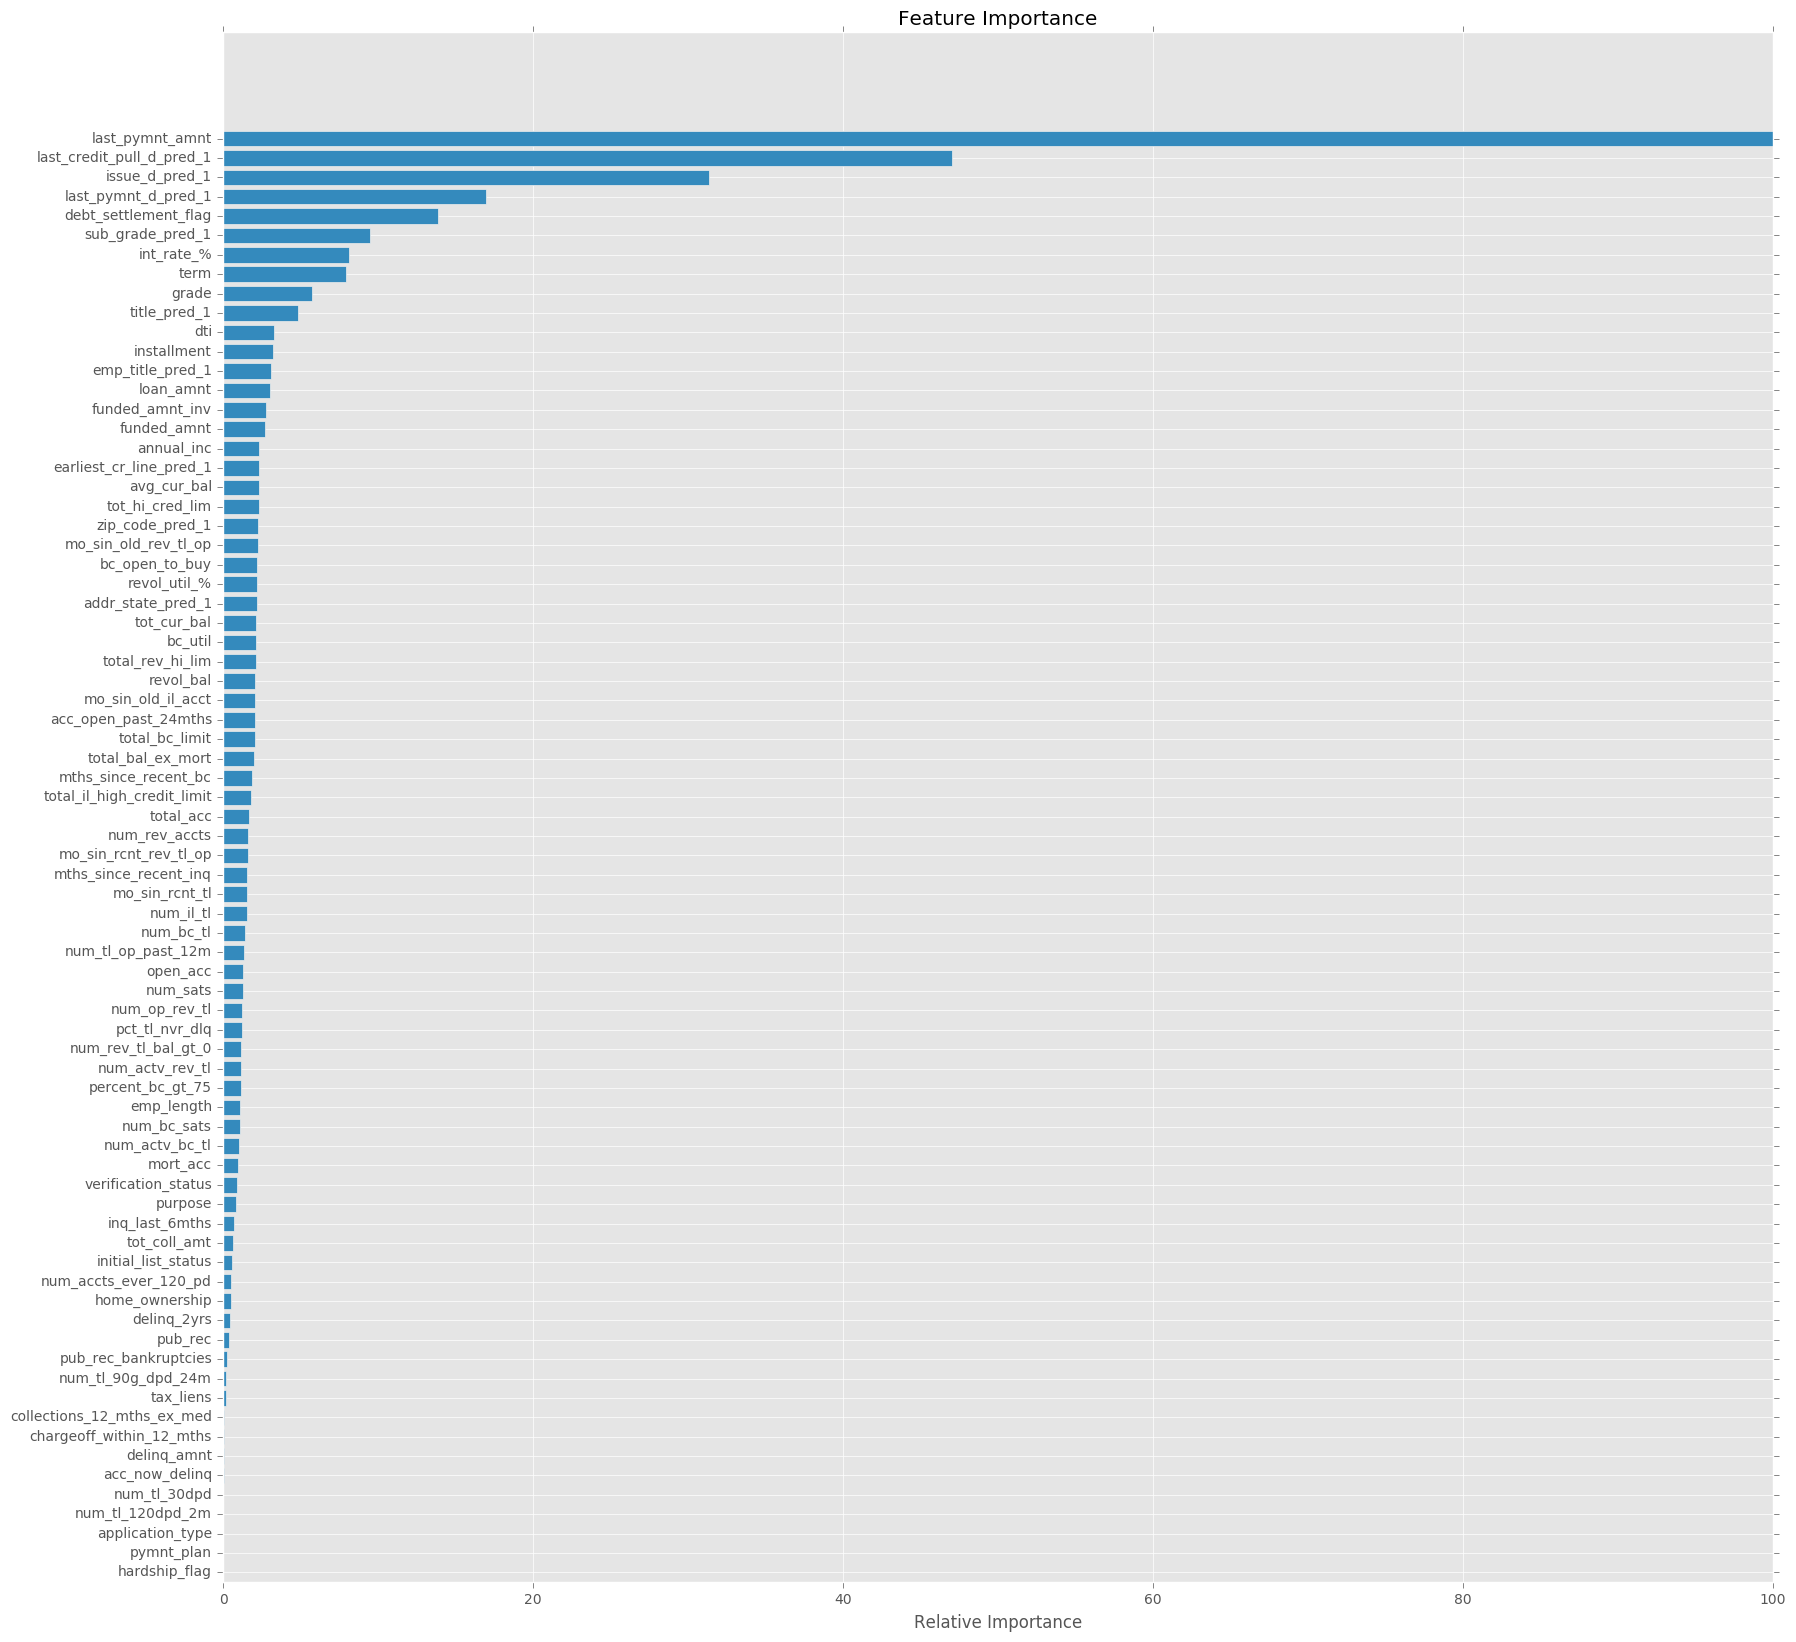

In [175]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2,2)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(X_train.columns.values))
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [180]:
%%time
# Round 2: only use 10 important features for Random Frorest model--past loan--QuantileTransformer
X_train = df_x_train_past_scaled_Q[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag','sub_grade_pred_1','term','int_rate_%','grade','title_pred_1']]
X_test = df_x_test_past_scaled_Q[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag','sub_grade_pred_1','term','int_rate_%','grade','title_pred_1']]

y_train = df_train_encoded_past['ChargedOff']
y_test = df_test_encoded_past['ChargedOff']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.857283975849
0.945104963185
[[87696  1951]
 [14808 12974]]
             precision    recall  f1-score   support

          0       0.86      0.98      0.91     89647
          1       0.87      0.47      0.61     27782

avg / total       0.86      0.86      0.84    117429

Wall time: 1min 27s


In [181]:
%%time
# Round 3: only use 5 important features for Random Frorest model--past loan--QuantileTransformer
X_train = df_x_train_past_scaled_Q[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag']]
X_test = df_x_test_past_scaled_Q[['last_pymnt_amnt', 'last_credit_pull_d_pred_1', 'issue_d_pred_1', 'last_pymnt_d_pred_1','debt_settlement_flag']]

y_train = df_train_encoded_past['ChargedOff']
y_test = df_test_encoded_past['ChargedOff']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.827333963501
0.901672348282
[[85598  4049]
 [16227 11555]]
             precision    recall  f1-score   support

          0       0.84      0.95      0.89     89647
          1       0.74      0.42      0.53     27782

avg / total       0.82      0.83      0.81    117429

Wall time: 1min 7s


In [191]:
%%time
# Past loan--GBM
from sklearn.ensemble import GradientBoostingClassifier

# past loan-Robust scaling
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

model_GBM = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1)
model_GBM.fit(X_train, y_train)
results = model_GBM.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_GBM.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.904938303145
0.964246658843
[[84357  5290]
 [ 5873 21909]]
             precision    recall  f1-score   support

          0       0.93      0.94      0.94     89647
          1       0.81      0.79      0.80     27782

avg / total       0.90      0.90      0.90    117429

Wall time: 1min 22s


In [192]:
%%time
# past loan-QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

model_GBM = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1)
model_GBM.fit(X_train, y_train)
results = model_GBM.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_GBM.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.858586890802
0.961681299539
[[88316  1331]
 [15275 12507]]
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     89647
          1       0.90      0.45      0.60     27782

avg / total       0.86      0.86      0.84    117429

Wall time: 1min 21s


In [206]:
'''
%%time
# LinearSVC--past loan--Robust Scaling
from sklearn.svm import LinearSVC
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

clf = LinearSVC(random_state = 0)
clf.fit(X_train, y_train)

print clf.score(X_test,y_test)
'''

0.895758287987
Wall time: 3min 59s


In [209]:
%%time
from sklearn import linear_model
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

clf = linear_model.SGDClassifier(loss = 'modified_huber')
clf.fit(X_train, y_train)
results = clf.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = clf.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.898185286428
0.865842590572
Wall time: 1.33 s


In [210]:
%%time
# SGDClassifier--past loan--QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

clf = linear_model.SGDClassifier(loss = 'modified_huber')
clf.fit(X_train, y_train)
results = clf.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = clf.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.829301109607
0.889516934223
Wall time: 1.47 s


In [196]:
'''
%%time
# LinearSVC--past loan--QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

clf = LinearSVC(random_state = 0)
clf.fit(X_train, y_train)

print clf.score(X_test,y_test)
'''

0.859549174395
Wall time: 2min 11s


In [199]:
%%time
# KneighborClassifier--past loan--Robust Scaling
from sklearn.neighbors import KNeighborsClassifier
X_train = df_x_train_past_scaled_R[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_R[ft_past]
y_test = df_test_encoded_past['ChargedOff']

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train) 

print neigh.score(X_test,y_test)

0.773582334858
Wall time: 3h 7min 22s


In [202]:
%%time
# KneighborClassifier--past loan--QuantileTransformer
X_train = df_x_train_past_scaled_Q[ft_past]
y_train = df_train_encoded_past['ChargedOff']
X_test = df_x_test_past_scaled_Q[ft_past]
y_test = df_test_encoded_past['ChargedOff']

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train) 

print neigh.score(X_test,y_test)

0.828781646782
Wall time: 4h 12min 6s


0.984453572082
0.944543024894
[[295132    972]
 [  3956  16926]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    296104
          1       0.95      0.81      0.87     20882

avg / total       0.98      0.98      0.98    316986



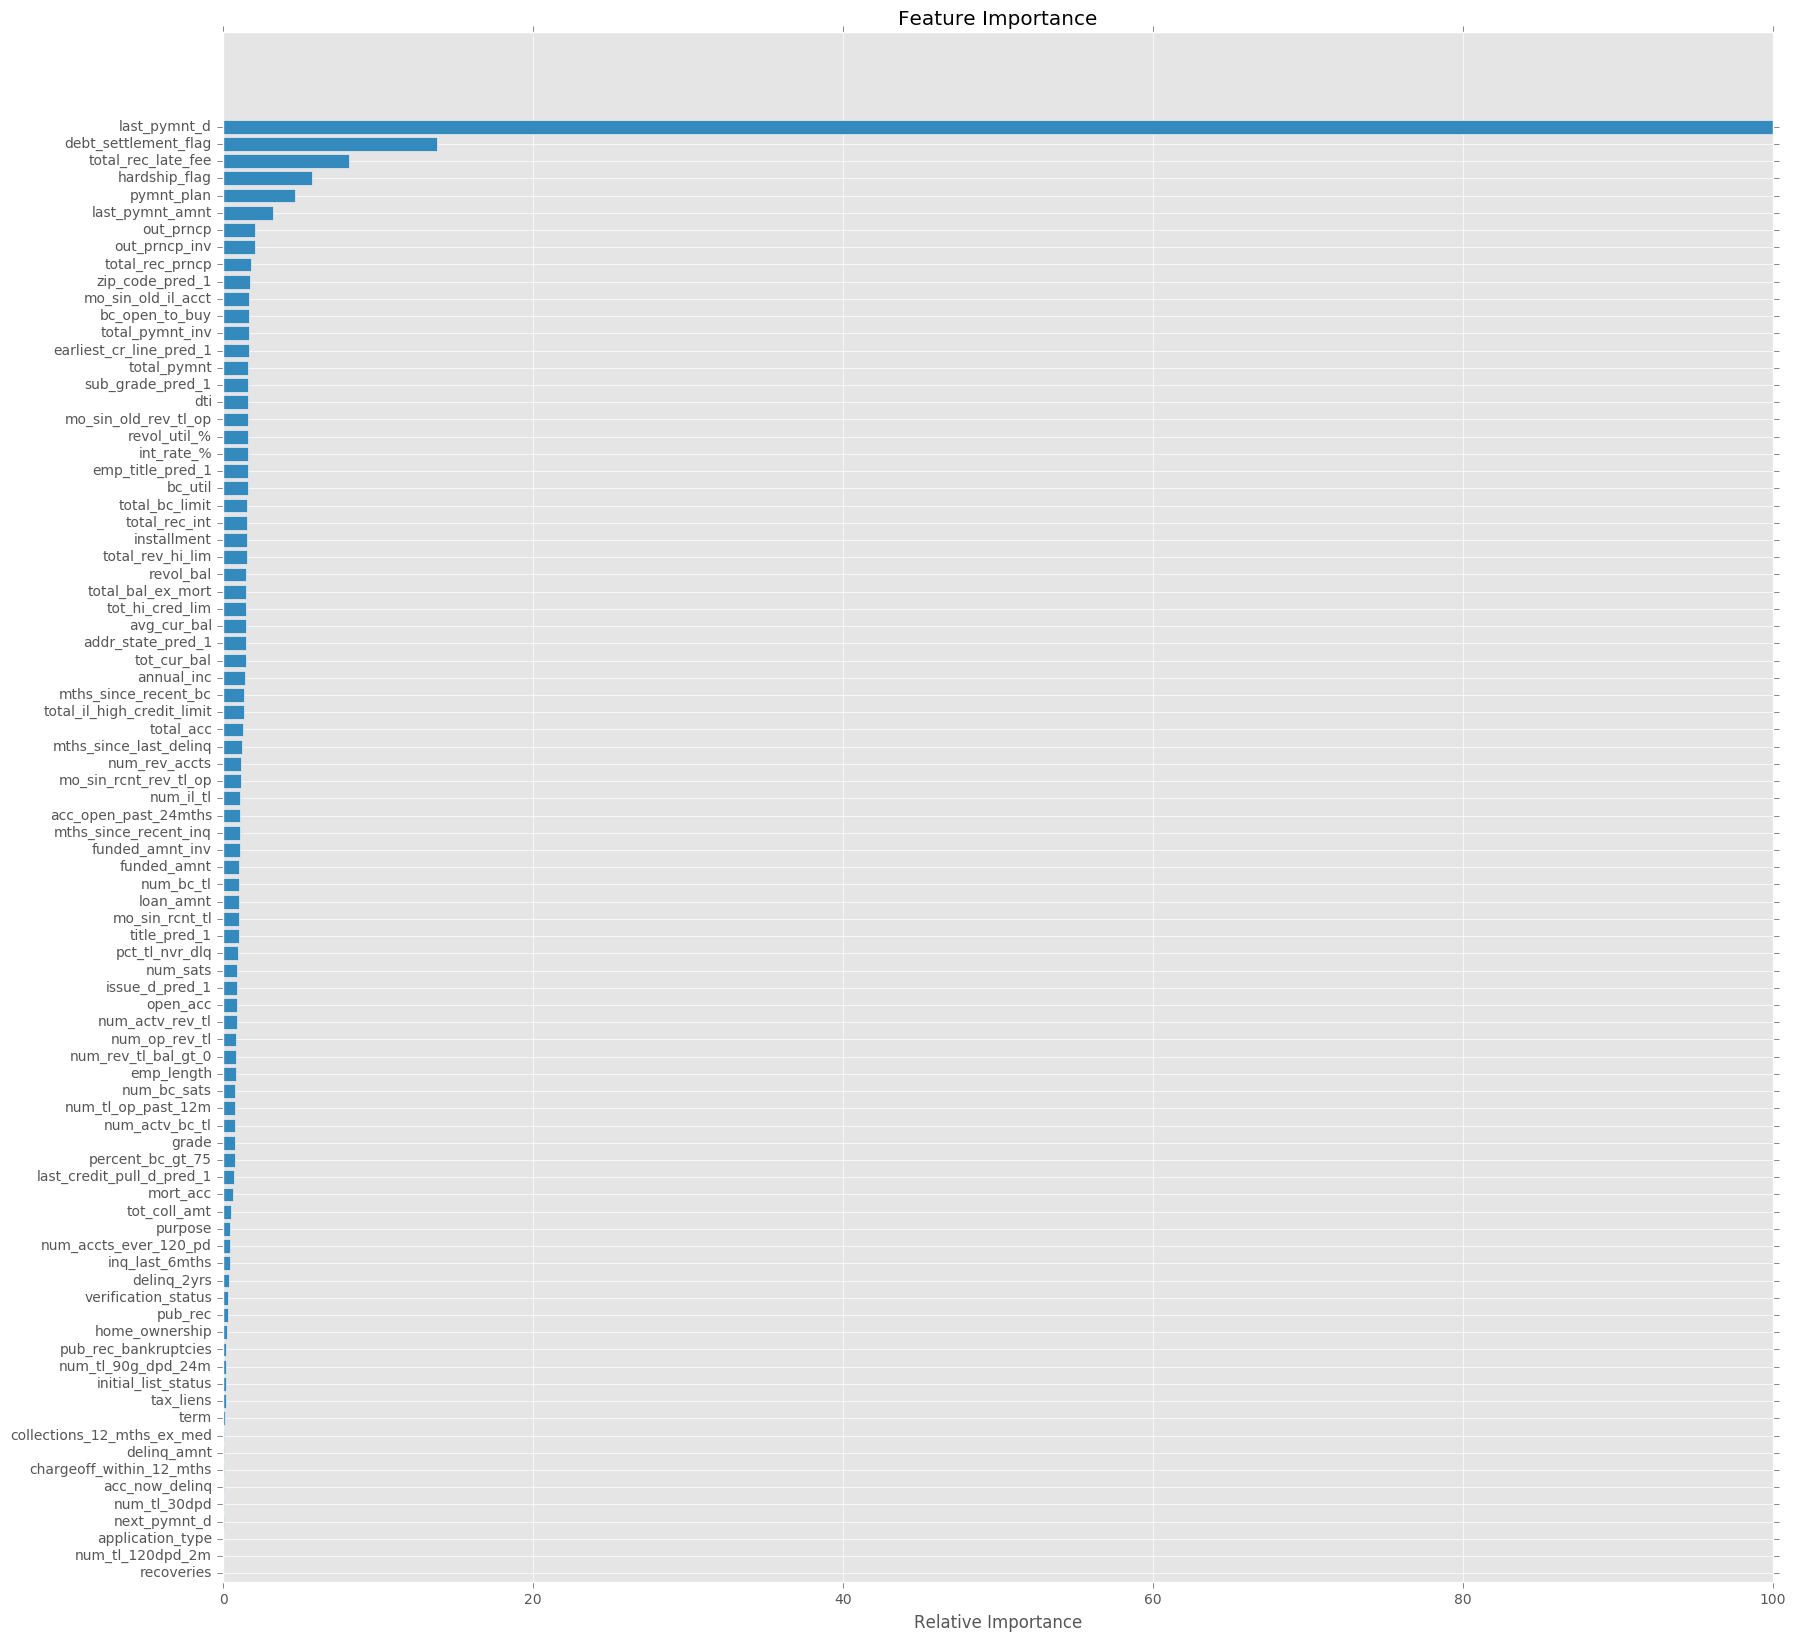

Wall time: 3min 8s


In [176]:
%%time
# 2-Random Forest
# current loan-Robust scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2,2)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(X_train.columns.values))
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [183]:
print ft_cur
tmp = ft_cur
tmp.remove('last_pymnt_d')
print tmp

['mths_since_last_delinq', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag', 'revol_util_%', 'emp_ti

0.948202759743
0.78161110464
[[294930   1174]
 [ 15245   5637]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    296104
          1       0.83      0.27      0.41     20882

avg / total       0.94      0.95      0.94    316986



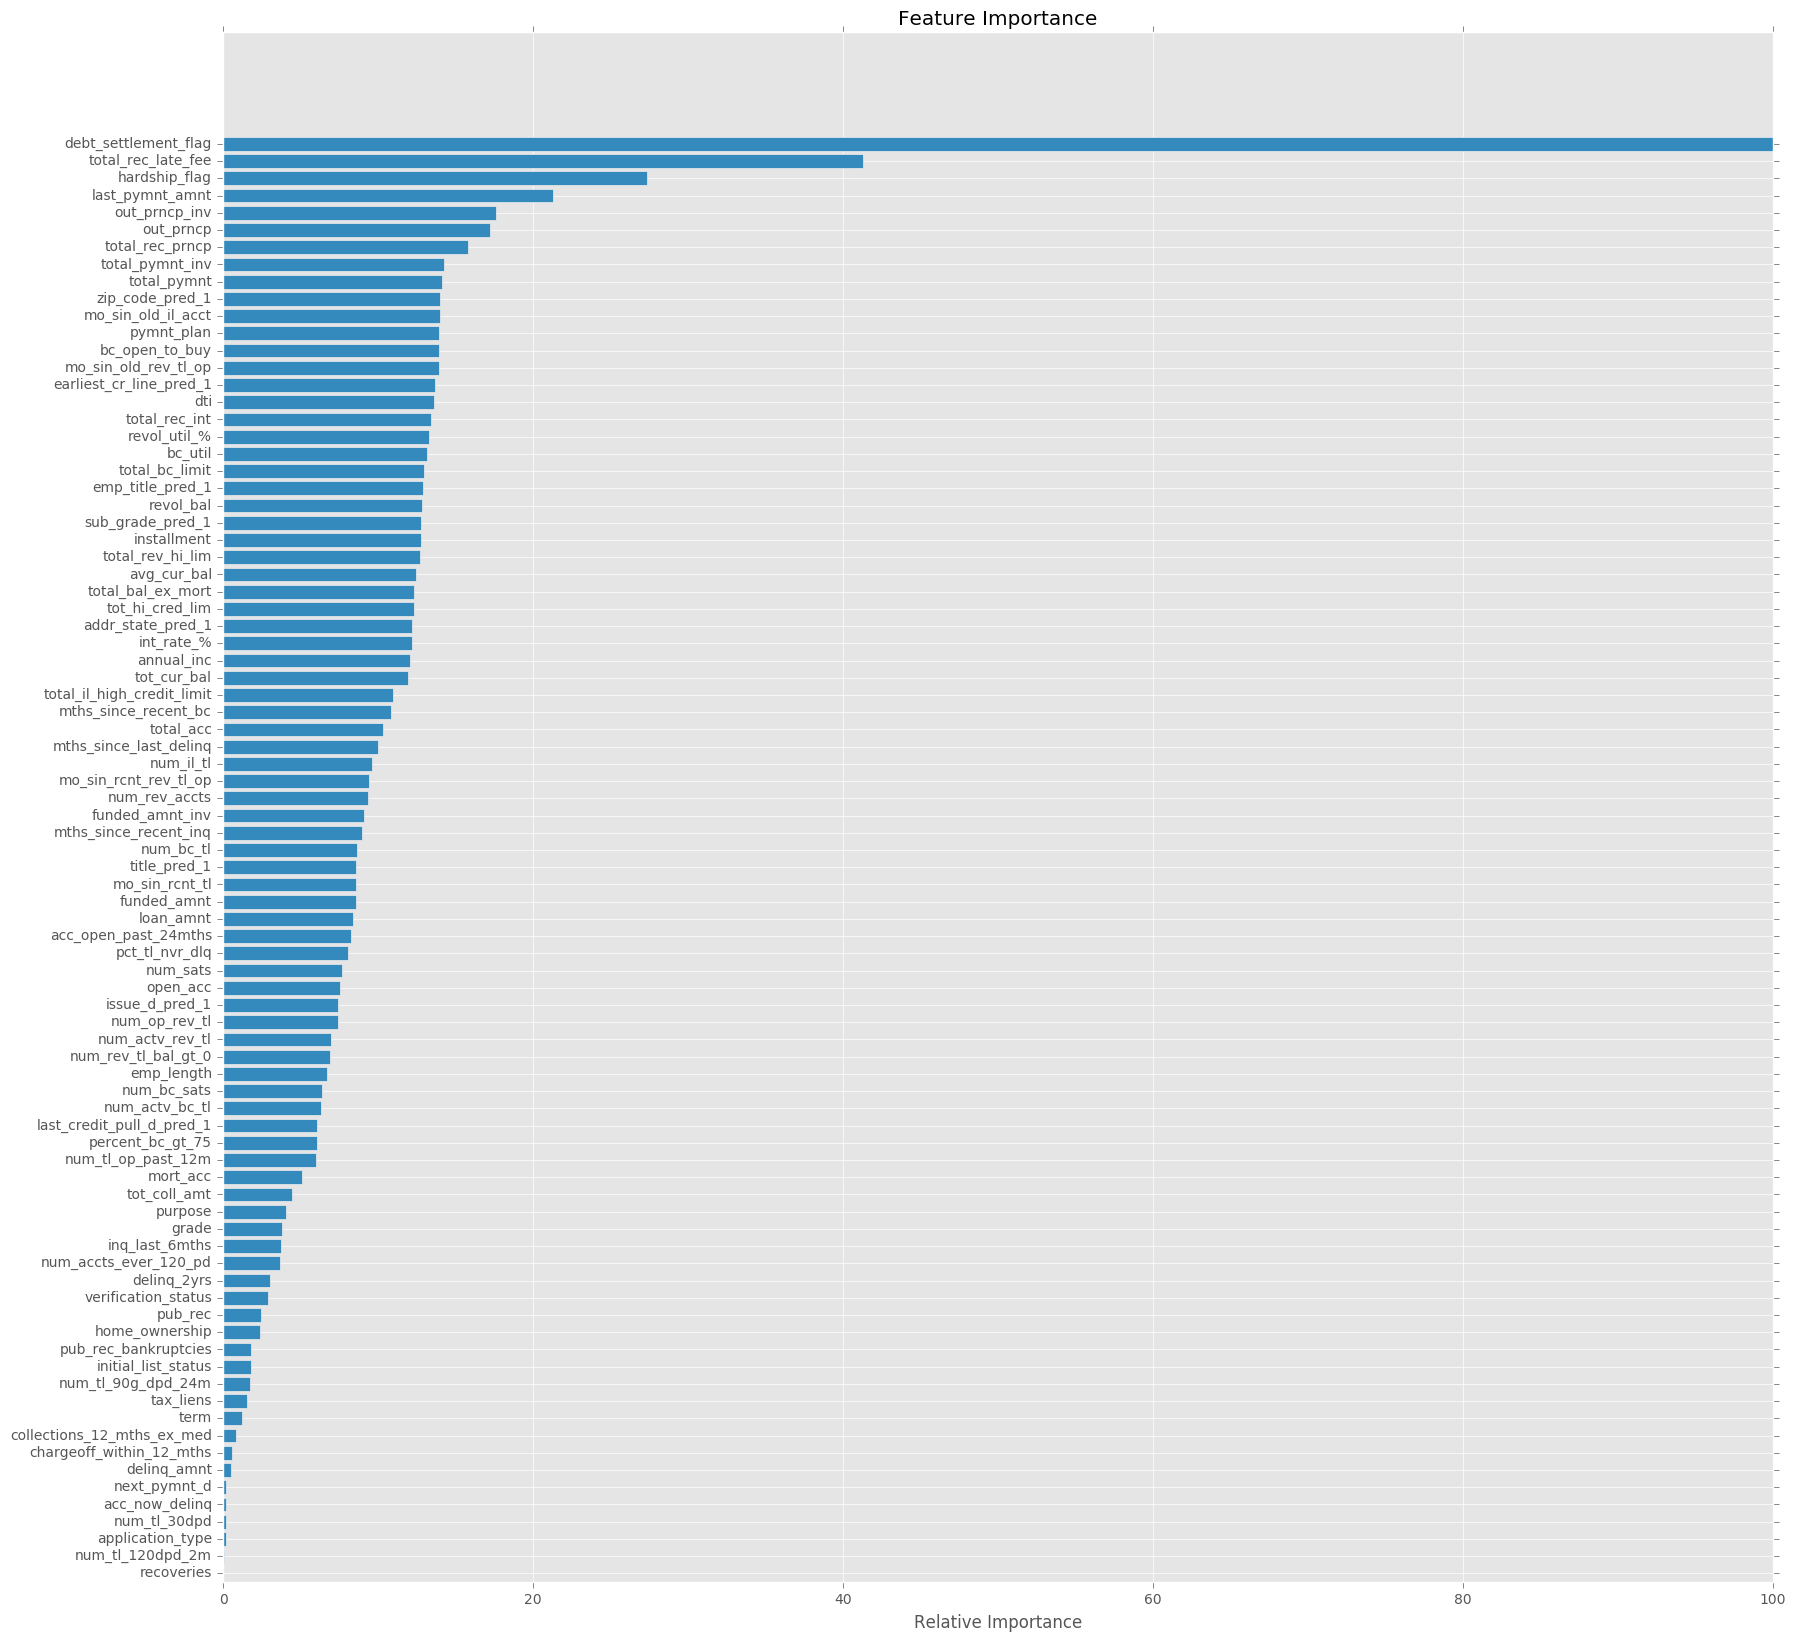

Wall time: 3min 15s


In [185]:
%%time
# 2-Random Forest
# Round 2: current loan-Robust scaling excluding last_pymnt_d
X_train = df_x_train_cur_scaled_R[tmp]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[tmp]
y_test = df_test_encoded_cur['Default']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2,2)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(X_train.columns.values))
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [187]:
%%time
# 2-Random Forest
# Round 3: current loan-Robust scaling only using several important features
X_train = df_x_train_cur_scaled_R[['debt_settlement_flag', 'total_rec_late_fee', 'hardship_flag', 'last_pymnt_amnt','out_prncp_inv', 'out_prncp', 'total_rec_prncp']]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[['debt_settlement_flag', 'total_rec_late_fee', 'hardship_flag', 'last_pymnt_amnt','out_prncp_inv', 'out_prncp', 'total_rec_prncp']]
y_test = df_test_encoded_cur['Default']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.915418977494
0.73426237291
[[282630  13474]
 [ 13337   7545]]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95    296104
          1       0.36      0.36      0.36     20882

avg / total       0.92      0.92      0.92    316986

Wall time: 1min 17s


0.984333692971
0.944629451537
[[295099   1005]
 [  3961  16921]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    296104
          1       0.94      0.81      0.87     20882

avg / total       0.98      0.98      0.98    316986



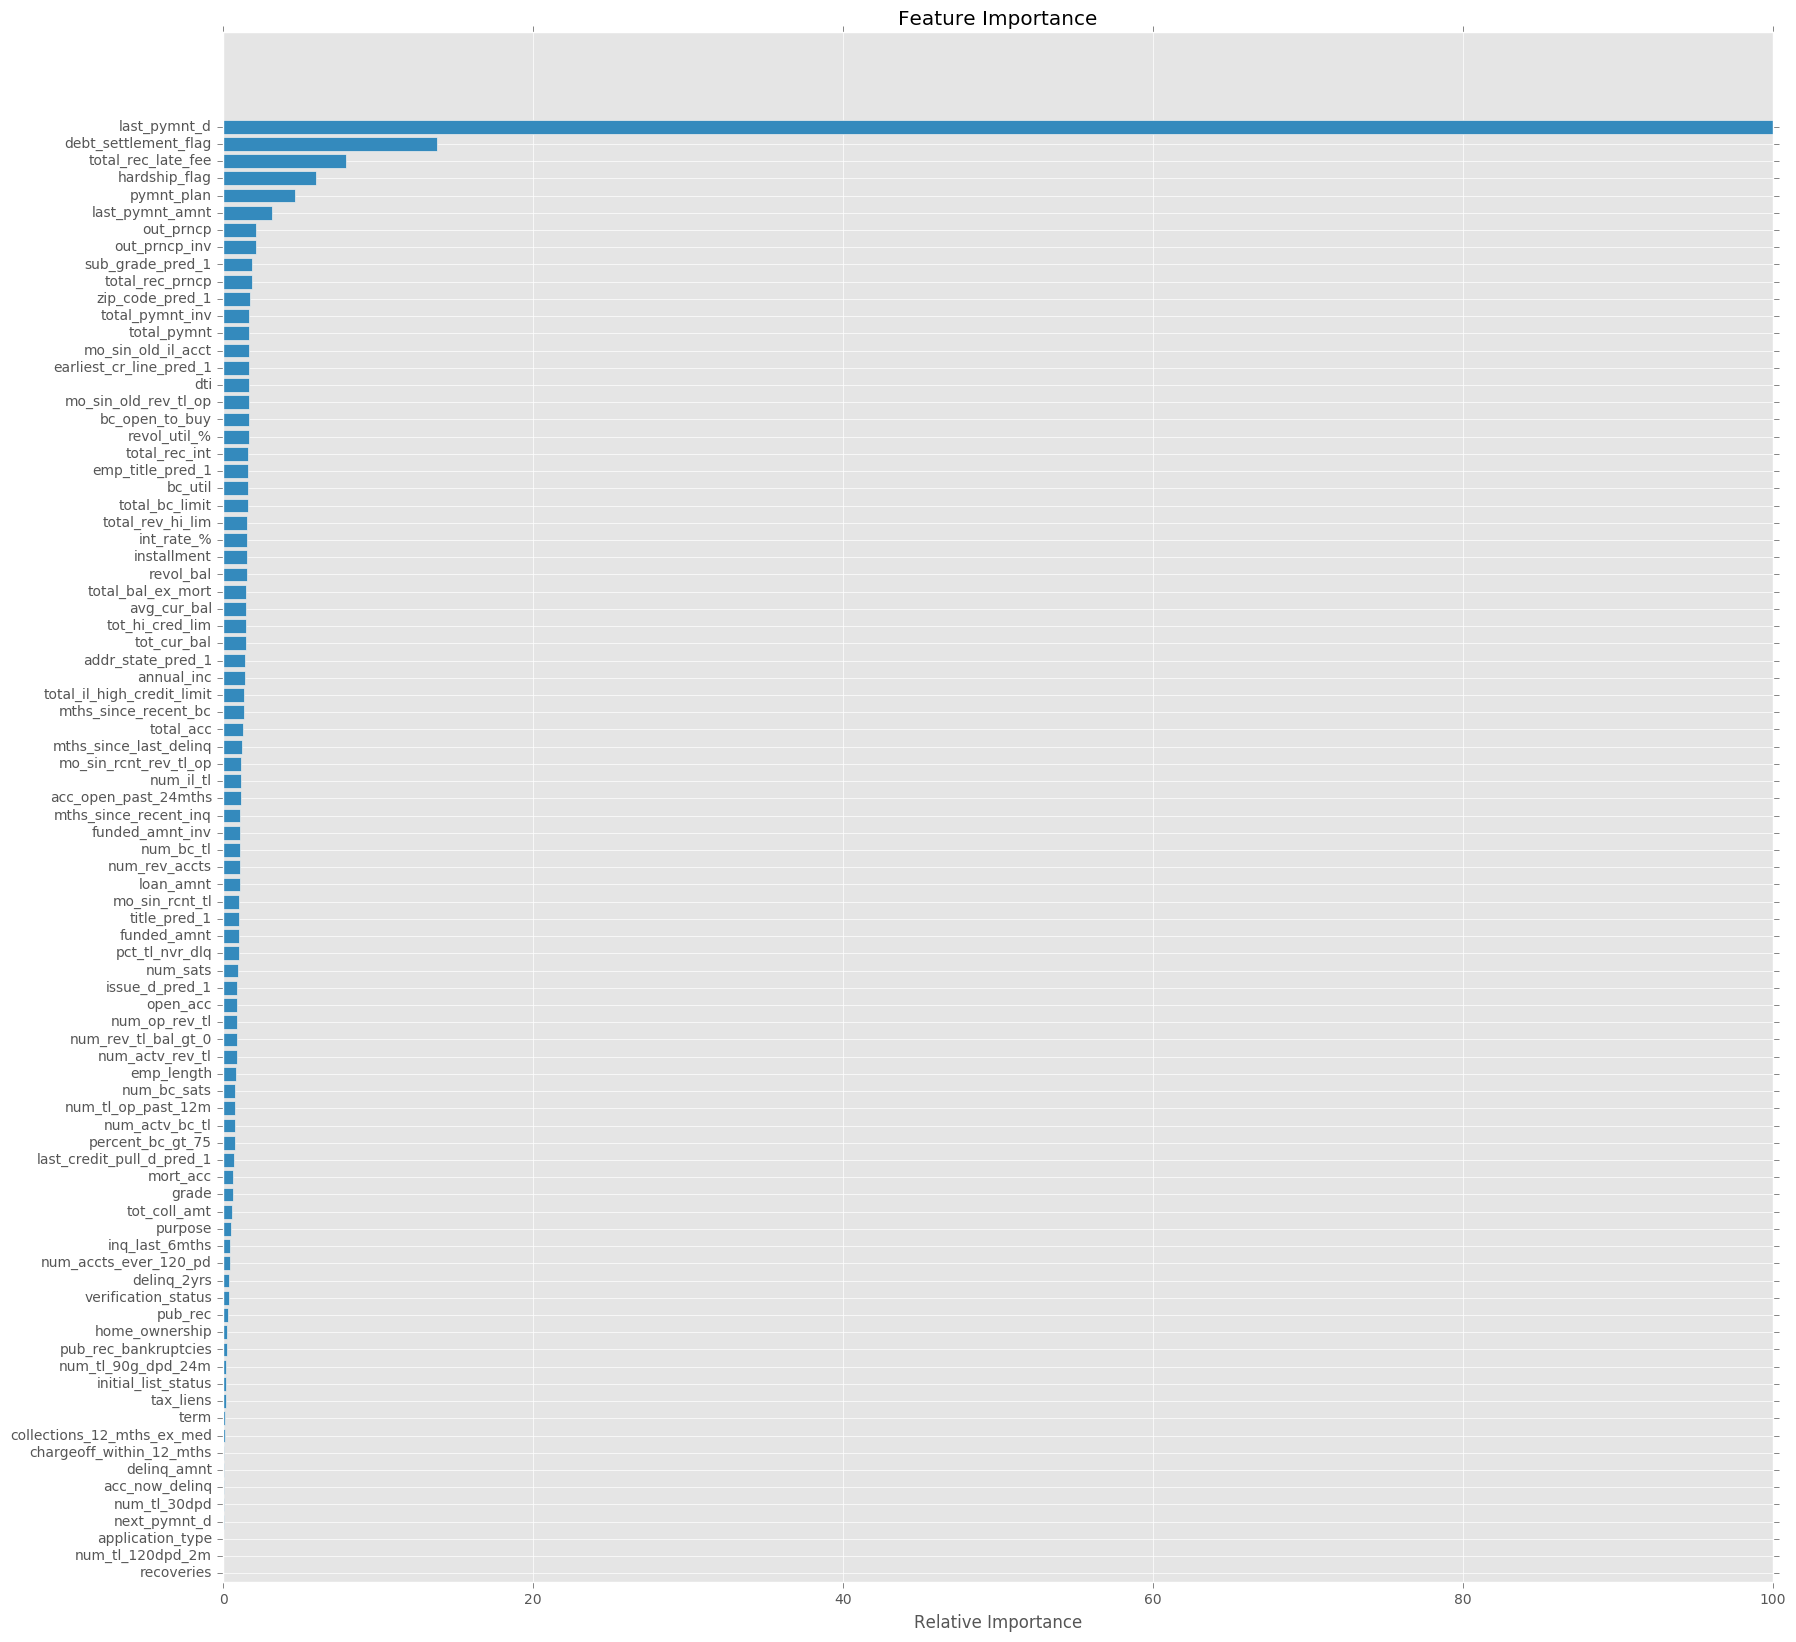

Wall time: 3min


In [177]:
%%time
# 2-Random Forest
# current loan-QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2,2)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(X_train.columns.values))
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

0.948511921662
0.780519010216
[[294894   1210]
 [ 15111   5771]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    296104
          1       0.83      0.28      0.41     20882

avg / total       0.94      0.95      0.94    316986



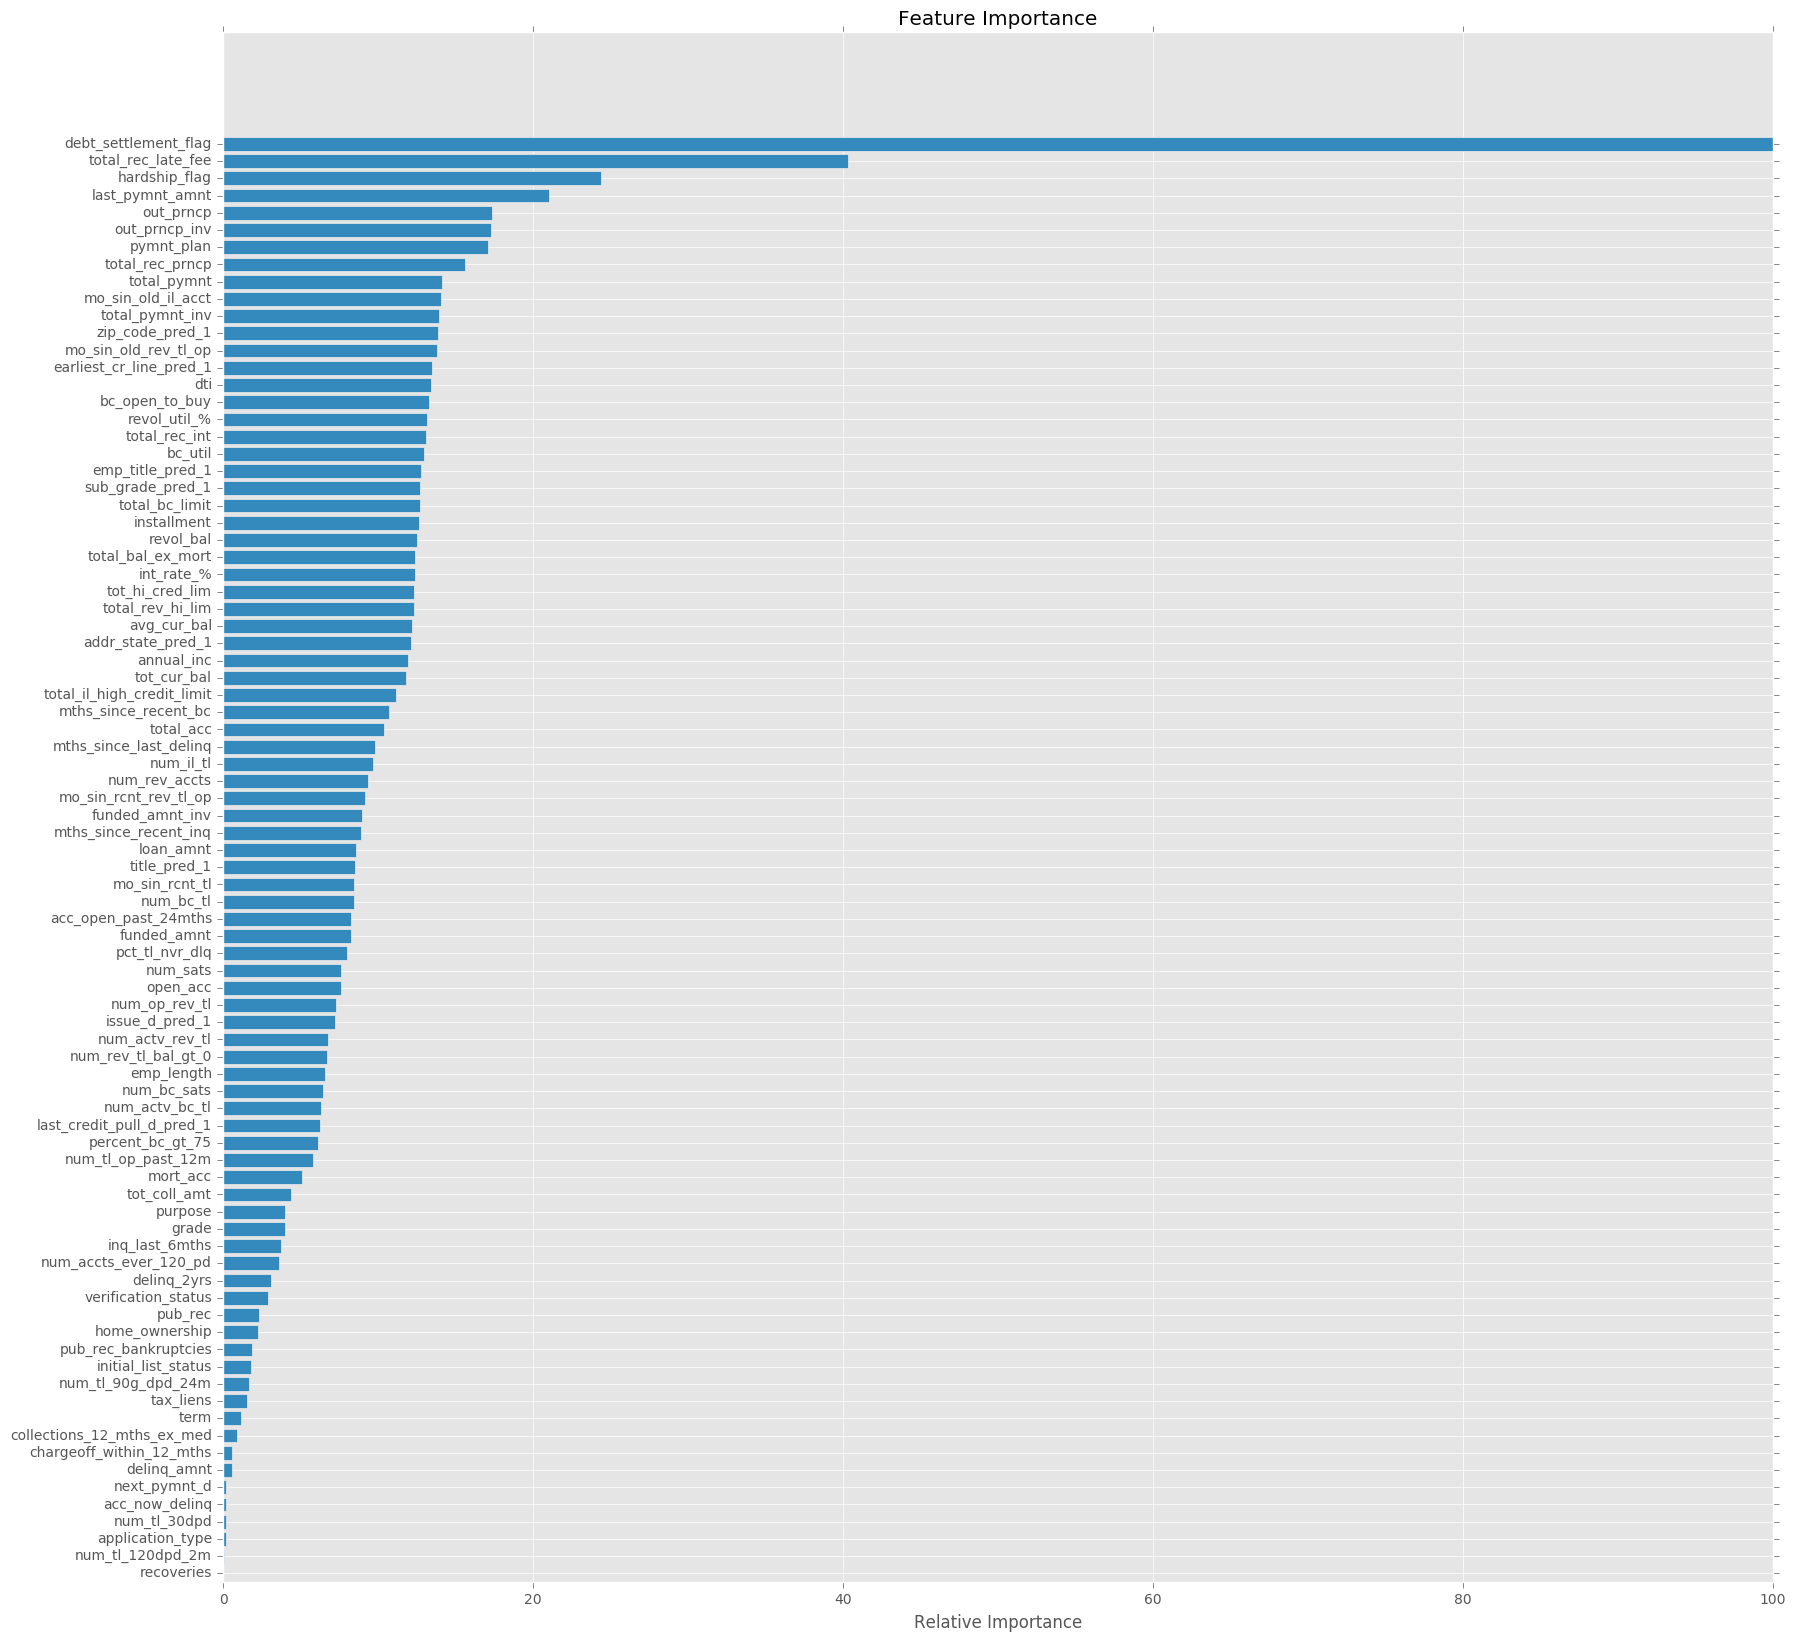

Wall time: 3min 20s


In [186]:
%%time
# 2-Random Forest
# Round 2: current loan-QuantileTransformer excluding last_pymnt_d
X_train = df_x_train_cur_scaled_Q[tmp]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[tmp]
y_test = df_test_encoded_cur['Default']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2,2)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(X_train.columns.values))
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

Seems like last_pymnt_d has extremely important impact on the prediction. So we tried to exclude it from model considering we would like to predict as early as possible

In [188]:
%%time
# 2-Random Forest
# Round 3: current loan-QuantileTransformer only using several important features
X_train = df_x_train_cur_scaled_Q[['debt_settlement_flag', 'total_rec_late_fee', 'hardship_flag', 'last_pymnt_amnt','out_prncp_inv', 'out_prncp', 'pymnt_plan']]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[['debt_settlement_flag', 'total_rec_late_fee', 'hardship_flag', 'last_pymnt_amnt','out_prncp_inv', 'out_prncp', 'pymnt_plan']]
y_test = df_test_encoded_cur['Default']

model_RF = RandomForestClassifier(n_estimators = 100)
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_RF.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.940467402346
0.695892220133
[[291871   4233]
 [ 14638   6244]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97    296104
          1       0.60      0.30      0.40     20882

avg / total       0.93      0.94      0.93    316986

Wall time: 1min 28s


In [193]:
%%time
# GBM-current loan-Robust scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

model_GBM = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1)
model_GBM.fit(X_train, y_train)
results = model_GBM.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_GBM.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.942458026537
0.677648869561
[[290899   5205]
 [ 13035   7847]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97    296104
          1       0.60      0.38      0.46     20882

avg / total       0.93      0.94      0.94    316986

Wall time: 32.7 s


In [194]:
%%time
# GBM-current loan-QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

model_GBM = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1)
model_GBM.fit(X_train, y_train)
results = model_GBM.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = model_GBM.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])
#confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, results)
print metrics.classification_report(y_test, results)

0.942464335964
0.677698083455
[[290899   5205]
 [ 13033   7849]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97    296104
          1       0.60      0.38      0.46     20882

avg / total       0.93      0.94      0.94    316986

Wall time: 32.7 s


In [197]:
'''
%%time
# LinearSVC--current loan--Robust Scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

clf = LinearSVC(random_state = 0)
clf.fit(X_train, y_train)

print clf.score(X_test,y_test)
'''

0.94718694201
Wall time: 1min 55s


In [211]:
%%time
# SGDClassifier--current loan--Robust Scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']
clf = linear_model.SGDClassifier(loss = 'modified_huber')
clf.fit(X_train, y_train)
results = clf.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = clf.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.934079107595
0.525341756187
Wall time: 1.17 s


In [198]:
'''
%%time
# LinearSVC--current loan--QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

clf = LinearSVC(random_state = 0)
clf.fit(X_train, y_train)

print clf.score(X_test,y_test)
'''

0.948016631649
Wall time: 2min


In [212]:
%%time
# SGDClassifier--current loan--QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

clf = linear_model.SGDClassifier(loss = 'modified_huber')
clf.fit(X_train, y_train)
results = clf.predict(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, results)
probs = clf.predict_proba(X_test)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.948123891907
0.738112020449
Wall time: 9.91 s


In [201]:
%%time
# KneighborClassifier--current loan--Robust Scaling
X_train = df_x_train_cur_scaled_R[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_R[ft_cur]
y_test = df_test_encoded_cur['Default']

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train) 

print neigh.score(X_test,y_test)

0.9269305269
Wall time: 2h 20min 24s


In [200]:
%%time
# KneighborClassifier--current loan--QuantileTransformer
X_train = df_x_train_cur_scaled_Q[ft_cur]
y_train = df_train_encoded_cur['Default']
X_test = df_x_test_cur_scaled_Q[ft_cur]
y_test = df_test_encoded_cur['Default']

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train) 

print neigh.score(X_test,y_test)

0.932416573603
Wall time: 5h 51min 55s


In [204]:
import sys
sys.executable
print(sys.version)
print(sys.version_info)

2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]
sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)
